In [ ]:
# **Author:** Matthew Eisenberg
**Submitted to:** Baltimore Ravens Quantitative Analyst Position
**Description:** This notebook contains models for evaluating the win probability impact of using a timeout now
       vs. saving it for later (specifically, in case it's needed to stop the clock late in the game), and includes models for:
- Penalty WPA loss prediction
- Marginal timeout value during late-game defensive stops
- Probability of a team needing a late-game defensive stop

In [ ]:
#Import Statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import CountModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# from py4etrics import tobit
import nfl_data_py as nfl

In [ ]:
#Seasons to work with
seasons = range(2002, 2024+1)
pbp_py = nfl.import_pbp_data(seasons)

2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


In [ ]:
#Set up display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)  # Set to a larger width as needed
pd.set_option('display.max_colwidth', None)  # Allows unlimited column width

In [ ]:
#Set Up PBP Main

#PBP MAIN: Timeout Modeling Main Table Cleaning / Transformation


#------------------------------------------------------------------------------------------------------------------------------------------#

#Cut down table to only needed columns
# pbp_main = pbp_py [['game_id','play_id','posteam','defteam','away_team','home_team','qtr','game_seconds_remaining',
#                     'time','score_differential','posteam_timeouts_remaining','defteam_timeouts_remaining',
#                     'away_timeouts_remaining','home_timeouts_remaining','timeout','timeout_team','wp','def_wp',
#                     'wpa','home_wp_post','away_wp_post','epa','spread_line','drive','series','yrdln','yardline_100',
#                     'down','ydstogo','play_type','yards_gained','rush_attempt','pass_attempt','own_kickoff_recovery','temp','wind',
#                     'first_down','series_result','touchdown','third_down_converted','fourth_down_converted','third_down_failed','fourth_down_failed',
#                        'field_goal_result','pass','qb_epa']].copy()

pbp_main = pbp_py[['game_id','play_id','posteam','defteam',
'posteam_score','defteam_score',
'qtr','time','yrdln',
'down','ydstogo','yardline_100','goal_to_go',
'game_seconds_remaining','half_seconds_remaining',
'score_differential','total_home_score','total_away_score',
# 'posteam_score_post','defteam_score_post','score_differential_post',  #Unused Score Columns (for now)
'drive','series',
'vegas_wp','vegas_wpa',
'wp','def_wp','wpa','home_wp','away_wp','home_wp_post','away_wp_post',
'play_type','pass','rush','pass_attempt','rush_attempt','out_of_bounds','sp',
'yards_gained','first_down',
'touchdown','safety','field_goal_attempt','field_goal_result','two_point_attempt',
'kickoff_attempt','home_opening_kickoff','own_kickoff_recovery',
'special',
# 'extra_point_attempt','punt_attempt',  #Unused Special Teams (for now)
'fumble_lost','interception','sack',
'posteam_timeouts_remaining','defteam_timeouts_remaining','away_timeouts_remaining','home_timeouts_remaining','timeout','timeout_team',
'penalty','penalty_team','penalty_yards','penalty_type','play',
'series_result','series_success',
'away_team','home_team',
'spread_line','total_line',
'third_down_converted','third_down_failed','fourth_down_converted','fourth_down_failed',
# 'replay_or_challenge','replay_or_challenge_result',
'passer_player_id','passer_player_name','passer','passer_id',
# 'home_coach','away_coach',
'season','week','season_type','div_game',
'ep','epa','total_home_epa','total_away_epa','total_home_rush_epa','total_away_rush_epa','total_home_pass_epa','total_away_pass_epa','qb_epa',
'away_score','home_score','result','total']].copy()


#------------------------------------------------------------------------------------------------------------------------------------------#

#Fill all def_wp null values with 0 (because when the game is over, it is initally recorded as null instead of 0)
pbp_main['wp'] = pbp_main['wp'].fillna(0)
pbp_main['def_wp'] = pbp_main['def_wp'].fillna(0)
pbp_main['home_wp_post'] = pbp_main['home_wp_post'].fillna(0)
pbp_main['away_wp_post'] = pbp_main['away_wp_post'].fillna(0)

#------------------------------------------------------------------------------------------------------------------------------------------#

#Create many columns to add to the main table for analysis

    #Create column for "seconds remaining in series"

pbp_main['series_start_seconds_remaining'] = pbp_main.groupby(['game_id','series'])['game_seconds_remaining'].transform('first')


    #Create column: whether the defending team was home or away

pbp_main['defteam_home_status'] = np.where(
    pbp_main['home_team'] == pbp_main['defteam'], 1, np.where(
        pbp_main['defteam'] == pbp_main['away_team'], 0,
        np.nan  # Leave the value as NaN if neither condition is met
    ))

    #Create column: "Year" based on the first four characters of the game ID

pbp_main['year'] = pbp_main['game_id'].str[0:4]
pbp_main['year'] = pbp_main['year'].astype(int)

#------------------------------------------------------------------------------------------------------------------------------------------#



#------------------------------------------------------------------------------------------------------------------------------------------#

#Create the two additional time-adjusted variables used to build the NFL FAST R WP model

# Time-normalized factor
time_factor = (3600 - pbp_main['game_seconds_remaining']) / 3600

# 1. spread_time = posteam_spread * e^(-4 * time_factor)
pbp_main['spread_time'] = pbp_main['spread_line'] * np.exp(-4 * time_factor)

# 2. diff_time_ratio = point_differential * e^(4 * time_factor)
pbp_main['diff_time_ratio'] = pbp_main['score_differential'] * np.exp(4 * time_factor)

#------------------------------------------------------------------------------------------------------------------------------------------#

#Main Denominator for Rolling Average Plays -- Normal Offensive / Defensive Play

pbp_main['play_off_or_def'] = np.where(
                        ((pbp_main['play_type'] == 'pass') |
                        (pbp_main['play_type'] == 'run') |
                         (pbp_main['play_type'] == 'qb_spike'))
                         ,1,0)

#------------------------------------------------------------------------------------------------------------------------------------------#

#Columns to create redzone points per drive stat

    #Flag if drive ever entered the red zone
pbp_main['drive_entered_redzone'] = (
    pbp_main
    .groupby(['game_id', 'drive'])['yardline_100']
    .transform(lambda x: (x <= 20).any())
)

    #Create a row index for the first play of each drive
pbp_main['drive_play_index'] = (
    pbp_main[pbp_main['play_off_or_def'] == 1]
    .groupby(['game_id', 'drive'])
    .cumcount()
    + 1
)

    #Set new column to only 1 for the first play of the drive that entered redzone (for counting purposes)
pbp_main['redzone_drive_start'] = (
    (pbp_main['drive_entered_redzone']) &
    (pbp_main['drive_play_index'] == 1)
).astype(int)


    #Drop helper columns
pbp_main.drop(['drive_entered_redzone', 'drive_play_index'], axis=1, inplace=True)


    #Redzone drive ended in a touchdown
drive_rz_td_flags = (
    pbp_main
    .groupby(['game_id', 'drive'])
    .apply(lambda df: ((df['yardline_100'] <= 20).any() and (df['touchdown'] == 1).any()))
    .rename("drive_rz_td")
)

    #Merge that result back into the main dataframe
pbp_main = pbp_main.merge(drive_rz_td_flags, on=['game_id', 'drive'], how='left')

    #Create drive play index, but only count real plays (play_off_or_def == 1)
pbp_main['drive_play_index'] = (
    pbp_main[pbp_main['play_off_or_def'] == 1]
    .groupby(['game_id', 'drive'])
    .cumcount() + 1
)

    # Fill non-play rows with 0
pbp_main['drive_play_index'] = pbp_main['drive_play_index'].fillna(0).astype(int)

    #Create final column — 1 only on first real play of drive that entered red zone and scored a TD
pbp_main['drive_redzone_td_start'] = (
    (pbp_main['drive_rz_td']) &
    (pbp_main['drive_play_index'] == 1)
).astype(int)

    #Drop helper columns
pbp_main.drop(['drive_rz_td', 'drive_play_index'], axis=1, inplace=True)



    #Field goal tracker columns for indicating if a redzone drive ended in a FG (for calculation purposes)

pbp_main['field_goal_made'] = np.where(pbp_main['field_goal_result'] == 'made', 1, 0)
pbp_main['field_goal_missed'] = np.where(pbp_main['field_goal_result'] == 'missed', 1, 0)

    #Whether a redzone drive ended in a field goal
drive_rz_fg_flags = (
    pbp_main
    .groupby(['game_id', 'drive'])
    .apply(lambda df: ((df['yardline_100'] <= 20).any() and (df['field_goal_made'] == 1).any()))
    .rename("drive_rz_fg")
)

    #Merge that result back into the main dataframe
pbp_main = pbp_main.merge(drive_rz_fg_flags, on=['game_id', 'drive'], how='left')

    #Create drive play index, but only count real plays (play_off_or_def == 1)
pbp_main['drive_play_index'] = (
    pbp_main[pbp_main['play_off_or_def'] == 1]
    .groupby(['game_id', 'drive'])
    .cumcount() + 1
)

    #Fill non-play rows with 0 (or use NaN if you'd prefer to keep them separate)
pbp_main['drive_play_index'] = pbp_main['drive_play_index'].fillna(0).astype(int)

    #Create final column — 1 only on first real play of drive that entered red zone and scored a TD
pbp_main['drive_redzone_fg_start'] = (
    (pbp_main['drive_rz_fg']) &
    (pbp_main['drive_play_index'] == 1)
).astype(int)

    #Drop helper columns
pbp_main.drop(['drive_rz_fg', 'drive_play_index'], axis=1, inplace=True)

    #Final redzone_points column

pbp_main['redzone_points'] = 7 * pbp_main['drive_redzone_td_start'] + 3 * pbp_main['drive_redzone_fg_start'] #Assumes all extra points are made


#------------------------------------------------------------------------------------------------------------------------------------------#

#Additional columns for rolling average calculations

    #High leverage conversion:

pbp_main['high_leverage_converted'] = np.where(
                        ((pbp_main['third_down_converted'] == 1) | (pbp_main['fourth_down_converted'] == 1)),1,0
)

pbp_main['high_leverage_attempt'] = np.where(
                        ((pbp_main['third_down_converted'] == 1) | (pbp_main['fourth_down_converted'] == 1) | (pbp_main['third_down_failed'] == 1) | (pbp_main['fourth_down_failed'] == 1)),1,0
)


    #Successful Play

pbp_main['off_successful'] = np.where(


                          ((pbp_main['play_off_or_def'] == 1) & (pbp_main['down'] == 1) & (pbp_main['yards_gained'] >= 0.4 * pbp_main['ydstogo'])) |
                          ((pbp_main['play_off_or_def'] == 1) & (pbp_main['down'] == 2) & (pbp_main['yards_gained'] >= 0.6 * pbp_main['ydstogo'])) |
                          ((pbp_main['play_off_or_def'] == 1) & (pbp_main['down'] == 3) & (pbp_main['yards_gained'] >= 1.0 * pbp_main['ydstogo'])) |
                          ((pbp_main['play_off_or_def'] == 1) & (pbp_main['down'] == 4) & (pbp_main['yards_gained'] >= 1.0 * pbp_main['ydstogo'])), 1,

                        np.where(

                          ((pbp_main['play_off_or_def'] == 1) & (pbp_main['down'] == 1) & (pbp_main['yards_gained'] < 0.4 * pbp_main['ydstogo'])) |
                          ((pbp_main['play_off_or_def'] == 1) & (pbp_main['down'] == 2) & (pbp_main['yards_gained'] < 0.6 * pbp_main['ydstogo'])) |
                          ((pbp_main['play_off_or_def'] == 1) & (pbp_main['down'] == 3) & (pbp_main['yards_gained'] < 1.0 * pbp_main['ydstogo'])) |
                          ((pbp_main['play_off_or_def'] == 1) & (pbp_main['down'] == 4) & (pbp_main['yards_gained'] < 1.0 * pbp_main['ydstogo'])), 0, np.nan))

#------------------------------------------------------------------------------------------------------------------------------------------#

#Random one line variables (generally for rolling avg. calculations)

pbp_main['off_penalty'] = np.where((pbp_main['penalty'] == 1) & (pbp_main['penalty_team'] == pbp_main['posteam']) & pbp_main['play_off_or_def'] == 1, 1, 0)


pbp_main['turnover'] = np.where((pbp_main['fumble_lost'] == 1) | (pbp_main['interception'] == 1), 1, 0)

pbp_main['explosive_play'] = np.where(((pbp_main['rush'] ==1) & (pbp_main['yards_gained'] >= 10)) |
                                      ((pbp_main['pass'] ==1) & (pbp_main['yards_gained'] >= 20)), 1, 0)

pbp_main['chaotic_play'] = np.where((pbp_main['sack'] == 1) | (pbp_main['turnover'] == 1) | (pbp_main['explosive_play'] == 1) | (pbp_main['touchdown'] ==1), 1, 0)

pbp_main['total_score'] = pbp_main['total_home_score'] + pbp_main['total_away_score']

pbp_main['points_per_second'] = pbp_main['total_score'] / (3600 - pbp_main['game_seconds_remaining'])

pbp_main['points_per_drive'] = np.where(pbp_main['drive'] == 1, 0, (pbp_main['total_score'] / (pbp_main['drive'] - 1)))

pbp_main['redzone'] = np.where(pbp_main['yardline_100'] <= 20, 1, 0)

#------------------------------------------------------------------------------------------------------------------------------------------#

#Adjusting Vegas WP for use in later models

pbp_main['vegas_wp'] = np.where(
                        ((pbp_main['vegas_wp'].isnull()) & (pbp_main['game_seconds_remaining'] == 0) & (pbp_main['score_differential'] > 0)), 1,
                         np.where(
                             (pbp_main['vegas_wp'].isnull()) & (pbp_main['game_seconds_remaining'] == 0) & (pbp_main['score_differential'] < 0), 0,
                        pbp_main['vegas_wp']))

pbp_main = pbp_main.dropna(subset = 'vegas_wp')

pbp_main['vegas_wpa'] = pbp_main['vegas_wpa'].fillna(0)

pbp_main['vegas_posteam_wp'] = pbp_main['vegas_wp']
pbp_main['vegas_defteam_wp'] = 1 - pbp_main['vegas_posteam_wp']

pbp_main['vegas_posteam_wp_post'] = pbp_main['vegas_wp'] + pbp_main['vegas_wpa']
pbp_main['vegas_defteam_wp_post'] = pbp_main['vegas_defteam_wp'] - pbp_main['vegas_wpa']

pbp_main['vegas_home_wp'] = np.where(pbp_main['posteam'] == pbp_main['home_team'], pbp_main['vegas_wp'], (1 - pbp_main['vegas_wp']))
pbp_main['vegas_away_wp'] = np.where(pbp_main['defteam'] == pbp_main['away_team'], (1 - pbp_main['vegas_wp']), pbp_main['vegas_wp'])
pbp_main['vegas_home_wpa'] = np.where(pbp_main['posteam'] == pbp_main['home_team'], pbp_main['vegas_wpa'], (1 - pbp_main['vegas_wpa']))
pbp_main['vegas_home_wpa'] = np.where(pbp_main['posteam'] == pbp_main['home_team'], pbp_main['vegas_wpa'], (1 - pbp_main['vegas_wpa']))

#------------------------------------------------------------------------------------------------------------------------------------------#

#Columns  to calculate pace of play (seconds per snap)

pbp_main['sec_remaining_at_next_step'] = pbp_main.groupby(['game_id','drive'])['game_seconds_remaining'].shift(-1)

next_game_seconds = pbp_main['game_seconds_remaining'].shift(-1)
pbp_main['sec_remaining_at_next_step'] = np.where(
    pbp_main['sec_remaining_at_next_step'].isna() & (pbp_main['play_off_or_def'] == 1),
    next_game_seconds,
    pbp_main['sec_remaining_at_next_step'].fillna(pbp_main['game_seconds_remaining'])
)

pbp_main['sec_to_next_snap'] =  pbp_main['game_seconds_remaining'] - pbp_main['sec_remaining_at_next_step']

#------------------------------------------------------------------------------------------------------------------------------------------#

#Columns to calculate drive play count


pbp_main['drive_play_count'] = np.nan  # Initialize column with NaNs

# Compute play count only for rows where play_off_or_def == 1
pbp_main.loc[pbp_main['play_off_or_def'] == 1, 'drive_play_count'] = (
    pbp_main[pbp_main['play_off_or_def'] == 1]
    .groupby(['game_id', 'drive'])
    .cumcount() + 1
)

# pbp_main['log_play_count'] = np.log1p(pbp_main['drive_play_count'])
pbp_main['distance_to_crunch_time'] = (pbp_main['game_seconds_remaining'] - 300) / 300


#------------------------------------------------------------------------------------------------------------------------------------------#

#Code to create bucketing of different variables (e.g. game_seconds_remaining, score_differential, yardline_100, and era)

# ---- Time Bucket _____
time_bucket_bins = [0, 300, 600, 900, 1200, 1500, 1800]
time_bucket_labels = [
    'Late Q4',
    'Mid Q4',
    'Early Q4',
    'Late Q3',
    'Mid Q3',
    'Early Q3',
]

# Apply pd.cut without reversing bins
pbp_main['second_half_time_bucket'] = pd.cut(
    pbp_main['game_seconds_remaining'],
    bins=time_bucket_bins,
    labels=time_bucket_labels,
    right=True
)

# ---- Score Bucket _____
score_bucket_bins = [-100, -9, -1,0, 8,100]
score_bucket_labels = [
    'Down 2+ Scores',
    'Down 1 Score',
    'Tied',
    'Up 1 Score',
    'Up 2+ Scores',
]

pbp_main['second_half_play_score_bucket'] = pd.cut(
    pbp_main['score_differential'],
    bins=score_bucket_bins,
    labels=score_bucket_labels,
    right=True
)

# ---- Yardline Bucket Bucket _____
yardline_bucket_bins = [0,20, 35, 50, 101]
yardline_bucket_labels = [
    'Redzone',
    'FG Range',
    "No-Man's Land",
    'Own Side of Field',
]

pbp_main['second_half_play_ydline_bucket'] = pd.cut(
    pbp_main['yardline_100'],
    bins=yardline_bucket_bins,
    labels=yardline_bucket_labels,
    right=False
)


# ---- Era Bucket _____
era_bucket_bins = [2001, 2006, 2011, 2016, 2020, 2025]
era_bucket_labels = [
    '2001-05',
    '2006-10',
    '2011-15',
    '2016-20',
    '2021-25',
]

pbp_main['era_bucket'] = pd.cut(
    pbp_main['year'],
    bins=era_bucket_bins,
    labels=era_bucket_labels,
    right=False
)

#------------------------------------------------------------------------------------------------------------------------------------------#

#Show the table

# pbp_main.query('game_id == "2015_01_CAR_JAX"').tail(50)




/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/3359390348.py:247: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: ((df['yardline_100'] <= 20).any() and (df['touchdown'] == 1).any()))
/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/3359390348.py:284: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: ((df['yardline_100'] <= 20).any() and (df['fi

In [ ]:
#Rolling Calculator -- Define Class

# USE: This purpose of the "rolling calculator" is to be able to easily calculate any rolling stat on a per-play, weekly or season basis,
#       either weighted or unweighted, just by substituting in the correct inputs (e.g. numerator, denominator, columns to group by, etc.)

import pandas as pd
from collections import defaultdict, OrderedDict

class RollingAverageCalculator:
    def __init__(self, pbp_df, calculation_dict, config_dict, team_role, side_of_ball):
        self.original_df = pbp_df.copy()
        self.df = pbp_df.copy()
        self.calculation_dict = calculation_dict
        self.configs = config_dict
        self.team_role = team_role
        self.side_of_ball = side_of_ball.lower()
        self.label = 'offense' if team_role == 'posteam' else 'defense' if team_role == 'defteam' else (_ for _ in ()).throw(ValueError('Invalid team_role'))

        # Mappings and containers
        self.list_of_columns_to_keep = []
        self.built_tables = {}
        self.stat_to_table_map = {}
        self.df_final = None
        self.column_to_stat = {}

        # Prepare config mappings
        self.prepare_config_mappings()

    def prepare_config_mappings(self):
        self.stat_timeframe_ids = self.configs['stat_timeframe_unique_ids']
        self.rolling_group_columns_cfg = self.configs['rolling_group_columns']

        self.calc_num = {k: v['numerator'] for k, v in self.calculation_dict.items()}
        self.calc_den = {k: v['denominator'] for k, v in self.calculation_dict.items()}
        self.calc_agg = {k: v['agg_func'] for k, v in self.calculation_dict.items()}
        self.calc_window = {k: v['window/span'] for k, v in self.calculation_dict.items()}
        self.calc_weighted = {k: v['weighted'] for k, v in self.calculation_dict.items()}
        self.calc_timeframe = {k: v['stat_timeframe'] for k, v in self.calculation_dict.items()}
        self.calc_extra_cols = {k: v['extra_group_cols'] for k, v in self.calculation_dict.items()}
        self.calc_condition = {k: v['condition'] for k, v in self.calculation_dict.items()}
        self.calc_cond_col = {k: v['condition_column'] for k, v in self.calculation_dict.items()}

    def build_stat_tables(self):
        table_groups = defaultdict(list)

        for stat in self.calculation_dict:
            tf = self.calc_timeframe[stat]
            cond = self.calc_condition[stat]
            extra_cols = tuple(self.calc_extra_cols[stat])
            table_groups[(tf, cond, extra_cols)].append(stat)

        for (tf, cond, extra_cols), stat_list in table_groups.items():
            unique_ids = self.stat_timeframe_ids[tf]
            group_by = [self.team_role] + unique_ids + list(extra_cols)
            rolling_group = [self.team_role] + self.rolling_group_columns_cfg[tf] + list(extra_cols)

            agg_dict = {}
            for stat in stat_list:
                num = self.calc_num[stat]
                den = self.calc_den[stat]
                agg_dict[num] = self.calc_agg[stat]
                if den != 'none':
                    agg_dict[den] = self.calc_agg[stat]

            keep_cols = group_by + list(set().union(*[self.calc_cond_col[s] for s in stat_list])) + list(agg_dict.keys())
            keep_cols = list(OrderedDict.fromkeys(keep_cols))
            df_subset = self.df[keep_cols].copy()

            if cond:
                df_subset = df_subset.query(cond)
            if tf != "play_by_play":
                df_subset = df_subset.groupby(group_by).agg(agg_dict).reset_index()

            self.built_tables[(tf, cond, extra_cols)] = {
                'df': df_subset,
                'group_by_columns': group_by,
                'rolling_group_columns': rolling_group,
                'stat_list': stat_list
            }

        for key, table_info in self.built_tables.items():
            for stat in table_info['stat_list']:
                self.stat_to_table_map[stat] = {
                    'df': table_info['df'],
                    'group_by_columns': table_info['group_by_columns'],
                    'rolling_group_columns': table_info['rolling_group_columns']
                }


    def calculate_rolling_averages(self):
        for stat in self.stat_to_table_map:



            # print(f'stat attempted {stat}; {stat}')
            # print(f'stat to table map; {self.stat_to_table_map[stat]}')

            df_rolling = self.stat_to_table_map[stat]['df']

            # print(f'df rolling {stat}; {df_rolling.head(10)}')


            group_by_cols = self.stat_to_table_map[stat]['group_by_columns']
            rolling_group_cols = self.stat_to_table_map[stat]['rolling_group_columns']
            timeframe_label = self.calc_timeframe[stat]

            # print(f'group by columns {stat}; {group_by_cols}')
            # print(f'rolling group columns {stat}; {rolling_group_cols}')
            # print(f'timeframe label {stat}; {timeframe_label}')

            new_col = f'{self.label}_{stat}_{timeframe_label}_roll'
            num = self.calc_num[stat]
            den = self.calc_den[stat]

            # print(f'num {stat}; {num}')
            # print(f'denom {stat}; {den}')

            for col in rolling_group_cols:
              if col not in df_rolling.columns:
                  print(f"❌ Column missing in df_rolling: {col}")
                  print(f"📌 Stat: {stat}")
                  print(f"🧠 Rolling group columns: {rolling_group_cols}")
                  print(f"📄 Available columns: {df_rolling.columns.tolist()}")
                  raise KeyError(col)

            # print(f"\n➡️ Processing stat: {stat}")
            # print(f"Group size: {df_rolling.shape}")
            # print(f"Rolling groups: {df_rolling.groupby(rolling_group_cols).ngroups}")
            # print(f"Sample values:\n{df_rolling.head(10)}")

            if self.calc_weighted[stat] == 'yes':
                span = self.calc_window[stat]
                df_rolling['ewma_col1'] = df_rolling.groupby(rolling_group_cols)[num].transform(lambda x: x.ewm(span=span).sum())
                df_rolling['ewma_col2'] = 1 if den == 'none' else df_rolling.groupby(rolling_group_cols)[den].transform(lambda x: x.ewm(span=span).sum())
                df_rolling[new_col] = df_rolling['ewma_col1'] / df_rolling['ewma_col2']
                df_rolling[new_col] = df_rolling.groupby(rolling_group_cols)[new_col].shift(1)
                self.df = self.df.merge(df_rolling[group_by_cols + [new_col]], on=group_by_cols, how='left')

            else:


                self.df['game_index'] = self.df.groupby(rolling_group_cols).cumcount() + 1

                # print(f'df rolling -- {stat}: {df_rolling.head(10)}')
                # print(f'rolling groups: {rolling_group_cols}')

                df_rolling['game_index'] = df_rolling.groupby(rolling_group_cols).cumcount() + 1
                win = self.calc_window[stat]

                rolling_df = df_rolling.groupby(rolling_group_cols).rolling(window=win, min_periods=1, on='game_index')[[num, den]].sum().reset_index()
                rolling_df[new_col] = rolling_df[num] / rolling_df[den]
                rolling_df[new_col] = rolling_df.groupby(rolling_group_cols)[new_col].shift(1)

                df_rolling = df_rolling.merge(rolling_df[rolling_group_cols + ['game_index', new_col]], on=rolling_group_cols + ['game_index'], how='left')
                self.df = self.df.merge(df_rolling[group_by_cols + [new_col]], on=group_by_cols, how='left')

            self.list_of_columns_to_keep.append(new_col)
            self.column_to_stat[new_col] = stat
            print(f'stat completed; {stat}')

        keep_keys = set()
        for stat in self.stat_to_table_map:
            keep_keys.update(self.stat_to_table_map[stat]['group_by_columns'])

        merge_cols = list(keep_keys) + self.list_of_columns_to_keep
        if 'play_id' not in merge_cols:
            merge_cols.append('play_id')
        if 'home_team' not in merge_cols:
            merge_cols.append('home_team')
        if 'away_team' not in merge_cols:
            merge_cols.append('away_team')

        self.df_final = self.df[merge_cols]

    def apply_backfill_and_ffill(self):
        for col in self.list_of_columns_to_keep:
            for stat in self.calculation_dict:
                expected_name = f'{self.label}_{stat}_{self.calc_timeframe[stat]}_roll'
                if col == expected_name and self.calc_condition[stat] is not None:
                    group_cols = [self.team_role] + self.rolling_group_columns_cfg[self.calc_timeframe[stat]]
                    group_cols += self.calc_extra_cols[stat]

                    updated_chunks = []
                    for _, group in self.df_final.groupby(group_cols):
                        series = group[col]
                        if series.isnull().all():
                            updated_chunks.append(series)
                            continue

                        first_valid_idx = series.first_valid_index()
                        last_valid_idx = series.last_valid_index()

                        first_pos = series.index.get_loc(first_valid_idx)
                        last_pos = series.index.get_loc(last_valid_idx)

                        before = series.iloc[:first_pos]
                        middle = series.iloc[first_pos:last_pos + 1].bfill()
                        after = series.iloc[last_pos + 1:]

                        if not after.empty:
                            last_value = series.iloc[last_pos]
                            after = after.copy()
                            after[:] = last_value

                        combined = pd.concat([before, middle, after])
                        updated_chunks.append(combined)

                    self.df_final[col] = pd.concat(updated_chunks).sort_index()

        print('Completed bfil & ffill')

    def merge_to_original(self):
        right_df = self.df_final.copy()
        left_df = self.original_df.copy()


        if self.side_of_ball == 'offense':
            prefix = 'pos_'
            right_team = 'posteam'
        elif self.side_of_ball == 'defense':
            prefix = 'def_'
            right_team = 'defteam'
        else:
            raise ValueError("side_of_ball must be 'offense' or 'defense'")

        if self.team_role == right_team:


          left_keys = ['game_id', 'play_id']
          right_keys = ['game_id', 'play_id']

          rename_dict = {col: f'{prefix}{col}' for col in self.list_of_columns_to_keep}
          right_df = right_df.rename(columns=rename_dict)
          new_cols = list(rename_dict.values())

          missing_cols = [col for col in new_cols if col not in left_df.columns]
          if not missing_cols:
              print("All columns already exist — skipping merge.")
              return left_df


          final_df = left_df.merge(right_df[left_keys + missing_cols], on=left_keys, how='left')


        else:

          left_keys = ['game_id', 'play_id']
          right_keys = ['game_id', 'play_id']

          # away_column_names = [] #REMOVE AFTER TESTING
          # home_column_names = [] #REMOVE AFTER TESTING
          final_column_names = []


          for col in self.list_of_columns_to_keep:

            expected_away_column_name = f'away_{col}'
            expected_home_column_name = f'home_{col}'
            expected_final_column_name = f'{prefix}{col}'

            right_df[expected_away_column_name] = np.where(right_df['away_team'] == right_df[self.team_role], right_df[col], np.nan)
            right_df[expected_home_column_name] = np.where(right_df['home_team'] == right_df[self.team_role], right_df[col], np.nan)

            print(f'col: {col}')

            stat = self.column_to_stat[col]  # Lookup original stat key
            timeframe = self.calc_timeframe[stat]
            group_cols = self.rolling_group_columns_cfg[timeframe] + self.calc_extra_cols[stat]

            group_away = group_cols + ['away_team']
            group_home = group_cols + ['home_team']

            right_df[expected_away_column_name] = right_df.groupby(group_away, group_keys=False)[expected_away_column_name].ffill()
            right_df[expected_home_column_name] = right_df.groupby(group_home, group_keys=False)[expected_home_column_name].ffill()


            right_df[expected_final_column_name] = np.where(right_df['away_team'] == right_df[self.team_role], right_df[expected_home_column_name],
                                                            np.where(right_df['home_team'] == right_df[self.team_role], right_df[expected_away_column_name], np.nan))


            final_column_names.append(expected_final_column_name)
            # away_column_names.append(expected_away_column_name)
            # home_column_names.append(expected_home_column_name)

            right_df = right_df.drop(columns=expected_away_column_name)
            right_df = right_df.drop(columns=expected_home_column_name)

          # # print(f'right df: {right_df.head(50)}')
          # a = ['game_id','posteam','away_team','home_team']
          # c = a + final_column_names
          # print(f'right df: {right_df[c].head(50)}')

          missing_cols = [col for col in final_column_names if col not in left_df.columns]
          if not missing_cols:
              print("All columns already exist — skipping merge.")
              return left_df

          final_df = left_df.merge(right_df[left_keys + missing_cols], on=left_keys, how='left')

        return final_df

    def run(self):
        self.build_stat_tables()
        self.calculate_rolling_averages()
        self.apply_backfill_and_ffill()
        return self.merge_to_original()


In [ ]:
#Rolling Calculator -- Configs

configs = {

           'stat_timeframe_unique_ids' : {
              'play_by_play': ['game_id','play_id'],
              'weekly': ['game_id'],
              'season': ['season']
           },


            'rolling_group_columns' : {
              'play_by_play': ['game_id'],
              'weekly': [],
              'season': []
           }

}

In [ ]:
#Rolling Calculator -- Calculation Dictionary

calculation_dictionary = {


  #--------- 1. WEEK TO WEEK (PERFORMANCE OVER TIME) -------------

  #TEAM PERFORMANCE -- OVERALL

     'epa_per_play_wk': {
        'numerator': 'epa',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 8,
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':[],
        'condition': None
    },

     'success_rate_wk': {
        'numerator': 'off_successful',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 8,
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':[],
        'condition': None
    },

  #TEAM PERFORMANCE -- SPECIFIC AREAS

     'off_penalty_rate_wk': {
        'numerator': 'off_penalty',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 8,
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':[],
        'condition': None
    },

    #  'off_mental_penalty_rate_wk': {
    #     'numerator': 'full_offensive_presnap_penalty',
    #     'agg_func': 'sum',
    #     'denominator': 'play_off_or_def',
    #     'extra_group_cols': [],
    #     'window/span': 8,
    #     'weighted': 'yes',
    #     'stat_timeframe': 'weekly',
    #     'condition_column':[],
    #     'condition': None
    # },


     'turnover_rate_wk': {
        'numerator': 'turnover',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 8,
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':[],
        'condition': None
    }
        ,

      'explosive_rate_wk': {
        'numerator': 'explosive_play',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 8,
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':[],
        'condition': None
    }
        ,

      'chaos_rate_wk': {
        'numerator': 'chaotic_play',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 8,
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':[],
        'condition': None
    }
        ,


    'high_leverage_conv_rate_wk': {
        'numerator': 'high_leverage_converted',
        'agg_func': 'sum',
        'denominator': 'high_leverage_attempt',
        'extra_group_cols': [],
        'window/span': 8,
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':[],
        'condition': None
    },


     'yards_per_play_wk': {
        'numerator': 'yards_gained',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 8,
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':[],
        'condition': None
    }
        ,

      'first_down_rate_wk': {
        'numerator': 'first_down',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 8,
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':[],
        'condition': None
    }
        ,


        'time_of_possession_wk': {         #NOTE: This EXCLUDES SPECIAL TEAMS TOP AND SO WON'T ADD UP TO 60 MIN
        'numerator': 'sec_to_next_snap',
        'agg_func': 'sum',
        'denominator': 'none',
        'extra_group_cols': [],
        'window/span': 8,
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':[],
        'condition': None
    }
        ,


     'redzone_points_per_trip': {
        'numerator': 'redzone_points',
        'agg_func': 'sum',
        'denominator': 'redzone_drive_start',
        'extra_group_cols': [],
        'window/span': 8,
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':[],
        'condition': None
    },


    'rush_success_rate_wk': {
        'numerator': 'off_successful',
        'agg_func': 'sum',
        'denominator': 'rush',
        'extra_group_cols': [],
        'window/span': 8,
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':[],
        'condition': None
    },

  # #PLAYER PERFORMANCE

    'qb_epa_per_play_wk': {
        'numerator': 'qb_epa',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 16, #Higher span for QBs because this shouldn't overreact as much over a small sample
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':['pass'],
        'condition': '`pass` == 1'
    },


  #TEAM TENDENCIES

      'pass_rate_wk': {
        'numerator': 'pass',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 8,
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':[],
        'condition': None
    }
        ,

      'pace_of_play_wk': {
        'numerator': 'sec_to_next_snap',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 8,
        'weighted': 'yes',
        'stat_timeframe': 'weekly',
        'condition_column':[],
        'condition': None
    }
        ,


  #--------- 2. PLAY TO PLAY (PERFORMANCE IN GAME) -------------



  #TEAM PERFORMANCE -- OVERALL

     'epa_per_play_pbp': {
        'numerator': 'epa',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 100,
        'weighted': 'no',
        'stat_timeframe': 'play_by_play',
        'condition_column':[],
        'condition': None
    },

     'success_rate_pbp': {
        'numerator': 'off_successful',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 100,
        'weighted': 'no',
        'stat_timeframe': 'play_by_play',
        'condition_column':[],
        'condition': None
    },

  # #TEAM PERFORMANCE -- SPECIFIC AREAS

  #    'off_penalty_rate_pbp': {
  #       'numerator': 'off_penalty',
  #       'agg_func': 'sum',
  #       'denominator': 'play_off_or_def',
  #       'extra_group_cols': [],
  #       'window/span': 100,
  #       'weighted': 'no',
  #       'stat_timeframe': 'play_by_play',
  #       'condition_column':[],
  #       'condition': None
  #   },

  #    'off_mental_penalty_rate_pbp': {
  #       'numerator': 'full_offensive_presnap_penalty',
  #       'agg_func': 'sum',
  #       'denominator': 'play_off_or_def',
  #       'extra_group_cols': [],
  #       'window/span': 100,
  #       'weighted': 'no',
  #       'stat_timeframe': 'play_by_play',
  #       'condition_column':[],
  #       'condition': None
  #   },


  #    'turnover_rate_pbp': {
  #       'numerator': 'turnover',
  #       'agg_func': 'sum',
  #       'denominator': 'play_off_or_def',
  #       'extra_group_cols': [],
  #       'window/span': 100,
  #       'weighted': 'no',
  #       'stat_timeframe': 'play_by_play',
  #       'condition_column':[],
  #       'condition': None
  #   }
  #       ,

  #     'explosive_rate_pbp': {
  #       'numerator': 'explosive_play',
  #       'agg_func': 'sum',
  #       'denominator': 'play_off_or_def',
  #       'extra_group_cols': [],
  #       'window/span': 100,
  #       'weighted': 'no',
  #       'stat_timeframe': 'play_by_play',
  #       'condition_column':[],
  #       'condition': None
  #   }
  #       ,

  #     'chaos_rate_pbp': {
  #       'numerator': 'chaotic_play',
  #       'agg_func': 'sum',
  #       'denominator': 'play_off_or_def',
  #       'extra_group_cols': [],
  #       'window/span': 100,
  #       'weighted': 'no',
  #       'stat_timeframe': 'play_by_play',
  #       'condition_column':[],
  #       'condition': None
  #   }
  #       ,


    'high_leverage_conv_rate_pbp': {
        'numerator': 'high_leverage_converted',
        'agg_func': 'sum',
        'denominator': 'high_leverage_attempt',
        'extra_group_cols': [],
        'window/span': 100,
        'weighted': 'no',
        'stat_timeframe': 'play_by_play',
        'condition_column':[],
        'condition': None
    },



     'yards_per_play_pbp': {
        'numerator': 'yards_gained',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 100,
        'weighted': 'no',
        'stat_timeframe': 'play_by_play',
        'condition_column':[],
        'condition': None
    }
        ,

      'first_down_rate_pbp': {
        'numerator': 'first_down',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 100,
        'weighted': 'no',
        'stat_timeframe': 'play_by_play',
        'condition_column':[],
        'condition': None
    }
        ,

      'rush_success_rate_pbp': {
        'numerator': 'off_successful',
        'agg_func': 'sum',
        'denominator': 'rush',
        'extra_group_cols': [],
        'window/span': 100,
        'weighted': 'no',
        'stat_timeframe': 'play_by_play',
        'condition_column':[],
        'condition': None
    }
        ,


  #       'time_of_possession_rate_pbp': {  #NOTE: This EXCLUDES SPECIAL TEAMS TOP AND SO WON'T ADD UP TO 100%
  #       'numerator': 'sec_to_next_snap',
  #       'agg_func': 'sum',
  #       'denominator': ('seconds_elapsed'),
  #       'extra_group_cols': [],
  #       'window/span': 100,
  #       'weighted': 'no',
  #       'stat_timeframe': 'play_by_play',
  #       'condition_column':[],
  #       'condition': None
  #   }
  #       ,


  # #PLAYER PERFORMANCE

  #   'qb_epa_per_play_pbp': {
  #       'numerator': 'qb_epa',
  #       'agg_func': 'sum',
  #       'denominator': 'play_off_or_def',
  #       'extra_group_cols': [],
  #       'window/span': 100,
  #       'weighted': 'no',
  #       'stat_timeframe': 'play_by_play',
  #       'condition_column':['pass'],
  #       'condition': '`pass` == 1'
  #   },


  # #TEAM TENDENCIES

      'pass_rate_pbp': {
        'numerator': 'pass',
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 100,
        'weighted': 'no',
        'stat_timeframe': 'play_by_play',
        'condition_column':[],
        'condition': None
    }
        ,

      'pace_of_play_pbp': {
        'numerator': 'sec_to_next_snap', ######**** TO CHANGE / ADD A COLUMN
        'agg_func': 'sum',
        'denominator': 'play_off_or_def',
        'extra_group_cols': [],
        'window/span': 100,
        'weighted': 'no',
        'stat_timeframe': 'play_by_play',
        'condition_column':[],
        'condition': None
    }

}

In [ ]:
#Rolling Calculator -- Run & Merge to PBP MAIN

#POSSESSION TEAM'S OFFENSE
calc_1 = RollingAverageCalculator(
    pbp_df=pbp_main,
    calculation_dict=calculation_dictionary,
    config_dict=configs,
    team_role='posteam',
    side_of_ball='offense'
)

pbp_main = calc_1.run()
del calc_1
import gc; gc.collect()
gc.collect()

#POSSESSION TEAM'S DEFENSE
calc_2 = RollingAverageCalculator(
    pbp_df=pbp_main,
    calculation_dict=calculation_dictionary,
    config_dict=configs,
    team_role='defteam',
    side_of_ball='offense'
)

pbp_main = calc_2.run()
del calc_2
gc.collect()

#DEFENSIVE TEAM'S OFFENSE
calc_3 = RollingAverageCalculator(
    pbp_df=pbp_main,
    calculation_dict=calculation_dictionary,
    config_dict=configs,
    team_role='posteam',
    side_of_ball='defense'
)

pbp_main = calc_3.run()
del calc_3
gc.collect()

#DEFENSIVE TEAM'S DEFENSE
calc_4 = RollingAverageCalculator(
    pbp_df=pbp_main,
    calculation_dict=calculation_dictionary,
    config_dict=configs,
    team_role='defteam',
    side_of_ball='defense'
)

pbp_main = calc_4.run()
del calc_4
gc.collect()

# pbp_main.head(50)



stat completed; epa_per_play_wk
stat completed; success_rate_wk
stat completed; off_penalty_rate_wk
stat completed; turnover_rate_wk
stat completed; explosive_rate_wk
stat completed; chaos_rate_wk
stat completed; high_leverage_conv_rate_wk
stat completed; yards_per_play_wk
stat completed; first_down_rate_wk
stat completed; time_of_possession_wk
stat completed; redzone_points_per_trip
stat completed; rush_success_rate_wk
stat completed; pass_rate_wk
stat completed; pace_of_play_wk
stat completed; qb_epa_per_play_wk
stat completed; epa_per_play_pbp
stat completed; success_rate_pbp
stat completed; high_leverage_conv_rate_pbp
stat completed; yards_per_play_pbp
stat completed; first_down_rate_pbp
stat completed; rush_success_rate_pbp
stat completed; pass_rate_pbp
stat completed; pace_of_play_pbp


/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/1046267141.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_final[col] = pd.concat(updated_chunks).sort_index()


Completed bfil & ffill
stat completed; epa_per_play_wk
stat completed; success_rate_wk
stat completed; off_penalty_rate_wk
stat completed; turnover_rate_wk
stat completed; explosive_rate_wk
stat completed; chaos_rate_wk
stat completed; high_leverage_conv_rate_wk
stat completed; yards_per_play_wk
stat completed; first_down_rate_wk
stat completed; time_of_possession_wk
stat completed; redzone_points_per_trip
stat completed; rush_success_rate_wk
stat completed; pass_rate_wk
stat completed; pace_of_play_wk
stat completed; qb_epa_per_play_wk
stat completed; epa_per_play_pbp
stat completed; success_rate_pbp
stat completed; high_leverage_conv_rate_pbp
stat completed; yards_per_play_pbp
stat completed; first_down_rate_pbp
stat completed; rush_success_rate_pbp
stat completed; pass_rate_pbp
stat completed; pace_of_play_pbp


/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/1046267141.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_final[col] = pd.concat(updated_chunks).sort_index()


Completed bfil & ffill
col: defense_epa_per_play_wk_weekly_roll
col: defense_success_rate_wk_weekly_roll
col: defense_off_penalty_rate_wk_weekly_roll
col: defense_turnover_rate_wk_weekly_roll
col: defense_explosive_rate_wk_weekly_roll
col: defense_chaos_rate_wk_weekly_roll
col: defense_high_leverage_conv_rate_wk_weekly_roll
col: defense_yards_per_play_wk_weekly_roll
col: defense_first_down_rate_wk_weekly_roll
col: defense_time_of_possession_wk_weekly_roll
col: defense_redzone_points_per_trip_weekly_roll
col: defense_rush_success_rate_wk_weekly_roll
col: defense_pass_rate_wk_weekly_roll
col: defense_pace_of_play_wk_weekly_roll
col: defense_qb_epa_per_play_wk_weekly_roll
col: defense_epa_per_play_pbp_play_by_play_roll
col: defense_success_rate_pbp_play_by_play_roll
col: defense_high_leverage_conv_rate_pbp_play_by_play_roll
col: defense_yards_per_play_pbp_play_by_play_roll
col: defense_first_down_rate_pbp_play_by_play_roll
col: defense_rush_success_rate_pbp_play_by_play_roll
col: defense_

/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/1046267141.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_final[col] = pd.concat(updated_chunks).sort_index()


Completed bfil & ffill
col: offense_epa_per_play_wk_weekly_roll
col: offense_success_rate_wk_weekly_roll
col: offense_off_penalty_rate_wk_weekly_roll
col: offense_turnover_rate_wk_weekly_roll
col: offense_explosive_rate_wk_weekly_roll
col: offense_chaos_rate_wk_weekly_roll
col: offense_high_leverage_conv_rate_wk_weekly_roll
col: offense_yards_per_play_wk_weekly_roll
col: offense_first_down_rate_wk_weekly_roll
col: offense_time_of_possession_wk_weekly_roll
col: offense_redzone_points_per_trip_weekly_roll
col: offense_rush_success_rate_wk_weekly_roll
col: offense_pass_rate_wk_weekly_roll
col: offense_pace_of_play_wk_weekly_roll
col: offense_qb_epa_per_play_wk_weekly_roll
col: offense_epa_per_play_pbp_play_by_play_roll
col: offense_success_rate_pbp_play_by_play_roll
col: offense_high_leverage_conv_rate_pbp_play_by_play_roll
col: offense_yards_per_play_pbp_play_by_play_roll
col: offense_first_down_rate_pbp_play_by_play_roll
col: offense_rush_success_rate_pbp_play_by_play_roll
col: offense_

/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/1046267141.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_final[col] = pd.concat(updated_chunks).sort_index()


Completed bfil & ffill


0

In [ ]:
#Create Additional Variables From Rolling Calculator

pbp_main['epa_on_field_diff'] = pbp_main['pos_offense_epa_per_play_wk_weekly_roll'] + pbp_main['def_defense_epa_per_play_wk_weekly_roll']
pbp_main['epa_off_field_diff'] = pbp_main['def_offense_epa_per_play_wk_weekly_roll'] + pbp_main['pos_defense_epa_per_play_wk_weekly_roll']

# pbp_main['rush_success_on_field_diff'] = pbp_main['pos_offense_rush_success_rate_wk_weekly_roll'] - pbp_main['def_defense_rush_success_rate_wk_weekly_roll']
# pbp_main['epa_on_field_time'] = pbp_main['epa_on_field_diff'] * np.exp(-4 * time_factor)
# pbp_main['epa_off_field_time'] = pbp_main['epa_off_field_diff'] * np.exp(-4 * time_factor)



In [ ]:
#View Updated PBP MAIN

pbp_main.head(3)

game_id  play_id posteam defteam  posteam_score  defteam_score  qtr   time   yrdln  down  ydstogo  yardline_100  goal_to_go  game_seconds_remaining  half_seconds_remaining  score_differential  total_home_score  total_away_score  drive  series  vegas_wp  vegas_wpa        wp    def_wp       wpa   home_wp   away_wp  home_wp_post  away_wp_post play_type  pass  rush  pass_attempt  rush_attempt  out_of_bounds   sp  yards_gained  first_down  touchdown  safety  field_goal_attempt field_goal_result  two_point_attempt  kickoff_attempt  home_opening_kickoff  own_kickoff_recovery  special  fumble_lost  interception  sack  posteam_timeouts_remaining  defteam_timeouts_remaining  away_timeouts_remaining  home_timeouts_remaining  timeout timeout_team  penalty penalty_team  penalty_yards penalty_type  play series_result  series_success away_team home_team  spread_line  total_line  third_down_converted  third_down_failed  fourth_down_converted  fourth_down_failed passer_player_id  \
0  2002_01_ARI_WAS      1.0    None    None            NaN            NaN  1.0  15:00  ARI 30   NaN      0.0           NaN           0                  3600.0                  1800.0                 NaN               0.0               0.0    NaN     1.0  0.703576   0.000000  0.541853  0.458147  0.000000  0.541853  0.458147      0.000000      0.000000      None   0.0   0.0           NaN           NaN            0.0  0.0           NaN         NaN        NaN     NaN                 NaN              None                NaN              NaN                   1.0                   NaN      0.0          NaN           NaN   NaN                         NaN                         NaN                      3.0                      3.0      NaN         None      NaN         None            NaN         None   0.0    First down             1.0       ARI       WAS          6.0        44.5                   NaN                NaN                    NaN                 NaN             None   
1  2002_01_ARI_WAS     35.0     WAS     ARI            0.0            0.0  1.0  15:00  ARI 30   NaN      0.0          30.0           0                  3600.0                  1800.0                 0.0               0.0               0.0    1.0     1.0  0.703576   0.011451  0.541853  0.458147  0.024537  0.541853  0.458147      0.566390      0.433610   kickoff   0.0   0.0           0.0           0.0            0.0  0.0           0.0         0.0        0.0     0.0                 0.0              None                0.0              1.0                   1.0                   0.0      1.0          0.0           0.0   0.0                         3.0                         3.0                      3.0                      3.0      0.0         None      0.0         None            NaN         None   0.0    First down             1.0       ARI       WAS          6.0        44.5                   0.0                0.0                    0.0                 0.0             None   
2  2002_01_ARI_WAS     57.0     WAS     ARI            0.0            0.0  1.0  14:54  WAS 33   1.0     10.0          67.0           0                  3594.0                  1794.0                 0.0               0.0               0.0    1.0     1.0  0.715027  -0.031701  0.566390  0.433610 -0.018092  0.566390  0.433610      0.548298      0.451702       run   0.0   1.0           0.0           1.0            0.0  0.0           1.0         0.0        0.0     0.0                 0.0              None                0.0              0.0                   1.0                   0.0      0.0          0.0           0.0   0.0                         3.0                         3.0                      3.0                      3.0      0.0         None      0.0         None            NaN         None   1.0    First down             1.0       ARI       WAS          6.0        44.5                   0.0                0.0                    0.0                 0.0             None   

  passer_player_name passer passer_id  season 

In [ ]:
# *** --------------------------------------------- ***

In [ ]:
# ---------   MARGINAL TO VALUE MODELING   ------------

In [ ]:
# *** --------------------------------------------- ***

In [ ]:
#Create Drive Level View (All Drives)

pbp_drive = pbp_main.groupby(['game_id','drive']).agg(
    posteam=('posteam', 'first'),
    defteam=('defteam', 'first'),
    qtr=('qtr', 'first'),
    drive_start_def_to=('defteam_timeouts_remaining', 'first'),
    drive_start_def_wp=('vegas_defteam_wp', 'first'),
    drive_end_def_wp=('vegas_defteam_wp', 'last'),
    drive_post_drive_wp=('vegas_defteam_wp_post', 'last'),
    drive_start_time=('game_seconds_remaining', 'first'),
    drive_end_time=('game_seconds_remaining', 'last'),
    drive_start_yard_line=('yardline_100', 'first'),
    drive_start_score_diff=('score_differential', 'first'),
    drive_line=('spread_line', 'first'),
    defteam_home_status = ('defteam_home_status','first'),
    # num_of_plays = ('num_of_plays','first'),
    # first_downs = ('first_down_only_tracker','sum'),
    diff_time_ratio = ('diff_time_ratio', 'first'),
    spread_time = ('spread_time', 'first'),
    # post_two_min_warning = ('post_two_min_warning','first'),
    epa_on_field_diff = ('epa_on_field_diff','first'),
    epa_off_field_diff = ('epa_off_field_diff','first'),
    # epa_on_field_time = ('epa_on_field_time','first'),
    # epa_off_field_time = ('epa_off_field_time','first'),
    pos_offense_redzone_points_per_trip_weekly_roll = ('pos_offense_redzone_points_per_trip_weekly_roll', 'first'),
    pos_defense_redzone_points_per_trip_weekly_roll = ('pos_defense_redzone_points_per_trip_weekly_roll', 'first'),
    def_offense_redzone_points_per_trip_weekly_roll = ('def_offense_redzone_points_per_trip_weekly_roll', 'first'),
    def_defense_redzone_points_per_trip_weekly_roll = ('def_defense_redzone_points_per_trip_weekly_roll', 'first'),
    pos_offense_qb_epa_per_play_wk_weekly_roll = ('pos_offense_qb_epa_per_play_wk_weekly_roll', 'first'),
    pos_defense_qb_epa_per_play_wk_weekly_roll = ('pos_defense_qb_epa_per_play_wk_weekly_roll', 'first'),
    def_offense_qb_epa_per_play_wk_weekly_roll = ('def_offense_qb_epa_per_play_wk_weekly_roll', 'first'),
    def_defense_qb_epa_per_play_wk_weekly_roll = ('def_defense_qb_epa_per_play_wk_weekly_roll', 'first'),
    pos_offense_first_down_rate_wk_weekly_roll = ('pos_offense_first_down_rate_wk_weekly_roll', 'first'),
    pos_defense_first_down_rate_wk_weekly_roll = ('pos_defense_first_down_rate_wk_weekly_roll', 'first'),
    def_offense_first_down_rate_wk_weekly_roll = ('def_offense_first_down_rate_wk_weekly_roll', 'first'),
    def_defense_first_down_rate_wk_weekly_roll = ('def_defense_first_down_rate_wk_weekly_roll', 'first'),
    pos_offense_pass_rate_wk_weekly_roll = ('pos_offense_pass_rate_wk_weekly_roll', 'first'),
    pos_defense_pass_rate_wk_weekly_roll = ('pos_defense_pass_rate_wk_weekly_roll', 'first'),
    def_offense_pass_rate_wk_weekly_roll = ('def_offense_pass_rate_wk_weekly_roll', 'first'),
    def_defense_pass_rate_wk_weekly_roll = ('def_defense_pass_rate_wk_weekly_roll', 'first'),
    pos_offense_high_leverage_conv_rate_wk_weekly_roll = ('pos_offense_high_leverage_conv_rate_wk_weekly_roll', 'first'),
    pos_defense_high_leverage_conv_rate_wk_weekly_roll = ('pos_defense_high_leverage_conv_rate_wk_weekly_roll', 'first'),
    def_offense_high_leverage_conv_rate_wk_weekly_roll = ('def_offense_high_leverage_conv_rate_wk_weekly_roll', 'first'),
    def_defense_high_leverage_conv_rate_wk_weekly_roll = ('def_defense_high_leverage_conv_rate_wk_weekly_roll', 'first'),
    pos_offense_high_leverage_conv_rate_pbp_play_by_play_roll = ('pos_offense_high_leverage_conv_rate_pbp_play_by_play_roll', 'first'),
    def_offense_high_leverage_conv_rate_pbp_play_by_play_roll= ('def_offense_high_leverage_conv_rate_pbp_play_by_play_roll', 'first'),
    pos_offense_rush_success_rate_pbp_play_by_play_roll = ('pos_offense_rush_success_rate_pbp_play_by_play_roll','first'),
    def_offense_rush_success_rate_pbp_play_by_play_roll = ('def_offense_rush_success_rate_pbp_play_by_play_roll','first'),
    pos_offense_off_penalty_rate_wk_weekly_roll	= ('def_defense_off_penalty_rate_wk_weekly_roll','first'),
    def_offense_off_penalty_rate_wk_weekly_roll	= ('def_offense_off_penalty_rate_wk_weekly_roll','first'),
    pos_offense_turnover_rate_wk_weekly_roll = ('pos_offense_turnover_rate_wk_weekly_roll', 'first'),
    def_offense_turnover_rate_wk_weekly_roll = ('pos_defense_turnover_rate_wk_weekly_roll', 'first'),
    pos_defense_turnover_rate_wk_weekly_roll = ('def_offense_turnover_rate_wk_weekly_roll', 'first'),
    def_defense_turnover_rate_wk_weekly_roll = ('def_defense_turnover_rate_wk_weekly_roll', 'first'),



    runs = ('rush_attempt','sum'),
    year = ('year','first')).reset_index()

pbp_drive = pbp_drive.dropna(subset = ['drive_start_yard_line','epa_on_field_diff','epa_off_field_diff'])


In [ ]:
#View PBP Drive

# Check for nulls

# pbp_drive.query('drive_start_score_diff.isnull()').head(1000)

#View Dataframe
pbp_drive.head(3)

game_id  drive posteam defteam  qtr  drive_start_def_to  drive_start_def_wp  drive_end_def_wp  drive_post_drive_wp  drive_start_time  drive_end_time  drive_start_yard_line  drive_start_score_diff  drive_line  defteam_home_status  diff_time_ratio  spread_time  epa_on_field_diff  epa_off_field_diff  pos_offense_redzone_points_per_trip_weekly_roll  pos_defense_redzone_points_per_trip_weekly_roll  def_offense_redzone_points_per_trip_weekly_roll  def_defense_redzone_points_per_trip_weekly_roll  pos_offense_qb_epa_per_play_wk_weekly_roll  pos_defense_qb_epa_per_play_wk_weekly_roll  def_offense_qb_epa_per_play_wk_weekly_roll  def_defense_qb_epa_per_play_wk_weekly_roll  pos_offense_first_down_rate_wk_weekly_roll  pos_defense_first_down_rate_wk_weekly_roll  def_offense_first_down_rate_wk_weekly_roll  def_defense_first_down_rate_wk_weekly_roll  pos_offense_pass_rate_wk_weekly_roll  pos_defense_pass_rate_wk_weekly_roll  def_offense_pass_rate_wk_weekly_roll  \
378  2002_02_ARI_SEA    2.0     ARI     SEA  1.0                 3.0            0.572000          0.598666             0.602359            3432.0          3363.0                   63.0                     0.0         4.0                  1.0         0.000000     3.318881           0.255009            0.124681                                         5.000000                                         6.200000                                         5.666667                                         4.428571                                    0.043270                                    0.159853                                    0.130522                                    0.281807                                    0.245614                                    0.300000                                    0.274510                                    0.385714                              0.684211                              0.600000                              0.764706   
379  2002_02_ARI_SEA    3.0     SEA     ARI  1.0                 3.0            0.397641          0.340739             0.335868            3357.0          3253.0                   86.0                     0.0         4.0                  0.0         0.000000     3.053518           0.124681            0.255009                                         5.666667                                         4.428571                                         5.000000                                         6.200000                                    0.130522                                    0.281807                                    0.043270                                    0.159853                                    0.274510                                    0.385714                                    0.245614                                    0.300000                              0.764706                              0.485714                              0.684211   
380  2002_02_ARI_SEA    4.0     ARI     SEA  1.0                 3.0            0.664132          0.572988             0.637497            3249.0          2888.0                   30.0                    -3.0         4.0                  1.0        -4.430943     2.708228           0.255009            0.124681                                         5.000000                                         6.200000                                         5.666667                                         4.428571                                    0.043270                                    0.159853                                    0.130522                                    0.281807                                    0.245614                                    0.300000                                    0.274510                                    0.385714                              0.684211                              0.600000                              0.764706   

     def_defense_pass_rate_wk_weekly_roll  pos_offense_high_leverage_conv_rate_wk_weekly_roll  pos_defense_h

In [ ]:
#Create Different Versions of PBP_DRIVE

# Purpose of all these versions: I wanted to test each of these to see which one the model would be the best combination of data scale
# & proximity to the actual target (drives of 5 min or less left, trailing by one score) for the model to train on + pick up on the right patterns

# pbp_drive_8_min_down_1_score = pbp_drive.query('drive_start_time <= 480 & drive_start_score_diff > 0 & drive_start_score_diff <= 8')
pbp_drive_5_min_down_1_score = pbp_drive.query('drive_start_time <= 300 & drive_start_score_diff > 0 & drive_start_score_diff <= 8')
# pbp_drive_8_min_down_all = pbp_drive.query('drive_start_time <= 480 & drive_start_score_diff > 0')
pbp_drive_5_min_down_all = pbp_drive.query('drive_start_time <= 300 & drive_start_score_diff > 0')
# pbp_drive_15_min_down_all = pbp_drive.query('drive_start_time <= 900 & drive_start_score_diff > 0')
# pbp_drive_8_min_2_score_game = pbp_drive.query('drive_start_time <= 480 & drive_start_score_diff >= -16 & drive_start_score_diff <= 16')
# pbp_drive_5_min_2_score_game = pbp_drive.query('drive_start_time <= 300 & drive_start_score_diff >= -16 & drive_start_score_diff <= 16')
# pbp_drive_8_min_all_drives = pbp_drive.query('drive_start_time <= 480')
# pbp_drive_5_min_all_drives = pbp_drive.query('drive_start_time <= 300')
# pbp_drive_8_min_down_2_score = pbp_drive.query('drive_start_time <= 480 & drive_start_score_diff > 0 & drive_start_score_diff <= 16')
# pbp_drive_5_min_down_2_score = pbp_drive.query('drive_start_time <= 300 & drive_start_score_diff > 0 & drive_start_score_diff <= 16')



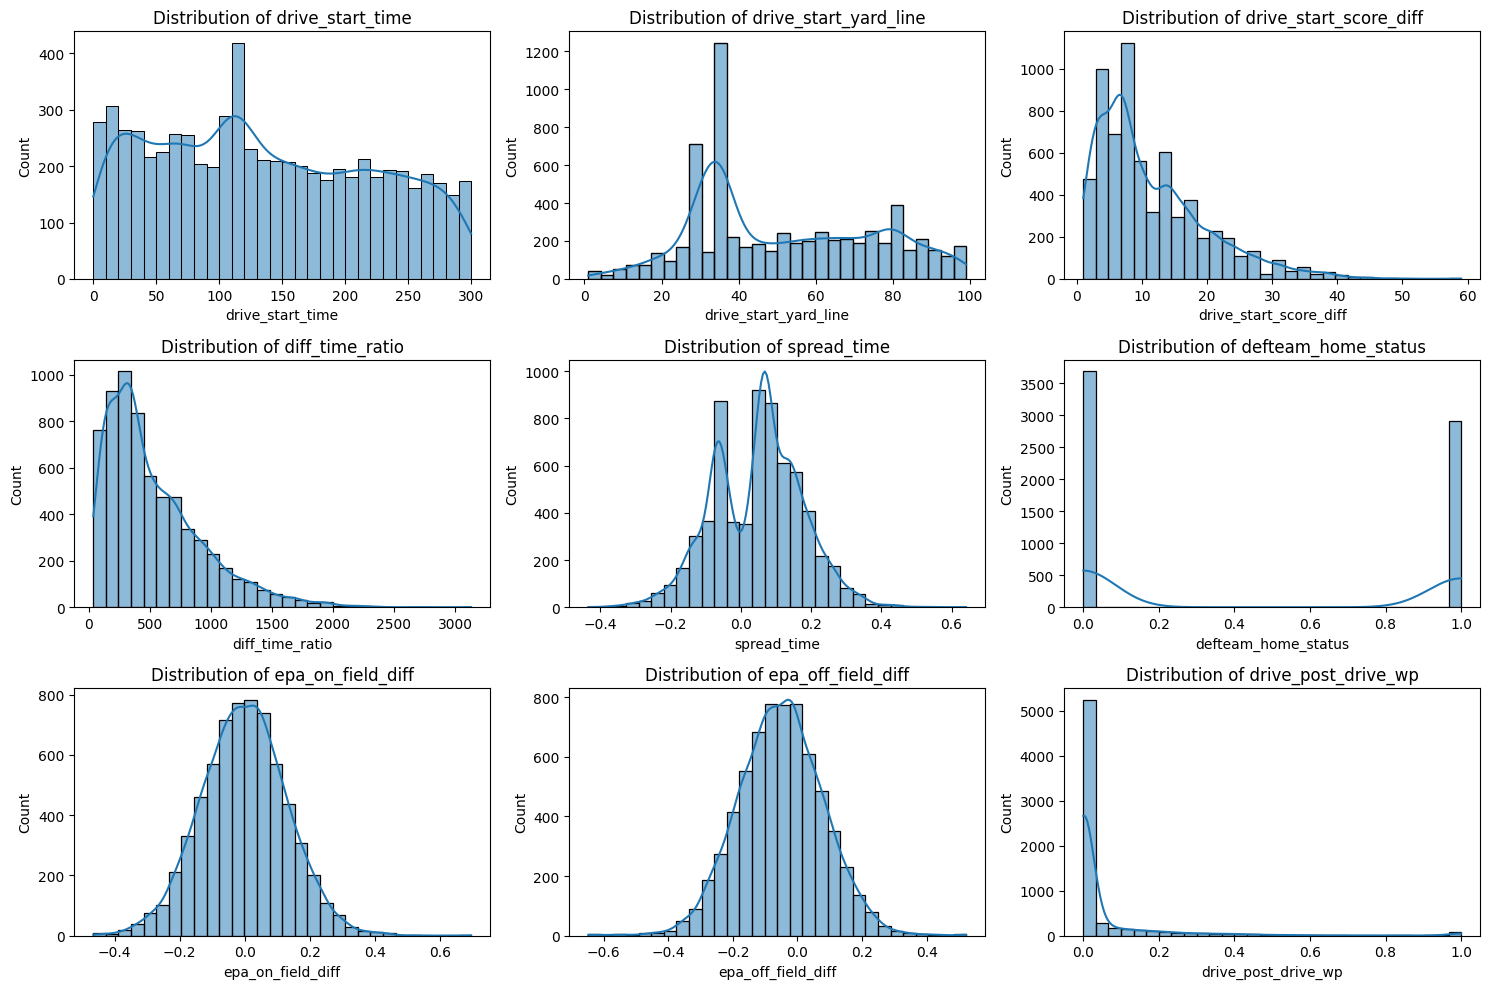

In [ ]:
#View Distribution of Key Variables (for scaling purposes)

import matplotlib.pyplot as plt
import seaborn as sns

df_to_plot = pbp_drive_5_min_down_all



# List of features to visualize
hist_features = [
    "drive_start_time",
    "drive_start_yard_line",
    "drive_start_score_diff",
    "diff_time_ratio",
    "spread_time",
    "defteam_home_status",
    "epa_on_field_diff",
    "epa_off_field_diff",
    "drive_post_drive_wp"
    # 'pos_offense_redzone_points_per_trip_weekly_roll',
    # 'pos_defense_redzone_points_per_trip_weekly_roll',
    # 'pos_offense_high_leverage_conv_rate_wk_weekly_roll',
    # 'pos_offense_qb_epa_per_play_wk_weekly_roll',
    # 'pos_offense_pass_rate_wk_weekly_roll'
]

# Set up the plot grid
plt.figure(figsize=(15, 10))
for i, feature in enumerate(hist_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_to_plot[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.tight_layout()

plt.show()


Epoch 1, Train Loss: 0.0231, Val Loss: 0.0169
Epoch 2, Train Loss: 0.0214, Val Loss: 0.0164
Epoch 3, Train Loss: 0.0205, Val Loss: 0.0163
Epoch 4, Train Loss: 0.0200, Val Loss: 0.0164
Epoch 5, Train Loss: 0.0209, Val Loss: 0.0162
Epoch 6, Train Loss: 0.0201, Val Loss: 0.0160
Epoch 7, Train Loss: 0.0200, Val Loss: 0.0160
Epoch 8, Train Loss: 0.0221, Val Loss: 0.0164
Epoch 9, Train Loss: 0.0224, Val Loss: 0.0163
Epoch 10, Train Loss: 0.0203, Val Loss: 0.0163
Epoch 11, Train Loss: 0.0208, Val Loss: 0.0163
Epoch 12, Train Loss: 0.0199, Val Loss: 0.0164
Epoch 13, Train Loss: 0.0198, Val Loss: 0.0161
Epoch 14, Train Loss: 0.0196, Val Loss: 0.0160
Epoch 15, Train Loss: 0.0204, Val Loss: 0.0161
Epoch 16, Train Loss: 0.0197, Val Loss: 0.0161
Epoch 17, Train Loss: 0.0214, Val Loss: 0.0166
Epoch 18, Train Loss: 0.0205, Val Loss: 0.0159
Epoch 19, Train Loss: 0.0195, Val Loss: 0.0159
Epoch 20, Train Loss: 0.0205, Val Loss: 0.0160
Epoch 21, Train Loss: 0.0196, Val Loss: 0.0160
Epoch 22, Train Loss: 

/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/4161724658.py:257: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_marginals = df_results.groupby("time_bucket")[[


<Figure size 1000x600 with 0 Axes>

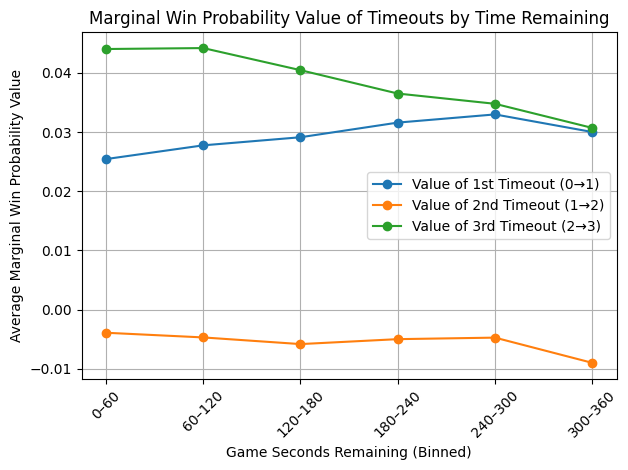

In [ ]:
#INDIVIDUAL DATASET TO TEST ON: MODEL CODE

# Step 0: Imports and Seed Setting
import pandas as pd
import numpy as np
import random
import torch
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

# set_seed(42)  # Ensures reproducibility

# Step #1: Preprocess Data
df = pbp_drive_5_min_down_all.copy()
df = df.copy()

# --- Scale drive_start_time (MinMax)
minmax_scaler_time = MinMaxScaler()
df["drive_start_time_scaled"] = minmax_scaler_time.fit_transform(df[["drive_start_time"]])

# --- Scale drive_start_yard_line (MinMax with separate scaler)
minmax_scaler_yl = MinMaxScaler()
df["drive_start_yard_line_scaled"] = minmax_scaler_yl.fit_transform(df[["drive_start_yard_line"]])

# --- Robust scale score_diff
robust_scaler_sd = RobustScaler()
df["score_diff_scaled"] = robust_scaler_sd.fit_transform(df[["drive_start_score_diff"]])

std_scaler_dtr = StandardScaler()
# --- Standard scale other features using separate scalers
df["spread_time_scaled"] = StandardScaler().fit_transform(df[["spread_time"]])
df["epa_on_field_diff_scaled"] = StandardScaler().fit_transform(df[["epa_on_field_diff"]])

# --- Transform + scale diff_time_ratio (log -> standard scale)

# DIFF_TIME_RATIO: FOR JUST TRAILING
df["diff_time_ratio_log"] = np.log1p(df["diff_time_ratio"])
df["diff_time_ratio_scaled"] = std_scaler_dtr.fit_transform(df[["diff_time_ratio_log"]])
# DIFF_TIME_RATIO: FOR ALL
# df["diff_time_ratio_scaled"] = StandardScaler().fit_transform(df[["diff_time_ratio"]])




# Final feature list
final_features = [
    'drive_start_time_scaled',
    'drive_start_yard_line_scaled',
    'diff_time_ratio_scaled',
    'spread_time_scaled',
    'score_diff_scaled',
    'defteam_home_status',
    'epa_on_field_diff_scaled'
]

# Build X, T, y
X = df[final_features]
T = df["drive_start_def_to"]
y = df["drive_post_drive_wp"]

X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
    X, T, y, test_size=0.2, random_state=42
)

# Step #2: PyTorch Dataset
from torch.utils.data import Dataset

class CrunchSeriesDataset(Dataset):
    def __init__(self, X, T, Y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.T = torch.tensor(T.to_numpy(), dtype=torch.long)
        self.Y = torch.tensor(Y.to_numpy(), dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.T[idx], self.Y[idx]

train_dataset = CrunchSeriesDataset(X_train, T_train, y_train)
test_dataset = CrunchSeriesDataset(X_test, T_test, y_test)

# Step #3: TARNet Model Definition
import torch.nn as nn

class TARNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, num_treatments=4, dropout=0.1):
        super(TARNet, self).__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout)]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout)]
        self.shared = nn.Sequential(*layers)

        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, 64),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(64, 1)
            ) for _ in range(num_treatments)
        ])

    def forward(self, x, t):
        rep = self.shared(x)
        out = torch.zeros((x.size(0), 1), device=x.device)
        for i in range(len(self.heads)):
            idx = (t == i)
            if idx.any():
                out[idx] = self.heads[i](rep[idx])
        return out

    def predict_all_treatments(self, x):
        rep = self.shared(x)
        return torch.cat([head(rep) for head in self.heads], dim=1)

# ✅ Model setup is ready — pick up from training (Step 4) in your original code.


#Step #4: Train the Model

from torch.utils.data import DataLoader
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=128)

# Initialize model
model = TARNet(input_dim=X.shape[1], hidden_dim=128, dropout=0.1)
model.to(device)

# Regularized optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

# --- Early stopping setup ---
best_val_loss = float('inf')
best_epoch = 0
epochs_no_improve = 0
early_stop_patience = 20     # more tolerant
min_delta = 0                # accept any improvement

train_losses = []
val_losses = []

# Training loop
for epoch in range(150):  # allow longer training with safety stop
    model.train()
    total_loss = 0

    for X_batch, T_batch, Y_batch in train_loader:
        X_batch, T_batch, Y_batch = X_batch.to(device), T_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch, T_batch)

        loss = loss_fn(output, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- VALIDATION ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, T_batch, Y_batch in val_loader:
            X_batch, T_batch, Y_batch = X_batch.to(device), T_batch.to(device), Y_batch.to(device)
            preds = model(X_batch, T_batch)
            loss = loss_fn(preds, Y_batch)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # --- EARLY STOPPING CHECK ---
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        best_epoch = epoch

        epochs_no_improve = 0
        # Optionally save best model state:
        # best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping triggered at epoch {epoch+1} (best val @ epoch {best_epoch+1})")
        break

#Step #4.5 -- Evaluate Mean Average Error

from sklearn.metrics import mean_absolute_error
model.eval()
preds = []
actuals = []

with torch.no_grad():
    for X_batch, T_batch, Y_batch in DataLoader(test_dataset, batch_size=128):
        X_batch, T_batch = X_batch.to(device), T_batch.to(device)
        preds_batch = model(X_batch, T_batch).cpu().numpy()
        preds.extend(preds_batch.flatten())
        actuals.extend(Y_batch.numpy().flatten())

mae = mean_absolute_error(actuals, preds)
print(f"Test MAE: {mae:.4f}")

#Step #5: Estimate Marginal Value of Timeout

model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)
    pred_wps = model.predict_all_treatments(X_test_tensor).cpu().numpy()

# WP with 0, 1, 2, 3 timeouts
wp_0, wp_1, wp_2, wp_3 = pred_wps[:, 0], pred_wps[:, 1], pred_wps[:, 2], pred_wps[:, 3]


# Example: Marginal value of 1st timeout (from 0 to 1)
marginal_value_timeout_1 = wp_1 - wp_0
marginal_value_timeout_2 = wp_2 - wp_1
marginal_value_timeout_3 = wp_3 - wp_2

# Analyze: average by time bucket
df_results = pd.DataFrame({
    "drive_start_time": X_test["drive_start_time_scaled"],
    "marginal_value_1": marginal_value_timeout_1,
    "marginal_value_2": marginal_value_timeout_2,
    "marginal_value_3": marginal_value_timeout_3
})

# Invert MinMax scaling to get back to game clock seconds
df_results["game_seconds_remaining"] = minmax_scaler_time.inverse_transform(
    df_results[["drive_start_time"]]
)

df_results["time_bucket"] = pd.cut(
    df_results["game_seconds_remaining"],
    bins=[0, 60, 120, 180, 240, 300, 360, 420, 480],
    right=False,
    labels=["0–60", "60–120", "120–180", "180–240", "240–300", "300–360", "360–420", "420–480"]
)


import matplotlib.pyplot as plt

# Group by time buckets
avg_marginals = df_results.groupby("time_bucket")[[
    "marginal_value_1", "marginal_value_2", "marginal_value_3"
]].mean()


# Plot
plt.figure(figsize=(10, 6))
avg_marginals.plot(kind="line", marker="o")
plt.title("Marginal Win Probability Value of Timeouts by Time Remaining")
plt.xlabel("Game Seconds Remaining (Binned)")
plt.ylabel("Average Marginal Win Probability Value")
plt.legend([
    "Value of 1st Timeout (0→1)",
    "Value of 2nd Timeout (1→2)",
    "Value of 3rd Timeout (2→3)"
])
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
#INDIVIDUAL DATASET TO TEST ON: CROSS VALIDATION

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

# ----------------------
# Data prep class
# ----------------------
class CrunchSeriesDataset(Dataset):
    def __init__(self, X, T, Y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.T = torch.tensor(T.to_numpy(), dtype=torch.long)
        self.Y = torch.tensor(Y.to_numpy(), dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.T[idx], self.Y[idx]

# ----------------------
# TARNet model
# ----------------------
class TARNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_treatments=4, dropout=0.2):
        super(TARNet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, 64),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(64, 1)
            ) for _ in range(num_treatments)
        ])

    def forward(self, x, t):
        rep = self.shared(x)
        out = torch.zeros((x.size(0), 1), device=x.device)
        for i in range(len(self.heads)):
            idx = (t == i)
            if idx.any():
                out[idx] = self.heads[i](rep[idx])
        return out

    def predict_all_treatments(self, x):
        rep = self.shared(x)
        return torch.cat([head(rep) for head in self.heads], dim=1)

# ----------------------
# K-Fold Training Logic
# ----------------------
def run_kfold(X, T, y, num_splits=10, repeats=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []

    for repeat in range(repeats):
        print(f"\n=== Repeat {repeat+1}/{repeats} ===")
        kf = KFold(n_splits=num_splits, shuffle=True, random_state=42 + repeat)

        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            print(f"\n--- Fold {fold+1}/{num_splits} ---")
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            T_train, T_val = T.iloc[train_idx], T.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            train_dataset = CrunchSeriesDataset(X_train, T_train, y_train)
            val_dataset = CrunchSeriesDataset(X_val, T_val, y_val)
            train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=128)

            model = TARNet(input_dim=X.shape[1]).to(device)
            optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
            loss_fn = nn.MSELoss()

            # Early stopping setup
            best_val_loss = float('inf')
            best_epoch = 0
            epochs_no_improve = 0
            early_stop_patience = 20
            min_delta = 0
            max_epochs = 150

            for epoch in range(max_epochs):
                model.train()
                total_loss = 0
                for X_batch, T_batch, Y_batch in train_loader:
                    X_batch, T_batch, Y_batch = X_batch.to(device), T_batch.to(device), Y_batch.to(device)
                    optimizer.zero_grad()
                    preds = model(X_batch, T_batch)
                    loss = loss_fn(preds, Y_batch)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()

                # Validation
                model.eval()
                val_loss = 0
                preds_list, actuals_list = [], []
                with torch.no_grad():
                    for X_batch, T_batch, Y_batch in val_loader:
                        X_batch, T_batch, Y_batch = X_batch.to(device), T_batch.to(device), Y_batch.to(device)
                        preds = model(X_batch, T_batch)
                        val_loss += loss_fn(preds, Y_batch).item()
                        preds_list.extend(preds.cpu().numpy().flatten())
                        actuals_list.extend(Y_batch.cpu().numpy().flatten())

                avg_val_loss = val_loss / len(val_loader)

                if avg_val_loss < best_val_loss - min_delta:
                    best_val_loss = avg_val_loss
                    best_mae = mean_absolute_error(actuals_list, preds_list)
                    best_mse = mean_squared_error(actuals_list, preds_list)
                    best_epoch = epoch
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= early_stop_patience:
                    print(f"⏹️ Early stop @ {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                    break

            results.append({
                'fold': fold + 1,
                'repeat': repeat + 1,
                'val_loss': best_val_loss,
                'mae': best_mae,
                'mse': best_mse,
                'best_epoch': best_epoch + 1
            })

    return pd.DataFrame(results)

# ----------------------
# Run Cross-Validation
# ----------------------
results_df = run_kfold(X, T, y, num_splits=10, repeats=5)

# Print summary
print("\n=== Cross-Validation Summary ===")
print(results_df.groupby("repeat")[["mae", "mse", "val_loss"]].mean())
print("\nOverall:")
print(f"Avg MAE: {results_df['mae'].mean():.4f} ± {results_df['mae'].std():.4f}")
print(f"Avg MSE: {results_df['mse'].mean():.4f} ± {results_df['mse'].std():.4f}")
print(f"Avg Best Epoch: {results_df['best_epoch'].mean():.1f}")



=== Repeat 1/5 ===

--- Fold 1/10 ---
⏹️ Early stop @ 57, Best Val Loss: 0.0107

--- Fold 2/10 ---
⏹️ Early stop @ 28, Best Val Loss: 0.0154

--- Fold 3/10 ---
⏹️ Early stop @ 35, Best Val Loss: 0.0216

--- Fold 4/10 ---
⏹️ Early stop @ 35, Best Val Loss: 0.0184

--- Fold 5/10 ---
⏹️ Early stop @ 31, Best Val Loss: 0.0206

--- Fold 6/10 ---
⏹️ Early stop @ 66, Best Val Loss: 0.0215

--- Fold 7/10 ---
⏹️ Early stop @ 25, Best Val Loss: 0.0137

--- Fold 8/10 ---
⏹️ Early stop @ 41, Best Val Loss: 0.0161

--- Fold 9/10 ---
⏹️ Early stop @ 38, Best Val Loss: 0.0148

--- Fold 10/10 ---
⏹️ Early stop @ 51, Best Val Loss: 0.0154

=== Repeat 2/5 ===

--- Fold 1/10 ---
⏹️ Early stop @ 40, Best Val Loss: 0.0151

--- Fold 2/10 ---
⏹️ Early stop @ 32, Best Val Loss: 0.0185

--- Fold 3/10 ---
⏹️ Early stop @ 22, Best Val Loss: 0.0119

--- Fold 4/10 ---
⏹️ Early stop @ 33, Best Val Loss: 0.0144

--- Fold 5/10 ---
⏹️ Early stop @ 44, Best Val Loss: 0.0181

--- Fold 6/10 ---
⏹️ Early stop @ 40, Best 

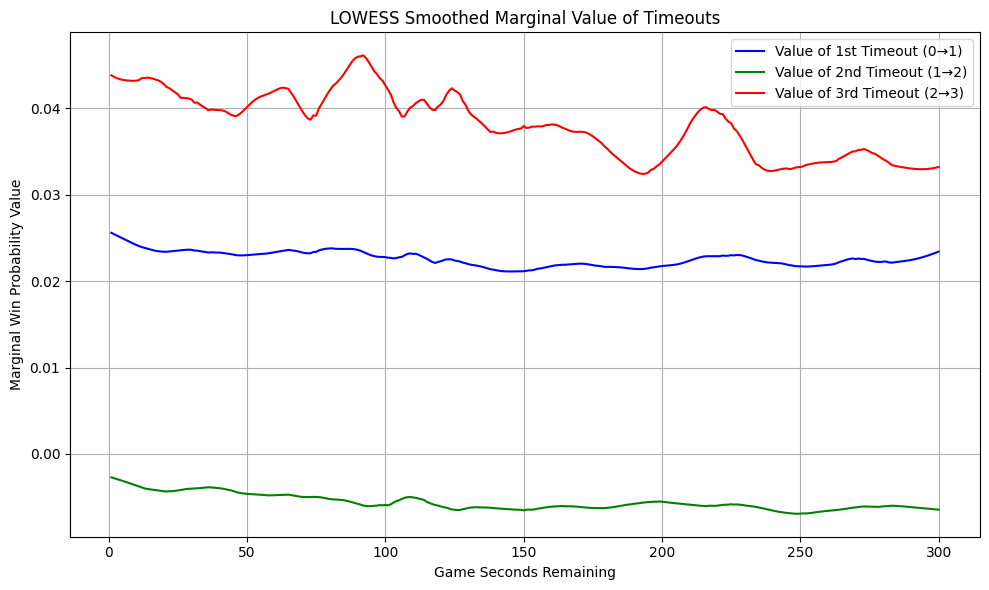

In [ ]:
#INDIVIDUAL DATASET TO TEST ON: LOWESS CURVES

import statsmodels.api as sm

# Invert scaling to get raw game seconds remaining
df_results["game_seconds_remaining"] = minmax_scaler_time.inverse_transform(
    df_results[["drive_start_time"]]
)

# Apply LOWESS smoothing
lowess_1 = sm.nonparametric.lowess(df_results["marginal_value_1"], df_results["game_seconds_remaining"], frac=0.1)
lowess_2 = sm.nonparametric.lowess(df_results["marginal_value_2"], df_results["game_seconds_remaining"], frac=0.1)
lowess_3 = sm.nonparametric.lowess(df_results["marginal_value_3"], df_results["game_seconds_remaining"], frac=0.1)

# Plot smoothed curves
plt.figure(figsize=(10, 6))
plt.plot(lowess_1[:, 0], lowess_1[:, 1], label="Value of 1st Timeout (0→1)", color="blue")
plt.plot(lowess_2[:, 0], lowess_2[:, 1], label="Value of 2nd Timeout (1→2)", color="green")
plt.plot(lowess_3[:, 0], lowess_3[:, 1], label="Value of 3rd Timeout (2→3)", color="red")

plt.title("LOWESS Smoothed Marginal Value of Timeouts")
plt.xlabel("Game Seconds Remaining")
plt.ylabel("Marginal Win Probability Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#For situations where dataset includes more than just one-score games

# import statsmodels.api as sm
# import matplotlib.pyplot as plt

# # --- Step 1: Invert Robust scaling to get raw score diffs
# # Assumes you already have robust_scaler_sd defined
# score_diff_scaled = X_test["score_diff_scaled"].values.reshape(-1, 1)
# score_diff_raw = robust_scaler_sd.inverse_transform(score_diff_scaled).flatten()

# # --- Step 2: Add raw values to df_results
# df_results["score_diff_raw"] = score_diff_raw

# # --- Step 3: Invert MinMax scaling for game time
# df_results["game_seconds_remaining"] = minmax_scaler_time.inverse_transform(
#     df_results[["drive_start_time"]]
# )

# # --- Step 4: Filter for 1-score games only
# df_lowess = df_results[(df_results["score_diff_raw"] > 0) & (df_results["score_diff_raw"] < 8)].copy()

# # --- Step 5: Apply LOWESS smoothing
# lowess_1 = sm.nonparametric.lowess(df_lowess["marginal_value_1"], df_lowess["game_seconds_remaining"], frac=0.1)
# lowess_2 = sm.nonparametric.lowess(df_lowess["marginal_value_2"], df_lowess["game_seconds_remaining"], frac=0.1)
# lowess_3 = sm.nonparametric.lowess(df_lowess["marginal_value_3"], df_lowess["game_seconds_remaining"], frac=0.1)

# # --- Step 6: Plot
# plt.figure(figsize=(10, 6))
# plt.plot(lowess_1[:, 0], lowess_1[:, 1], label="Value of 1 TO Left (0→1)", color="blue")
# plt.plot(lowess_2[:, 0], lowess_2[:, 1], label="Value of 2 TO Left (1→2)", color="green")
# plt.plot(lowess_3[:, 0], lowess_3[:, 1], label="Value of 3 TO Left (2→3)", color="red")

# plt.title("LOWESS Smoothed Marginal Value of Timeouts (1-Score Games Only)")
# plt.xlabel("Game Seconds Remaining")
# plt.ylabel("Marginal Win Probability Value")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
#FINAL MODEL: ENSEMBLE MODEL & LOWESS CURVES

# === STEP 0: Imports and Device Setup ===
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.metrics import mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === STEP 1: Preprocess Data ===
df = pbp_drive_5_min_down_all.copy()

# --- Fit scalers
minmax_scaler_time = MinMaxScaler()
df["drive_start_time_scaled"] = minmax_scaler_time.fit_transform(df[["drive_start_time"]])

minmax_scaler_yl = MinMaxScaler()
df["drive_start_yard_line_scaled"] = minmax_scaler_yl.fit_transform(df[["drive_start_yard_line"]])

robust_scaler_sd = RobustScaler()
df["score_diff_scaled"] = robust_scaler_sd.fit_transform(df[["drive_start_score_diff"]])

df["spread_time_scaled"] = StandardScaler().fit_transform(df[["spread_time"]])
df["epa_on_field_diff_scaled"] = StandardScaler().fit_transform(df[["epa_on_field_diff"]])
df["diff_time_ratio_log"] = np.log1p(df["diff_time_ratio"])
df["diff_time_ratio_scaled"] = StandardScaler().fit_transform(df[["diff_time_ratio_log"]])

final_features = [
    'drive_start_time_scaled',
    'drive_start_yard_line_scaled',
    'diff_time_ratio_scaled',
    'spread_time_scaled',
    'score_diff_scaled',
    'defteam_home_status',
    'epa_on_field_diff_scaled'
]

X = df[final_features]
T = df["drive_start_def_to"]
y = df["drive_post_drive_wp"]

# === STEP 2: Dataset Class ===
class CrunchSeriesDataset(Dataset):
    def __init__(self, X, T, Y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.T = torch.tensor(T.to_numpy(), dtype=torch.long)
        self.Y = torch.tensor(Y.to_numpy(), dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.T[idx], self.Y[idx]

# === STEP 3: TARNet ===
class TARNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, num_treatments=4, dropout=0.1):
        super(TARNet, self).__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout)]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout)]
        self.shared = nn.Sequential(*layers)
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, 64),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(64, 1)
            ) for _ in range(num_treatments)
        ])
    def forward(self, x, t):
        rep = self.shared(x)
        out = torch.zeros((x.size(0), 1), device=x.device)
        for i, head in enumerate(self.heads):
            idx = (t == i)
            if idx.any():
                out[idx] = head(rep[idx])
        return out
    def predict_all_treatments(self, x):
        rep = self.shared(x)
        return torch.cat([head(rep) for head in self.heads], dim=1)

# === STEP 4: Ensemble Training + LOWESS Averaging ===

NUM_RUNS = 100
LOWESS_FRAC = 0.1
BATCH_SIZE = 128
EPOCHS = 150
EARLY_STOPPING_PATIENCE = 20
MIN_DELTA = 0

lowess_all_1, lowess_all_2, lowess_all_3 = [], [], []
mae_all = []

for run in trange(NUM_RUNS, desc="Training TARNet Models"):

    # --- Resplit
    X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
        X, T, y, test_size=0.2, random_state=None
    )
    train_dataset = CrunchSeriesDataset(X_train, T_train, y_train)
    test_dataset = CrunchSeriesDataset(X_test, T_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # --- Model
    model = TARNet(input_dim=X.shape[1], hidden_dim=128).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    loss_fn = nn.MSELoss()

    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(EPOCHS):
        model.train()
        for X_batch, T_batch, Y_batch in train_loader:
            X_batch, T_batch, Y_batch = X_batch.to(device), T_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(X_batch, T_batch), Y_batch)
            loss.backward()
            optimizer.step()

        # Early stopping
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, T_batch, Y_batch in val_loader:
                X_batch, T_batch, Y_batch = X_batch.to(device), T_batch.to(device), Y_batch.to(device)
                val_loss += loss_fn(model(X_batch, T_batch), Y_batch).item()
        val_loss /= len(val_loader)

        if val_loss < best_val_loss - MIN_DELTA:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
                break

    # --- Predict on test
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)
        pred_wps = model.predict_all_treatments(X_test_tensor).cpu().numpy()

    wp_0, wp_1, wp_2, wp_3 = pred_wps[:, 0], pred_wps[:, 1], pred_wps[:, 2], pred_wps[:, 3]
    mv_1, mv_2, mv_3 = wp_1 - wp_0, wp_2 - wp_1, wp_3 - wp_2
    game_seconds = minmax_scaler_time.inverse_transform(X_test[["drive_start_time_scaled"]]).flatten()

    # --- Inverse score diff scaling
    raw_score_diffs = robust_scaler_sd.inverse_transform(X_test[["score_diff_scaled"]]).flatten()

    # --- Filter: only drives with 1-8 point differential
    mask = (raw_score_diffs >= 1) & (raw_score_diffs <= 8)
    mv_1, mv_2, mv_3 = mv_1[mask], mv_2[mask], mv_3[mask]
    filtered_game_seconds = game_seconds[mask]

    # --- LOWESS
    lowess_all_1.append(sm.nonparametric.lowess(mv_1, filtered_game_seconds, frac=LOWESS_FRAC, return_sorted=True))
    lowess_all_2.append(sm.nonparametric.lowess(mv_2, filtered_game_seconds, frac=LOWESS_FRAC, return_sorted=True))
    lowess_all_3.append(sm.nonparametric.lowess(mv_3, filtered_game_seconds, frac=LOWESS_FRAC, return_sorted=True))

    # --- MAE
    # --- MAE for subset
    actuals = y_test.to_numpy()[mask]
    preds_subset = wp_1[mask]  # Use predictions for 1 timeout where mask is true

    if len(actuals) > 0 and len(preds_subset) == len(actuals):
        mae = mean_absolute_error(actuals, preds_subset)
        mae_all.append(mae)



Training TARNet Models: 100%|█████████████████| 100/100 [08:18<00:00,  4.99s/it]


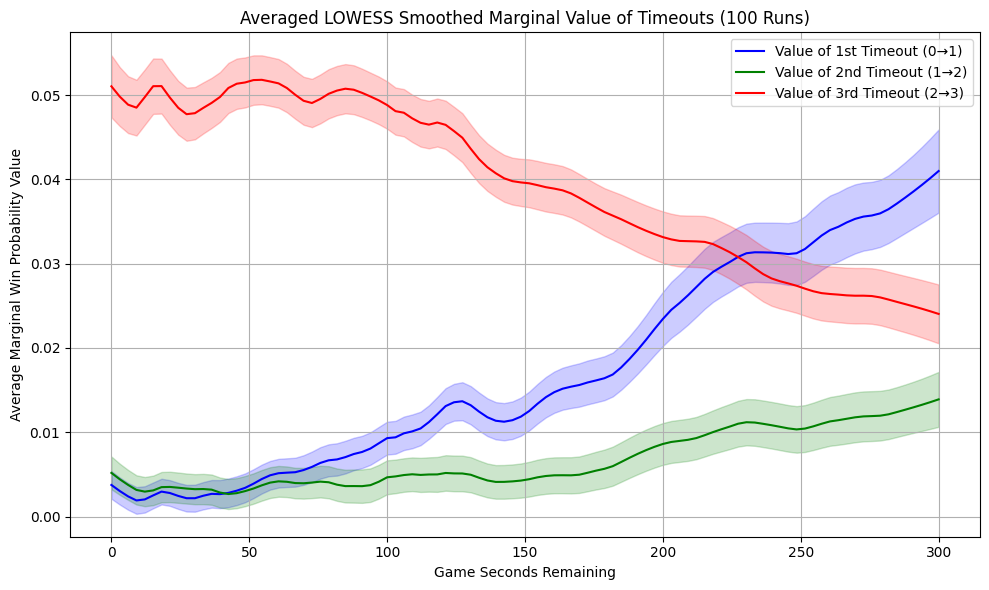


Ensemble MAE Summary (1–8 point differential only):
Mean MAE: 0.07689
Std Dev MAE: 0.00507


In [ ]:
#FINAL: AVERAGE LOWESS CURVES (ACROSS ALL 100 SIMULATIONS)

from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

def average_lowess(curves, num_points=100, z_score=1.96):
    common_x = np.linspace(0, 300, num=num_points)

    interpolated_ys = []
    for curve in curves:
        x_vals, y_vals = curve[:, 0], curve[:, 1]

        # Enforce uniqueness (required for interpolation)
        x_unique, idx_unique = np.unique(x_vals, return_index=True)
        y_unique = y_vals[idx_unique]

        f_interp = interp1d(x_unique, y_unique, bounds_error=False, fill_value="extrapolate")
        interpolated_ys.append(f_interp(common_x))

    y_stack = np.stack(interpolated_ys)
    mean_y = np.mean(y_stack, axis=0)
    std_y = np.std(y_stack, axis=0)
    n = y_stack.shape[0]

    # 95% Confidence Intervals
    ci_half_width = z_score * std_y / np.sqrt(n)
    lower_ci = mean_y - ci_half_width
    upper_ci = mean_y + ci_half_width

    return common_x, mean_y, lower_ci, upper_ci

# Compute curves
x1, y1, ci1_low, ci1_high = average_lowess(lowess_all_1)
x2, y2, ci2_low, ci2_high = average_lowess(lowess_all_2)
x3, y3, ci3_low, ci3_high = average_lowess(lowess_all_3)

# Plot
plt.figure(figsize=(10, 6))

plt.plot(x1, y1, label="Value of 1st Timeout (0→1)", color="blue")
plt.fill_between(x1, ci1_low, ci1_high, color="blue", alpha=0.2)

plt.plot(x2, y2, label="Value of 2nd Timeout (1→2)", color="green")
plt.fill_between(x2, ci2_low, ci2_high, color="green", alpha=0.2)

plt.plot(x3, y3, label="Value of 3rd Timeout (2→3)", color="red")
plt.fill_between(x3, ci3_low, ci3_high, color="red", alpha=0.2)

plt.title("Averaged LOWESS Smoothed Marginal Value of Timeouts (100 Runs)")
plt.xlabel("Game Seconds Remaining")
plt.ylabel("Average Marginal Win Probability Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print MAE Summary ===
mae_array = np.array(mae_all)
print(f"\nEnsemble MAE Summary (1–8 point differential only):")
print(f"Mean MAE: {mae_array.mean():.5f}")
print(f"Std Dev MAE: {mae_array.std():.5f}")


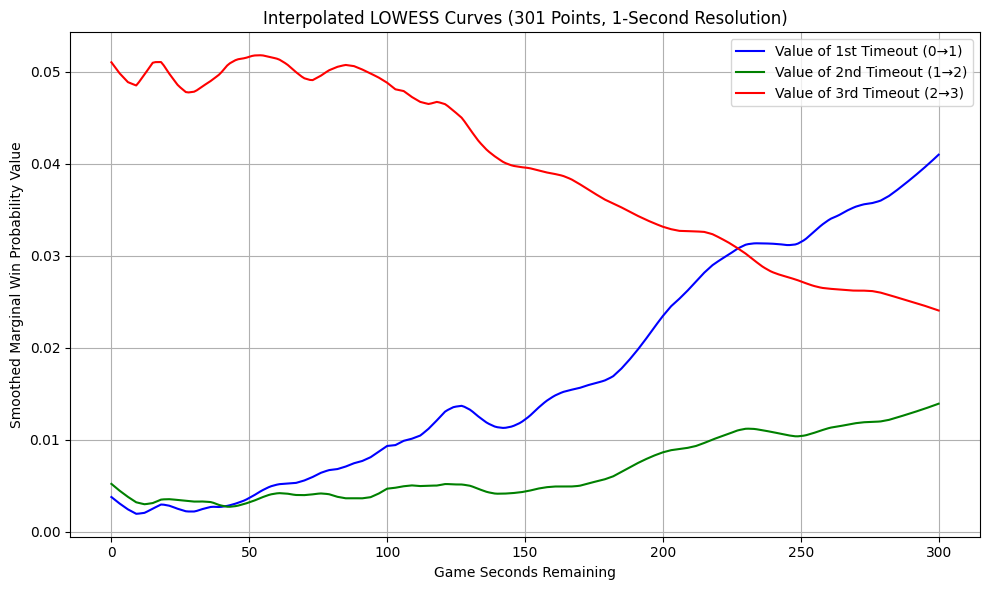

In [ ]:
# Interpolation of LOWESS Curves to full 301-point grid (to match second by second frame of game-seconds-remaining distributions for later combining)

from scipy.interpolate import interp1d

interp1 = interp1d(x1, y1, bounds_error=False, fill_value="extrapolate")
interp2 = interp1d(x2, y2, bounds_error=False, fill_value="extrapolate")
interp3 = interp1d(x3, y3, bounds_error=False, fill_value="extrapolate")

seconds_0_300 = np.arange(301)

lowess_curve_1 = interp1(seconds_0_300)
lowess_curve_2 = interp2(seconds_0_300)
lowess_curve_3 = interp3(seconds_0_300)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(seconds_0_300, lowess_curve_1, label="Value of 1st Timeout (0→1)", color="blue")
plt.plot(seconds_0_300, lowess_curve_2, label="Value of 2nd Timeout (1→2)", color="green")
plt.plot(seconds_0_300, lowess_curve_3, label="Value of 3rd Timeout (2→3)", color="red")

plt.title("Interpolated LOWESS Curves (301 Points, 1-Second Resolution)")
plt.xlabel("Game Seconds Remaining")
plt.ylabel("Smoothed Marginal Win Probability Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# *** --------------------------------------------- ***

In [ ]:
# ------ GAME SECONDS REMAINING MODELING ----------

In [ ]:
# *** --------------------------------------------- ***


In [ ]:
# Assign the right "stop drive" to the right play
# Basically create a column for each play that contains the start time of the next time the team on offense will have to play
#  defense in a late game stop scenario (be on defense down by 1 score, with <= 5 min left in the game)
# Done this way to circumvent merge asof, which we were having issues with


drives = pbp_drive_5_min_down_1_score.copy()

drives['def_stop_drive_number'] = (
    drives.groupby(['game_id', 'defteam'])
    .cumcount() + 1
)


stop1 = drives[drives['def_stop_drive_number'] == 1].copy()
stop2 = drives[drives['def_stop_drive_number'] == 2].copy()
stop3 = drives[drives['def_stop_drive_number'] == 3].copy()

stop1 = stop1.rename(columns={'drive_start_time': 'first_drive_stop_start_time'})
stop2 = stop2.rename(columns={'drive_start_time': 'second_drive_stop_start_time'})
stop3 = stop3.rename(columns={'drive_start_time': 'third_drive_stop_start_time'})

plays = pbp_main.copy()

plays = plays.merge(stop1[['game_id', 'defteam', 'first_drive_stop_start_time']],
                    left_on=['game_id', 'posteam'],
                    right_on=['game_id', 'defteam'],
                    how='left')


plays = plays.rename(columns={'defteam_x':'defteam'})
plays.drop(columns=['defteam_y'], inplace=True)


plays = plays.merge(stop2[['game_id', 'defteam', 'second_drive_stop_start_time']],
                    left_on=['game_id', 'posteam'],
                    right_on=['game_id', 'defteam'],
                    how='left')

plays = plays.rename(columns={'defteam_x':'defteam'})
plays.drop(columns=['defteam_y'], inplace=True)

plays = plays.merge(stop3[['game_id', 'defteam', 'third_drive_stop_start_time']],
                    left_on=['game_id', 'posteam'],
                    right_on=['game_id', 'defteam'],
                    how='left')

plays = plays.rename(columns={'defteam_x':'defteam'})
plays.drop(columns=['defteam_y'], inplace=True)

plays['future_drive_start_time'] = np.select(

    #Conditions
    [
        (plays['game_seconds_remaining'] >= plays['first_drive_stop_start_time']),
        (plays['game_seconds_remaining'] >= plays['second_drive_stop_start_time']),
        (plays['game_seconds_remaining'] > plays['third_drive_stop_start_time'])
    ],

    #Choices
    [
        (plays['first_drive_stop_start_time']),
        (plays['second_drive_stop_start_time']),
        (plays['third_drive_stop_start_time'])
    ],

    default = np.nan

    )

plays.drop(columns=['first_drive_stop_start_time','second_drive_stop_start_time','third_drive_stop_start_time'], inplace=True)

pbp_main = pbp_main.merge(plays[['game_id','play_id','future_drive_start_time']], on = ['game_id', 'play_id'], how = 'left')

In [ ]:
#Create the column indicating if a team will later have a defensive stop

pbp_main['team_will_later_have_a_def_stop'] = np.where(pbp_main['future_drive_start_time'] >= 0, 1, 0)

In [ ]:
#Add additional columns to run the survival model (Duration, Event, Entry Time)

pbp_main['duration'] = np.where(
        pbp_main['future_drive_start_time'].isnull(), pbp_main['game_seconds_remaining'],
        pbp_main['game_seconds_remaining'] - pbp_main['future_drive_start_time'])

pbp_main['relative_duration'] = np.where(
        pbp_main['future_drive_start_time'].isnull(), 300,
        300 - pbp_main['future_drive_start_time'])

pbp_main['relative_duration'] += 1e-6

pbp_main['event'] = np.where(pbp_main['future_drive_start_time'].isnull(), 0, 1)

pbp_main['entry_time'] = (300 - pbp_main['game_seconds_remaining']).clip(lower=0)

In [ ]:
# Create New Data Frames (e.g. PBP Second Half, PBP Crunch Plays)
#  Created a few to use for different purposes throughout the rest of the project

pbp_crunch_plays = pbp_main.query('event == 1')
pbp_crunch_plays_2 = pbp_crunch_plays.query('qtr == 3 | qtr == 4')
pbp_crunch_plays_3 = pbp_crunch_plays_2.query('game_seconds_remaining < 600')
# pbp_crunch_plays_4 = pbp_crunch_plays.query('qtr == 4')
# pbp_crunch_plays_5 = pbp_crunch_plays.query('game_seconds_remaining <= 1800 & game_seconds_remaining > 1350')
pbp_crunch_plays_6 = pbp_crunch_plays_2.query('game_seconds_remaining > 600')

#Create dataframe of 2nd half plays only

pbp_second_half = pbp_main.query('qtr == 3 | qtr == 4')


In [ ]:
# Create histograms / distributions for all plays before 10 min left in the game

#  Essentially, the model was only reliable in predicting the "start time of the possession team's next late game stop drive"
#   for plays that started with 10 minutes or less remaining.  When I started to go out further than that, performance degraded considerably.
#    Therefore, I decided to create ~100 distributions, based on game situation (time remaining, current score, yardline),
#     to say "for all similar plays, what was the 'probability distribution of late game start times (from 0 - 300 sec).'"
#      All plays in the same bucket have the same distribution, which will be multipled later on by the TO Marginal Value
#       LOWESS Curves to get the marginal value of each TO, for each play.

import pandas as pd
import numpy as np

# --- Step 1: Prepare your histogram bins ---
bins = np.arange(0, 301)  # 0–300 seconds (inclusive)

# --- Step 2: Group by the three bucketing columns ---
grouped = (
    pbp_crunch_plays_6
    .dropna(subset=['relative_duration'])  # ensure no NaNs in target
    .groupby(['second_half_time_bucket', 'second_half_play_score_bucket', 'second_half_play_ydline_bucket'])
)

# --- Step 3: Build the distribution table ---
dist_rows = []

for group_keys, group_df in grouped:
    durations = group_df['relative_duration'].clip(0, 300).astype(int)
    counts = np.bincount(durations, minlength=301)[:301]
    probs = counts / counts.sum()  # normalize to get PDF

    dist_rows.append({
        'second_half_time_bucket': group_keys[0],
        'second_half_play_score_bucket': group_keys[1],
        'second_half_play_ydline_bucket': group_keys[2],
        'duration_pdf_hist': probs.tolist()  # <-- key change here
    })

# --- Step 4: Convert to dataframe ---
duration_distributions_df = pd.DataFrame(dist_rows)





/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/2885605305.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['second_half_time_bucket', 'second_half_play_score_bucket', 'second_half_play_ydline_bucket'])


In [ ]:
#Merge distributions back to main table

#change to pbp_main later
a = pbp_second_half.copy()
a = a.merge(duration_distributions_df, on = ['second_half_time_bucket', 'second_half_play_score_bucket', 'second_half_play_ydline_bucket'], how = 'left')

KeyError: 'play_count'

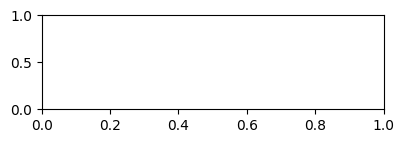

In [ ]:
#View Distribution of Key Variables (for scaling purposes)

# List of features to visualize
gsr_features = [
    # 'relative_duration',
    # 'event',
    # 'entry_time',
    # 'down',
    # 'game_seconds_remaining',
    # 'score_differential',
    # 'yardline_100',
    # 'ydstogo',
    # 'spread_line',
    # 'defteam_home_status',
    # 'diff_time_ratio',
    'play_count',
    'distance_to_crunch_time',
]

# Set up the plot grid
plt.figure(figsize=(15, 10))
for i, feature in enumerate(gsr_features, 1):
    plt.subplot(7, 3, i)
    sns.histplot(pbp_crunch_plays_2[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.tight_layout()

plt.show()

# minmax_scaler_time = MinMaxScaler()
# df["drive_start_time_scaled"] = minmax_scaler_time.fit_transform(df[["drive_start_time"]])

# minmax_scaler_yl = MinMaxScaler()
# df["drive_start_yard_line_scaled"] = minmax_scaler_yl.fit_transform(df[["drive_start_yard_line"]])

# robust_scaler_sd = RobustScaler()
# df["score_diff_scaled"] = robust_scaler_sd.fit_transform(df[["drive_start_score_diff"]])

# df["spread_time_scaled"] = StandardScaler().fit_transform(df[["spread_time"]])
# df["epa_on_field_diff_scaled"] = StandardScaler().fit_transform(df[["epa_on_field_diff"]])
# df["diff_time_ratio_log"] = np.log1p(df["diff_time_ratio"])
# df["diff_time_ratio_scaled"] = StandardScaler().fit_transform(df[["diff_time_ratio_log"]])



In [ ]:
#GSR MODEL RUN (season x season)

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn_pandas import DataFrameMapper
from pycox.models import LogisticHazard
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
from pycox.evaluation import EvalSurv
import torchtuples as tt
import pycox.evaluation.ipcw as ipcw

# ========== 0. PATCH pycox for Brier Score ==========
ipcw.scipy.integrate.simps = np.trapz

# ========== 1. LOAD & CLEAN DATA ==========
df = pbp_crunch_plays_3.copy()
df = df.dropna(subset=[
    'relative_duration',
    'event',
    'entry_time',
    'down',
    'game_seconds_remaining',
    'score_differential',
    'diff_time_ratio',
    'yardline_100',
    'ydstogo',
    # 'spread_time',
    'defteam_home_status',
    'epa_on_field_diff',
    'epa_off_field_diff',
    'log_play_count',
    'goal_to_go',
    # 'distance_to_crunch_time',
    # 'second_half_time_bucket'
    # 'points_per_drive',
    'pos_offense_yards_per_play_pbp_play_by_play_roll',
    'def_offense_yards_per_play_pbp_play_by_play_roll',
    'pos_offense_first_down_rate_pbp_play_by_play_roll',
    'def_offense_first_down_rate_pbp_play_by_play_roll',
    'pos_offense_epa_per_play_pbp_play_by_play_roll',
    'def_offense_epa_per_play_pbp_play_by_play_roll',


])

# ========== 2. FEATURE ENGINEERING ==========
# One-hot encode 'down'
down_dummies = pd.get_dummies(df['down'], prefix='down', drop_first=True)

# One-hot encode timeouts
posteam_timeout_dummies = pd.get_dummies(df['posteam_timeouts_remaining'], prefix='posteam_to', drop_first=True)
defteam_timeout_dummies = pd.get_dummies(df['defteam_timeouts_remaining'], prefix='defteam_to', drop_first=True)
# time_bucket_dummies = pd.get_dummies(df['second_half_time_bucket'], prefix='time_bucket', drop_first=True)

# Drop original columns
df = df.drop(columns=['down', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining'])

# Concatenate all dummy variables
df = pd.concat([df, down_dummies, posteam_timeout_dummies, defteam_timeout_dummies], axis=1)


# Feature scaling
feature_cols = [
    'yardline_100',
    'game_seconds_remaining',
    'ydstogo',
    'score_differential',
    'spread_time',
    'diff_time_ratio',
    'defteam_home_status',
    'goal_to_go',
    # 'pos_offense_first_down_rate_pbp_play_by_play_roll',
    # 'def_offense_first_down_rate_pbp_play_by_play_roll',
    # 'pos_offense_epa_per_play_pbp_play_by_play_roll',
    # 'def_offense_epa_per_play_pbp_play_by_play_roll',
    # 'pos_offense_yards_per_play_pbp_play_by_play_roll',
    # 'def_offense_yards_per_play_pbp_play_by_play_roll',
    # 'def_defense_rush_success_rate_pbp_play_by_play_roll',
    # 'spread_time',
    # 'epa_on_field_diff',
    # 'epa_off_field_diff',
    # 'posteam_timeouts_remaining',
    # 'defteam_timeouts_remaining',
    # 'log_play_count',
    # 'distance_to_crunch_time'
    # 'points_per_drive'
] + list(down_dummies.columns) + list(posteam_timeout_dummies.columns) + list(defteam_timeout_dummies.columns)
mapper = DataFrameMapper([
    (['yardline_100'], MinMaxScaler()),
    (['game_seconds_remaining'], MinMaxScaler()),
    (['ydstogo'], MinMaxScaler()),
    (['score_differential'], RobustScaler()),
    # (['spread_time'], RobustScaler()),
    (['diff_time_ratio'], RobustScaler()),
    # (['points_per_drive'], RobustScaler()),
    # (['log_play_count'], StandardScaler()),
    # (['epa_on_field_diff'], StandardScaler()),
    # (['distance_to_crunch_time'], MinMaxScaler()),
    # (['defteam_home_status'], None),
    (['goal_to_go'], None),
    # (['pos_offense_yards_per_play_pbp_play_by_play_roll'], StandardScaler()),
    # (['def_offense_yards_per_play_pbp_play_by_play_roll'], StandardScaler()),
    # (['pos_offense_epa_per_play_pbp_play_by_play_roll'], StandardScaler()),
    # (['pos_defense_epa_per_play_pbp_play_by_play_roll'], StandardScaler()),
    (['pos_offense_first_down_rate_pbp_play_by_play_roll'], StandardScaler()),
    (['def_offense_first_down_rate_pbp_play_by_play_roll'], StandardScaler()),
    *[([col], None) for col in down_dummies.columns],
    # *[([col], None) for col in posteam_timeout_dummies.columns],
    # *[([col], None) for col in defteam_timeout_dummies.columns],

], df_out=True)

X = mapper.fit_transform(df).astype('float32').to_numpy()

# ========== 3. LABEL SETUP ==========
durations = df['relative_duration'].clip(lower=1).values
events = df['event'].astype(int).values

# Discretize durations (60 = 5s bins for 0–300s)
labtrans = LabTransDiscreteTime(300)
y = labtrans.fit_transform(durations, events)
duration_index = labtrans.cuts
y_idx, y_event = y

# ========== 4. TRAIN / TEST SPLIT (LAST 5 SEASONS HELD OUT) ==========
assert 'season' in df.columns, "Your DataFrame must include a 'season' column."

# Sort seasons chronologically
unique_seasons = sorted(df['season'].unique())
test_seasons = unique_seasons[-5:]  # Last 5 seasons
train_seasons = [s for s in unique_seasons if s not in test_seasons]

# Split the data
df_train = df[df['season'].isin(train_seasons)].copy()
df_test = df[df['season'].isin(test_seasons)].copy()

# Transform using the mapper (refit on train only)
X_train = mapper.fit_transform(df_train).astype('float32').to_numpy()
X_test = mapper.transform(df_test).astype('float32').to_numpy()

# Label setup
dur_train = df_train['relative_duration'].clip(lower=1).values
evt_train = df_train['event'].astype(int).values
dur_test = df_test['relative_duration'].clip(lower=1).values
evt_test = df_test['event'].astype(int).values

# Discretize
y_train = labtrans.transform(dur_train, evt_train)
y_test = labtrans.transform(dur_test, evt_test)
y_idx_train, y_event_train = y_train
y_idx_test, y_event_test = y_test

# ========== 5. MODEL SETUP ==========
net = tt.practical.MLPVanilla(
    in_features=X_train.shape[1],
    num_nodes=[64, 64, 32],
    out_features=labtrans.out_features,
    activation=torch.nn.ReLU,
    dropout=0.2
)

model = LogisticHazard(
    net,
    optimizer=tt.optim.Adam,
    duration_index=duration_index,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
model.optimizer.set_lr(0.01)

# ========== 6. FIT ==========
model.fit(
    X_train,
    (y_idx_train, y_event_train),
    batch_size=256,
    epochs=150,
    callbacks=[tt.callbacks.EarlyStopping(patience=12)],
    val_data=(X_test, (y_idx_test, y_event_test)),
    verbose=True
)


# ========== 7. EVALUATION ==========
surv = model.predict_surv_df(X_test)
ev = EvalSurv(surv, dur_test, evt_test, censor_surv='km')

c_index = ev.concordance_td()
ibs = ev.integrated_brier_score(duration_index)

print(f"\n=== Final Model Performance ===")
print(f"C-index: {c_index:.4f}")
print(f"Integrated Brier Score: {ibs:.4f}")

print("surv.shape:", surv.shape)          # (60, n)
print("dur_test.shape:", dur_test.shape)  # (n,)
print("evt_test.shape:", evt_test.shape)  # (n,)


0:	[0s / 0s],		train_loss: 34.1875,	val_loss: 5.5723
1:	[0s / 0s],		train_loss: 5.4945,	val_loss: 5.5442
2:	[0s / 0s],		train_loss: 5.3678,	val_loss: 5.5364
3:	[0s / 0s],		train_loss: 5.2917,	val_loss: 5.5415
4:	[0s / 0s],		train_loss: 5.2361,	val_loss: 5.5529
5:	[0s / 1s],		train_loss: 5.1823,	val_loss: 5.5834
6:	[0s / 1s],		train_loss: 5.1317,	val_loss: 5.6003
7:	[0s / 1s],		train_loss: 5.0936,	val_loss: 5.6740
8:	[0s / 1s],		train_loss: 5.0616,	val_loss: 5.6924
9:	[0s / 1s],		train_loss: 5.0285,	val_loss: 5.7228
10:	[0s / 1s],		train_loss: 5.0019,	val_loss: 5.7638
11:	[0s / 2s],		train_loss: 4.9680,	val_loss: 5.8124
12:	[0s / 2s],		train_loss: 4.9370,	val_loss: 5.8489
13:	[0s / 2s],		train_loss: 4.9187,	val_loss: 5.9260
14:	[0s / 2s],		train_loss: 4.9136,	val_loss: 5.9307


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.



=== Final Model Performance ===
C-index: 0.7080
Integrated Brier Score: 0.1220
surv.shape: (300, 7673)
dur_test.shape: (7673,)
evt_test.shape: (7673,)


In [ ]:
#Season by Season Cross Validation

unique_seasons = sorted(df['year'].unique())
cindex_scores, ibs_scores = [], []

for i, season in enumerate(unique_seasons):
    print(f"\n=== Season {season} (Fold {i+1}/{len(unique_seasons)}) ===")

    # Split train/test
    df_train = df[df['year'] != season]
    df_test  = df[df['year'] == season]

    # Fit mapper on training data only
    mapper = DataFrameMapper([
        (['yardline_100'], MinMaxScaler()),
        (['game_seconds_remaining'], MinMaxScaler()),
        (['ydstogo'], MinMaxScaler()),
        (['score_differential'], RobustScaler()),
        # (['pos_offense_redzone_points_per_trip_weekly_roll'], StandardScaler()),
        # (['def_offense_redzone_points_per_trip_weekly_roll'], StandardScaler()),
        # (['pos_defense_redzone_points_per_trip_weekly_roll'], StandardScaler()),
        # (['def_defense_redzone_points_per_trip_weekly_roll'], StandardScaler()),
        # (['pos_offense_first_down_rate_wk_weekly_roll'], StandardScaler()),
        # (['def_offense_first_down_rate_wk_weekly_roll'], StandardScaler()),
        # (['pos_defense_first_down_rate_wk_weekly_roll'], StandardScaler()),
        # (['def_defense_first_down_rate_wk_weekly_roll'], StandardScaler()),
        # (['pos_offense_qb_epa_per_play_wk_weekly_roll'], StandardScaler()),
        # (['def_offense_qb_epa_per_play_wk_weekly_roll'], StandardScaler()),
        # (['pos_offense_pass_rate_wk_weekly_roll'], StandardScaler()),
        # (['def_offense_pass_rate_wk_weekly_roll'], StandardScaler()),
        # (['pos_offense_high_leverage_conv_rate_wk_weekly_roll'], StandardScaler()),
        # (['def_offense_high_leverage_conv_rate_wk_weekly_roll'], StandardScaler()),
        # (['pos_defense_high_leverage_conv_rate_wk_weekly_roll'], StandardScaler()),
        # (['def_defense_high_leverage_conv_rate_wk_weekly_roll'], StandardScaler()),
        # (['pos_offense_success_rate_wk_weekly_roll'], StandardScaler()),
        # (['def_offense_success_rate_wk_weekly_roll'], StandardScaler()),
        # (['pos_defense_success_rate_wk_weekly_roll'], StandardScaler()),
        # (['def_defense_success_rate_wk_weekly_roll'], StandardScaler()),
        # (['pos_offense_yards_per_play_wk_weekly_roll'], StandardScaler()),
        # (['def_offense_yards_per_play_wk_weekly_roll'], StandardScaler()),
        # (['epa_on_field_diff'], StandardScaler()),
        # (['epa_off_field_diff'], StandardScaler()),
        # (['pos_offense_turnover_rate_wk_weekly_roll'], RobustScaler()),
        # (['def_offense_turnover_rate_wk_weekly_roll'], RobustScaler()),
        # (['pos_defense_turnover_rate_wk_weekly_roll'], RobustScaler()),
        # (['def_defense_turnover_rate_wk_weekly_roll'], RobustScaler()),
        # (['pos_offense_off_penalty_rate_wk_weekly_roll'], RobustScaler()),
        # (['def_offense_off_penalty_rate_wk_weekly_roll'], RobustScaler()),
        # (['pos_offense_pace_of_play_wk_weekly_roll'], RobustScaler()),
        # (['def_offense_pace_of_play_wk_weekly_roll'], RobustScaler()),
        # (['pos_offense_chaos_rate_wk_weekly_roll'], RobustScaler()),
        # (['pos_defense_chaos_rate_wk_weekly_roll'], RobustScaler()),
        # (['def_offense_chaos_rate_wk_weekly_roll'], RobustScaler()),
        # (['def_defense_chaos_rate_wk_weekly_roll'], RobustScaler()),
        # (['pos_offense_explosive_rate_wk_weekly_roll'], RobustScaler()),
        # (['pos_defense_explosive_rate_wk_weekly_roll'], RobustScaler()),
        (['diff_time_ratio'], RobustScaler()),
        # (['points_per_drive'], RobustScaler()),
        (['defteam_home_status'], None),
        *[([col], None) for col in down_dummies.columns]
    ], df_out=True)

    X_train = mapper.fit_transform(df_train).astype('float32').to_numpy()
    X_test  = mapper.transform(df_test).astype('float32').to_numpy()

    # Labels
    durations_train = df_train['relative_duration'].clip(lower=1).values
    events_train = df_train['event'].astype(int).values
    durations_test = df_test['relative_duration'].clip(lower=1).values
    events_test = df_test['event'].astype(int).values

    y_train = labtrans.transform(durations_train, events_train)
    y_test = labtrans.transform(durations_test, events_test)
    y_idx_train, y_event_train = y_train
    y_idx_test, y_event_test = y_test

    # Model
    net = tt.practical.MLPVanilla(
        in_features=X_train.shape[1],
        num_nodes=[64, 64, 32],
        out_features=labtrans.out_features,
        activation=torch.nn.ReLU,
        dropout=0.2
    )

    model = LogisticHazard(
        net,
        optimizer=tt.optim.Adam,
        duration_index=duration_index,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )
    model.optimizer.set_lr(0.01)

    model.fit(
        X_train,
        (y_idx_train, y_event_train),
        batch_size=256,
        epochs=150,
        callbacks=[tt.callbacks.EarlyStopping(patience=12)],
        val_data=(X_test, (y_idx_test, y_event_test)),
        verbose=False
    )

    surv = model.predict_surv_df(X_test)
    ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

    c_index = ev.concordance_td()
    ibs = ev.integrated_brier_score(duration_index)

    cindex_scores.append(c_index)
    ibs_scores.append(ibs)

    print(f"Season {season} — C-index: {c_index:.4f}, IBS: {ibs:.4f}")

# Summary
print("\n=== Leave-One-Season-Out Summary ===")
print(f"Average C-index: {np.mean(cindex_scores):.4f} ± {np.std(cindex_scores):.4f}")
print(f"Average IBS:     {np.mean(ibs_scores):.4f} ± {np.std(ibs_scores):.4f}")



=== Season 2002 (Fold 1/23) ===
Season 2002 — C-index: 0.7477, IBS: 0.1100

=== Season 2003 (Fold 2/23) ===
Season 2003 — C-index: 0.7245, IBS: 0.1114

=== Season 2004 (Fold 3/23) ===
Season 2004 — C-index: 0.7486, IBS: 0.1109

=== Season 2005 (Fold 4/23) ===
Season 2005 — C-index: 0.7342, IBS: 0.1030

=== Season 2006 (Fold 5/23) ===
Season 2006 — C-index: 0.7549, IBS: 0.1125

=== Season 2007 (Fold 6/23) ===
Season 2007 — C-index: 0.7439, IBS: 0.1058

=== Season 2008 (Fold 7/23) ===
Season 2008 — C-index: 0.7616, IBS: 0.1081

=== Season 2009 (Fold 8/23) ===
Season 2009 — C-index: 0.7377, IBS: 0.1104

=== Season 2010 (Fold 9/23) ===
Season 2010 — C-index: 0.7520, IBS: 0.1081

=== Season 2011 (Fold 10/23) ===
Season 2011 — C-index: 0.7543, IBS: 0.1107

=== Season 2012 (Fold 11/23) ===
Season 2012 — C-index: 0.7542, IBS: 0.1086

=== Season 2013 (Fold 12/23) ===
Season 2013 — C-index: 0.7440, IBS: 0.1088

=== Season 2014 (Fold 13/23) ===
Season 2014 — C-index: 0.7521, IBS: 0.1092

=== Sea

In [ ]:
#Final Version: GSR MODEL

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn_pandas import DataFrameMapper
from pycox.models import LogisticHazard
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
from pycox.evaluation import EvalSurv
import torchtuples as tt
import pycox.evaluation.ipcw as ipcw

# ========== 0. PATCH pycox for Brier Score ==========
ipcw.scipy.integrate.simps = np.trapz

# ========== 1. LOAD & CLEAN DATA ==========
df = pbp_crunch_plays_3.copy()
df = df.dropna(subset=[
    'relative_duration',
    'event',
    'entry_time',
    'down',
    'game_seconds_remaining',
    'score_differential',
    'diff_time_ratio',
    'yardline_100',
    'ydstogo',
    # 'spread_time',
    'defteam_home_status',
    'epa_on_field_diff',
    'epa_off_field_diff',
    'log_play_count',
    'goal_to_go',
    # 'distance_to_crunch_time',
    # 'second_half_time_bucket'
    # 'points_per_drive',
    'pos_offense_yards_per_play_pbp_play_by_play_roll',
    'def_offense_yards_per_play_pbp_play_by_play_roll',
    'pos_offense_first_down_rate_pbp_play_by_play_roll',
    'def_offense_first_down_rate_pbp_play_by_play_roll',
    'pos_offense_epa_per_play_pbp_play_by_play_roll',
    'def_offense_epa_per_play_pbp_play_by_play_roll',


])

# ========== 2. FEATURE ENGINEERING ==========
# One-hot encode 'down'
down_dummies = pd.get_dummies(df['down'], prefix='down', drop_first=True)

# One-hot encode timeouts
posteam_timeout_dummies = pd.get_dummies(df['posteam_timeouts_remaining'], prefix='posteam_to', drop_first=True)
defteam_timeout_dummies = pd.get_dummies(df['defteam_timeouts_remaining'], prefix='defteam_to', drop_first=True)
# time_bucket_dummies = pd.get_dummies(df['second_half_time_bucket'], prefix='time_bucket', drop_first=True)

# Drop original columns
df = df.drop(columns=['down', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining'])

# Concatenate all dummy variables
df = pd.concat([df, down_dummies, posteam_timeout_dummies, defteam_timeout_dummies], axis=1)


# Feature scaling -- tested tons of other varialbes but none helped improve the model
feature_cols = [
    'yardline_100',
    'game_seconds_remaining',
    'ydstogo',
    'score_differential',
    'spread_time',
    'diff_time_ratio',
    'defteam_home_status',
    'goal_to_go',
    # 'pos_offense_first_down_rate_pbp_play_by_play_roll',
    # 'def_offense_first_down_rate_pbp_play_by_play_roll',
    # 'pos_offense_epa_per_play_pbp_play_by_play_roll',
    # 'def_offense_epa_per_play_pbp_play_by_play_roll',
    # 'pos_offense_yards_per_play_pbp_play_by_play_roll',
    # 'def_offense_yards_per_play_pbp_play_by_play_roll',
    # 'def_defense_rush_success_rate_pbp_play_by_play_roll',
    # 'spread_time',
    # 'epa_on_field_diff',
    # 'epa_off_field_diff',
    # 'posteam_timeouts_remaining',
    # 'defteam_timeouts_remaining',
    # 'log_play_count',
    # 'distance_to_crunch_time'
    # 'points_per_drive'
] + list(down_dummies.columns) + list(posteam_timeout_dummies.columns) + list(defteam_timeout_dummies.columns)

mapper = DataFrameMapper([
    (['yardline_100'], MinMaxScaler()),
    (['game_seconds_remaining'], MinMaxScaler()),
    (['ydstogo'], MinMaxScaler()),
    (['score_differential'], RobustScaler()),
    # (['spread_time'], RobustScaler()),
    (['diff_time_ratio'], RobustScaler()),
    # (['points_per_drive'], RobustScaler()),
    # (['log_play_count'], StandardScaler()),
    # (['epa_on_field_diff'], StandardScaler()),
    # (['distance_to_crunch_time'], MinMaxScaler()),
    # (['defteam_home_status'], None),
    (['goal_to_go'], None),
    # (['pos_offense_yards_per_play_pbp_play_by_play_roll'], StandardScaler()),
    # (['def_offense_yards_per_play_pbp_play_by_play_roll'], StandardScaler()),
    # (['pos_offense_epa_per_play_pbp_play_by_play_roll'], StandardScaler()),
    # (['pos_defense_epa_per_play_pbp_play_by_play_roll'], StandardScaler()),
    (['pos_offense_first_down_rate_pbp_play_by_play_roll'], StandardScaler()),
    (['def_offense_first_down_rate_pbp_play_by_play_roll'], StandardScaler()),
    *[([col], None) for col in down_dummies.columns],
    # *[([col], None) for col in posteam_timeout_dummies.columns],
    # *[([col], None) for col in defteam_timeout_dummies.columns],

], df_out=True)

X = mapper.fit_transform(df).astype('float32').to_numpy()

# ========== 3. LABEL SETUP ==========
durations = df['relative_duration'].clip(lower=1).values
events = df['event'].astype(int).values

# Discretize durations (60 = 5s bins for 0–300s)
labtrans = LabTransDiscreteTime(301)
y = labtrans.fit_transform(durations, events)
duration_index = labtrans.cuts
y_idx, y_event = y

# # ========== 4. TRAIN / TEST SPLIT (LAST 5 SEASONS HELD OUT) ==========
# assert 'season' in df.columns, "Your DataFrame must include a 'season' column."

# # Sort seasons chronologically
# unique_seasons = sorted(df['season'].unique())
# test_seasons = unique_seasons[-5:]  # Last 5 seasons
# train_seasons = [s for s in unique_seasons if s not in test_seasons]

# # Split the data
# df_train = df[df['season'].isin(train_seasons)].copy()
# df_test = df[df['season'].isin(test_seasons)].copy()

# # Transform using the mapper (refit on train only)
# X_train = mapper.fit_transform(df_train).astype('float32').to_numpy()
# X_test = mapper.transform(df_test).astype('float32').to_numpy()

# # Label setup
# dur_train = df_train['relative_duration'].clip(lower=1).values
# evt_train = df_train['event'].astype(int).values
# dur_test = df_test['relative_duration'].clip(lower=1).values
# evt_test = df_test['event'].astype(int).values

# # Discretize
# y_train = labtrans.transform(dur_train, evt_train)
# y_test = labtrans.transform(dur_test, evt_test)
# y_idx_train, y_event_train = y_train
# y_idx_test, y_event_test = y_test

# ========== 5. MODEL SETUP ==========
net = tt.practical.MLPVanilla(
    in_features=X.shape[1],
    num_nodes=[64, 64, 32],
    out_features=labtrans.out_features,
    activation=torch.nn.ReLU,
    dropout=0.2
)

model = LogisticHazard(
    net,
    optimizer=tt.optim.Adam,
    duration_index=duration_index,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
model.optimizer.set_lr(0.01)

# ========== 6. FIT ==========
model.fit(
    X,
    (y_idx, y_event),
    batch_size=256,
    epochs=200,
    callbacks=[tt.callbacks.EarlyStopping(patience=12)],
    val_data=(X, (y_idx, y_event)),
    verbose=True
)


# ========== 7. EVALUATION ==========
surv = model.predict_surv_df(X)
ev = EvalSurv(surv, durations, events, censor_surv='km')

c_index = ev.concordance_td()
ibs = ev.integrated_brier_score(duration_index)

print(f"\n=== Final Model Performance ===")
print(f"C-index: {c_index:.4f}")
print(f"Integrated Brier Score: {ibs:.4f}")




0:	[0s / 0s],		train_loss: 27.6566,	val_loss: 5.3067
1:	[0s / 0s],		train_loss: 5.4793,	val_loss: 5.1828
2:	[0s / 0s],		train_loss: 5.3605,	val_loss: 5.1213
3:	[0s / 1s],		train_loss: 5.2965,	val_loss: 5.0737
4:	[0s / 1s],		train_loss: 5.2464,	val_loss: 5.0240
5:	[0s / 1s],		train_loss: 5.2260,	val_loss: 4.9898
6:	[0s / 2s],		train_loss: 5.1807,	val_loss: 4.9497
7:	[0s / 2s],		train_loss: 5.1650,	val_loss: 4.9137
8:	[0s / 2s],		train_loss: 5.1424,	val_loss: 4.8855
9:	[0s / 3s],		train_loss: 5.1204,	val_loss: 4.8633
10:	[0s / 3s],		train_loss: 5.0918,	val_loss: 4.8232
11:	[0s / 3s],		train_loss: 5.0779,	val_loss: 4.8116
12:	[0s / 4s],		train_loss: 5.0556,	val_loss: 4.7721
13:	[0s / 4s],		train_loss: 5.0390,	val_loss: 4.7517
14:	[0s / 4s],		train_loss: 5.0202,	val_loss: 4.7160
15:	[0s / 5s],		train_loss: 4.9962,	val_loss: 4.6850
16:	[0s / 5s],		train_loss: 4.9859,	val_loss: 4.6699
17:	[0s / 5s],		train_loss: 4.9665,	val_loss: 4.6327
18:	[0s / 6s],		train_loss: 4.9511,	val_loss: 4.6175
19

In [ ]:
#Create Table to Run Version of Predicted Game Seconds Remaining Model on ONLY PLAYS 10 MIN OR LESS IN THE GAME

pbp_10_min_left = pbp_second_half.query('game_seconds_remaining<= 600')

In [ ]:
#Run the predictions for all relevant games

# === STEP 1: Prepare pbp_10_min_left for prediction ===
df_new = pbp_10_min_left.copy()
df_new = df_new.dropna(subset=[
    'relative_duration',
    'event',
    'entry_time',
    'down',
    'game_seconds_remaining',
    'score_differential',
    'diff_time_ratio',
    'yardline_100',
    'ydstogo',
    'defteam_home_status',
    'epa_on_field_diff',
    'epa_off_field_diff',
    # 'log_play_count',
    # 'goal_to_go',
    # 'pos_offense_yards_per_play_pbp_play_by_play_roll',
    # 'def_offense_yards_per_play_pbp_play_by_play_roll',
    # 'pos_offense_first_down_rate_pbp_play_by_play_roll',
    # 'def_offense_first_down_rate_pbp_play_by_play_roll',
    # 'pos_offense_epa_per_play_pbp_play_by_play_roll',
    # 'def_offense_epa_per_play_pbp_play_by_play_roll',
    # make sure all features you used in training are included
])

df_new = df_new.reset_index(drop=True)

# === STEP 2: One-hot encode just like you did in training ===
down_dummies_new = pd.get_dummies(df_new['down'], prefix='down', drop_first=True)
posteam_to_dummies_new = pd.get_dummies(df_new['posteam_timeouts_remaining'], prefix='posteam_to', drop_first=True)
defteam_to_dummies_new = pd.get_dummies(df_new['defteam_timeouts_remaining'], prefix='defteam_to', drop_first=True)

df_new = df_new.drop(columns=['down', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining'])
df_new = pd.concat([df_new, down_dummies_new, posteam_to_dummies_new, defteam_to_dummies_new], axis=1)

# === STEP 3: Align columns (fill missing dummy columns if needed) ===
for col in mapper.features:
    if isinstance(col, tuple):  # skip single-column transformers
        col_name = col[0][0]
        if col_name not in df_new.columns:
            df_new[col_name] = 0

# === STEP 4: Transform the data ===
X_new = mapper.transform(df_new).astype('float32')

# === STEP 5: Predict survival curves ===
import torch
X_new_tensor = torch.tensor(X_new.to_numpy(), dtype=torch.float32)
surv_new_df = model.predict_surv_df(X_new_tensor)

# === (Optional) Convert survival function to probability mass function ===
# This gives you the predicted probability the event happens in each time bin
pmf_new_df = -surv_new_df.diff().fillna(0)  # shape: (time_bins, num_samples)

# === (Optional) Transpose if you want 1 row per play ===
pmf_new_df = pmf_new_df.T  # shape: (num_samples, time_bins)

# === (Optional) Attach back to original dataframe ===
df_new["duration_pdf_model"] = pmf_new_df.values.tolist()


In [ ]:
#Debug Code: Assess the table -- ensure no errors in pulling through the distributions

# df_new.query('duration_pdf_model.isnull()').head(10)
df_new.query('game_id == "2011_08_SD_KC" & play_id == 3747').head(5)
# pbp_10_min_left[['game_id','play_id','relative_duration',
#     'event',
#     'entry_time',
#     'down',
#     'game_seconds_remaining',
#     'score_differential',
#     'diff_time_ratio',
#     'yardline_100',
#     'ydstogo',
#     'defteam_home_status',
#     'epa_on_field_diff',
#     'epa_off_field_diff',
#     'log_play_count',
#     'goal_to_go',
#     'pos_offense_yards_per_play_pbp_play_by_play_roll',
#     'def_offense_yards_per_play_pbp_play_by_play_roll',
#     'pos_offense_first_down_rate_pbp_play_by_play_roll',
#     'def_offense_first_down_rate_pbp_play_by_play_roll',
#     'pos_offense_epa_per_play_pbp_play_by_play_roll',
#     'def_offense_epa_per_play_pbp_play_by_play_roll']].query('game_id == "2011_08_SD_KC" & play_id == 3747').head(5)

# print(a.columns[a.columns.duplicated()])

game_id  play_id posteam defteam  posteam_score  defteam_score  qtr   time  yrdln  ydstogo  yardline_100  goal_to_go  game_seconds_remaining  half_seconds_remaining  score_differential  total_home_score  total_away_score  drive  series  vegas_wp  vegas_wpa        wp    def_wp       wpa   home_wp   away_wp  home_wp_post  away_wp_post play_type  pass  rush  pass_attempt  rush_attempt  out_of_bounds   sp  yards_gained  first_down  touchdown  safety  field_goal_attempt field_goal_result  two_point_attempt  kickoff_attempt  home_opening_kickoff  own_kickoff_recovery  special  fumble_lost  interception  sack  away_timeouts_remaining  home_timeouts_remaining  timeout timeout_team  penalty penalty_team  penalty_yards               penalty_type  play series_result  series_success away_team home_team  spread_line  total_line  third_down_converted  third_down_failed  fourth_down_converted  fourth_down_failed passer_player_id passer_player_name passer passer_id  season  week  \
68965  2011_08_SD_KC   3747.0      KC     LAC           20.0           20.0  4.0  05:16  KC 26      2.0          74.0           0                   316.0                   316.0                 0.0              20.0              20.0   24.0    51.0  0.391646  -0.052167  0.462893  0.537107 -0.019471  0.462893  0.537107      0.443422      0.556578      punt   0.0   0.0           0.0           0.0            0.0  0.0           0.0         0.0        0.0     0.0                 0.0              None                0.0              0.0                   0.0                   0.0      1.0          0.0           0.0   0.0                      3.0                      2.0      0.0         None      1.0           KC            5.0  Ineligible Downfield Kick   0.0          Punt             0.0       LAC        KC         -3.0        44.5                   0.0                0.0                    0.0                 0.0             None               None   None      None    2011     8   

      season_type  div_game        ep       epa  total_home_epa  total_away_epa  total_home_rush_epa  total_away_rush_epa  total_home_pass_epa  total_away_pass_epa    qb_epa  away_score  home_score  result  total  series_start_seconds_remaining  defteam_home_status  year  spread_time  diff_time_ratio  play_off_or_def  redzone_drive_start  drive_redzone_td_start  field_goal_made  field_goal_missed  drive_redzone_fg_start  redzone_points  high_leverage_converted  high_leverage_attempt  off_successful  vegas_posteam_wp  vegas_defteam_wp  vegas_posteam_wp_post  vegas_defteam_wp_post  vegas_home_wp  vegas_away_wp  vegas_home_wpa  off_penalty  turnover  sec_remaining_at_next_step  sec_to_next_snap  explosive_play  chaotic_play  total_score  points_per_second  points_per_drive  drive_play_count  log_play_count  distance_to_crunch_time second_half_time_bucket second_half_play_score_bucket second_half_play_ydline_bucket era_bucket  redzone  pos_offense_epa_per_play_wk_weekly_roll  \
68965         REG         1 -0.967725 -1.456623        -6.07973         6.07973            -3.052554             3.052554           -10.814863            10.814863 -1.456623          20          23       3     43                           431.0                  0.0  2011     -0.07806              0.0                0                    0                       0                0                  0                       0               0                        0                      0             NaN          0.391646          0.608354               0.339478               0.660522       0.391646       0.608354       -0.052167            0         0                       316.0               0.0               0             0         40.0            0.01218           1.73913               NaN             NaN                 0.053333                  Mid Q4                          Tied              Own Side of Field    2011-15        0                                -0.037387   

       pos_offense_success_rate_wk_weekly_rol

In [ ]:
# *** ---------------------------------------------------- ***

In [ ]:
# ---- PROBABILITY OF BEING IN A LATE_GAME_STOP_SCENARIO -----

In [ ]:
# *** ---------------------------------------------------- ***

/opt/anaconda3/envs/survival-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:19:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/survival-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:19:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/survival-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:19:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/survival-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:19:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters:

Cross-Validation Performance:
           season    roc_auc   log_loss  brier_score   accuracy  precision     recall   f1_score
count    23.00000  23.000000  23.000000    23.000000  23.000000  23.000000  23.000000  23.000000
mean   2013.00000   0.826871   0.375715     0.124165   0.814261   0.596866   0.175385   0.270556
std       6.78233   0.013896   0.018305     0.006834   0.014480   0.047163   0.013057   0.016228
min    2002.00000   0.794558   0.348480     0.114558   0.788117   0.525144   0.144853   0.231655
25%    2007.50000   0.820254   0.363343     0.120026   0.805203   0.570167   0.168760   0.260949
50%    2013.00000   0.828568   0.371610     0.123711   0.814968   0.594333   0.176092   0.270841
75%    2018.50000   0.834478   0.387607     0.128892   0.827362   0.626600   0.182360   0.280196
max    2024.00000   0.850291   0.409124     0.136561   0.835497   0.671104   0.197413   0.299476


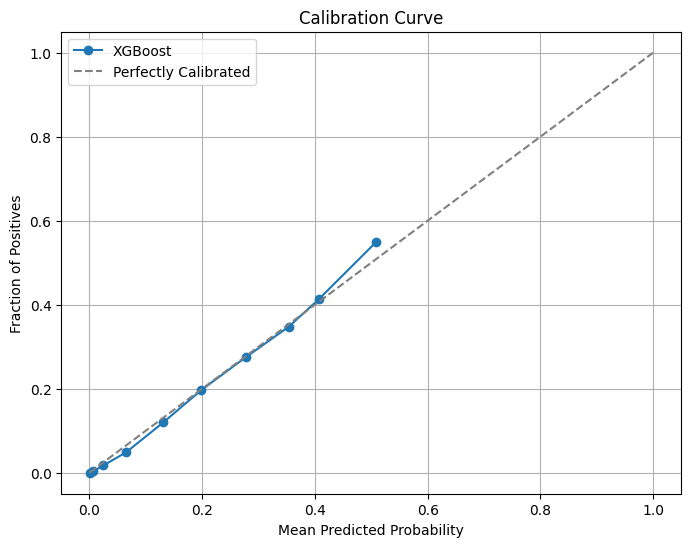

In [ ]:
#Main probability model -- TEST

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    brier_score_loss,
    accuracy_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# --- 1. Data preparation ---
# Copy to avoid modifying original
df = pbp_second_half.copy()


down_dummies = pd.get_dummies(df['down'], prefix='down', drop_first=True)
era_dummies = pd.get_dummies(df['era_bucket'], prefix='era', drop_first=True)

# Drop original columns
df = df.drop(columns=['down', 'era_bucket'])

# Concatenate all dummy variables
df = pd.concat([df, down_dummies, era_dummies], axis=1)




# Define features and label
features = [
    'game_seconds_remaining',
    'score_differential',
    'yardline_100',
    'ydstogo',
    'spread_time',
    'defteam_home_status',
    'diff_time_ratio',
    'posteam_timeouts_remaining',
    'defteam_timeouts_remaining',


] + list(down_dummies.columns) + list(era_dummies.columns)

features_model_3 = features

label = 'team_will_later_have_a_def_stop'

# Store results
results = {
    'season': [],
    'roc_auc': [],
    'log_loss': [],
    'brier_score': [],
    'accuracy': []
}
all_probs = []
all_y_true = []

# --- 2. Leave-One-Season-Out Cross-Validation ---
seasons = sorted(df['year'].unique())

for test_season in seasons:
    train_df = df[df['year'] != test_season]
    test_df = df[df['year'] == test_season]

    X_train = train_df[features]
    y_train = train_df[label]
    X_test = test_df[features]
    y_test = test_df[label]


    prob_model = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    prob_model.fit(X_train, y_train)

    y_proba = prob_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # Metrics
    results['season'].append(test_season)
    results['roc_auc'].append(roc_auc_score(y_test, y_proba))
    results['log_loss'].append(log_loss(y_test, y_proba))
    results['brier_score'].append(brier_score_loss(y_test, y_proba))
    results['accuracy'].append(accuracy_score(y_test, y_pred))
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results.setdefault('precision', []).append(precision)
    results.setdefault('recall', []).append(recall)
    results.setdefault('f1_score', []).append(f1)

    all_probs.extend(y_proba)
    all_y_true.extend(y_test)

# --- 3. Results summary ---
results_df = pd.DataFrame(results)
print("Cross-Validation Performance:")
print(results_df.describe())

# --- 4. Calibration Plot ---
def plot_calibration_curve(y_true, y_proba, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=n_bins, strategy='quantile')
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.title('Calibration Curve')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_calibration_curve(all_y_true, all_probs)


In [ ]:
#Run final probability model

import pandas as pd
import numpy as np
from xgboost import XGBClassifier

# --- 1. Create copy to work from ---
pbp_second_half_2 = pbp_second_half.copy()

# --- 2. Create dummy variables for 'down' and 'era_bucket' ---
down_dummies = pd.get_dummies(pbp_second_half_2['down'], prefix='down', drop_first=True)
era_dummies = pd.get_dummies(pbp_second_half_2['era_bucket'], prefix='era', drop_first=True)

# --- 3. Drop original categorical columns ---
pbp_second_half_2 = pbp_second_half_2.drop(columns=['down', 'era_bucket'])

# --- 4. Concatenate dummy variables back to the dataframe ---
pbp_second_half_2 = pd.concat([pbp_second_half_2, down_dummies, era_dummies], axis=1)

# --- 5. Define model features ---
features_model_3 = [
    'game_seconds_remaining',
    'score_differential',
    'yardline_100',
    'ydstogo',
    'spread_time',
    'defteam_home_status',
    'diff_time_ratio',
    'posteam_timeouts_remaining',
    'defteam_timeouts_remaining',
] + list(down_dummies.columns) + list(era_dummies.columns)

label = 'team_will_later_have_a_def_stop'

# --- 6. Extract X and y ---
X_full = pbp_second_half_2[features_model_3]
y_full = pbp_second_half_2[label]

# --- 7. Fit model on all data ---
final_prob_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

final_prob_model.fit(X_full, y_full)

# --- 8. Predict probabilities and attach back to the dataframe ---
pbp_second_half_2['late_game_stop_prob'] = final_prob_model.predict_proba(X_full)[:, 1]

/opt/anaconda3/envs/survival-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:20:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# *** --------------------------------------------- ***

In [ ]:
# -------- WP Loss from a Penalty Model -------------

In [ ]:
# *** --------------------------------------------- ***

In [ ]:
# Load CSV with saved predictions across all plays

# I modeled this in R, because that's where the NFL Fast R code is more robust (and has all the detailed functions to run the WP Model)
#  You can see the code for this model specifically at the end of this notebook, in the "Appendix" Section (it will be in R, just not run)

wp_loss_preds = pd.read_csv("wp_loss_preds.csv")

In [ ]:
# *** --------------------------------------------- ***

In [ ]:
#---------- Combine All Models Together ---------------

In [ ]:
# *** --------------------------------------------- ***

In [ ]:
# PROBABILITY MODEL: Merge the predicted probabilities into the original pbp_second_half
pbp_second_half = pbp_second_half.merge(
    pbp_second_half_2[['game_id', 'play_id', 'late_game_stop_prob']],
    on=['game_id', 'play_id'],
    how='left'
)

In [ ]:
#Create temporary table 'a' to hold predicted game_seconds_remaining_distribution (so it doesn't clog up the main tables)

a = a.merge(df_new[['game_id','play_id','duration_pdf_model']], on = ['game_id','play_id'], how = 'left')
a['duration_pdf_final'] = np.where(a['game_seconds_remaining'] > 600, a['duration_pdf_hist'], a['duration_pdf_model'])

In [ ]:
#Combine LOWESS Curves and Predicted Times to get Marginal TO Value at Each Point

# Convert LOWESS arrays to flat NumPy arrays
lowess_curve_1 = np.array(lowess_curve_1).flatten()
lowess_curve_2 = np.array(lowess_curve_2).flatten()
lowess_curve_3 = np.array(lowess_curve_3).flatten()

# Function to compute expected values
def compute_ev(pdf):
    try:
        # Handle malformed or missing PDFs gracefully
        pdf = np.ravel(pdf).astype(float)
        if len(pdf) != 301:
            raise ValueError("PDF does not have 301 values.")
        return {
            "expected_value_to_1": float(np.dot(pdf, lowess_curve_1)),
            "expected_value_to_2": float(np.dot(pdf, lowess_curve_2)),
            "expected_value_to_3": float(np.dot(pdf, lowess_curve_3)),
        }
    except:
        return {
            "expected_value_to_1": np.nan,
            "expected_value_to_2": np.nan,
            "expected_value_to_3": np.nan,
        }


# Apply row-wise
ev_results = a["duration_pdf_final"].apply(compute_ev)

# Convert and merge back
ev_df = pd.DataFrame(ev_results.tolist())
a = pd.concat([a, ev_df], axis=1)


In [ ]:
#Bring marginal TO value back into PBP Second Half
# pbp_second_half.drop(columns=['expected_value_to_1','expected_value_to_2','expected_value_to_3'], inplace=True)
pbp_second_half = pbp_second_half.merge(a[['game_id','play_id','expected_value_to_1','expected_value_to_2','expected_value_to_3']], on = ['game_id','play_id'], how = 'left')

In [ ]:
#Create a couple of new columns based on the expected value functions

pbp_second_half['current_to_value'] = np.where(
    pbp_second_half['posteam_timeouts_remaining'] == 3, pbp_second_half['expected_value_to_3'], np.where(
    pbp_second_half['posteam_timeouts_remaining'] == 2, pbp_second_half['expected_value_to_2'], np.where(
    pbp_second_half['posteam_timeouts_remaining'] == 1, pbp_second_half['expected_value_to_1'], np.where(
    pbp_second_half['posteam_timeouts_remaining'] == 0, 0, np.nan))))

pbp_second_half['expected_to_value'] = pbp_second_half['current_to_value'] * pbp_second_half['late_game_stop_prob']

In [ ]:
#Bring in WP Change from Penalty Loss

wp_loss_preds.head(3)
wp_loss_preds[['game_id','play_id','posteam','defteam','wp','off_pen_wp','pen_wp_change','season']].query('season > 2014').head(10)

game_id  play_id Next_Score_Half  Drive_Score_Half play_type  game_seconds_remaining  half_seconds_remaining  yardline_100      roof posteam defteam  posteam_score  defteam_score home_team  ydstogo  season  qtr  down  week  drive        ep  score_differential  posteam_timeouts_remaining  defteam_timeouts_remaining                                                                                          desc receiver_player_name pass_location  air_yards  yards_after_catch  complete_pass  incomplete_pass  interception  qb_hit  extra_point_result field_goal_result  sp Winner  spread_line  total_line        wp  off_pen_wp  off_to_wp  pen_wp_change  to_wp_change  to_v_pen_wp_change to_v_pen_label  to_v_pen_binary
0  2001_01_ATL_SF       57   Opp_Touchdown                 6      pass                    3591                    1791            73  outdoors      SF     ATL              0              0        SF       10    2001    1     1     1    1.0  1.224513                   0                           3                           3                   (14:51) 5-J.Garcia pass to 88-J.Swift to SF 33 for 6 yards (56-K.Brooking).              J.Swift           NaN        NaN                NaN            1.0              0.0           0.0     0.0                 NaN               NaN   0     SF          3.5        46.0  0.613763    0.589728   0.612671      -0.024034     -0.001092            0.022942    Take the TO              0.0
1  2001_01_ATL_SF       78   Opp_Touchdown                 6       run                    3558                    1758            67  outdoors      SF     ATL              0              0        SF        4    2001    1     2     1    1.0  1.457278                   0                           3                           3                              (14:18) 20-G.Hearst left guard to SF 35 for 2 yards (98-T.Hall).                  NaN           NaN        NaN                NaN            0.0              0.0           0.0     0.0                 NaN               NaN   0     SF          3.5        46.0  0.642467    0.610124   0.641966      -0.032343     -0.000501            0.031842    Take the TO              0.0
2  2001_01_ATL_SF       99   Opp_Touchdown                 6      pass                    3517                    1717            65  outdoors      SF     ATL              0              0        SF        2    2001    1     3     1    1.0  1.000212                   0                           3                           3  (13:37) 5-J.Garcia pass to 89-T.Streets to ATL 39 for 26 yards (54-C.Draft). caught at SF 38            T.Streets           NaN        NaN                NaN            1.0              0.0           0.0     0.0                 NaN               NaN   0     SF          3.5        46.0  0.619187    0.580683   0.617927      -0.038504     -0.001261            0.037243    Take the TO              0.0

In [ ]:
#Merge WP Predictions into Main Table

pbp_second_half = pbp_second_half.merge(wp_loss_preds[['game_id','play_id','off_pen_wp','pen_wp_change','to_wp_change','to_v_pen_wp_change']],
                                        on = ['game_id','play_id'], how = 'left')

pbp_second_half.rename(columns = {'to_wp_change':'wpmodel_to_wp_change', 'to_v_pen_wp_change': 'wpmodel_to_v_pen_wp_change'}, inplace = True)

In [ ]:
#Test code to check / investigate nulls
# 2002 week 1 has some nulls because of the rolling calculations

pbp_second_half.query('game_id == "2002_01_ARI_WAS" & play_id == 2558').head(300)
pbp_second_half.query('play_off_or_def == 1 & expected_to_value.isnull() & down > 0 & year > 2002').sort_values(by = 'year', ascending = True).head(300)

game_id  play_id posteam defteam  posteam_score  defteam_score  qtr   time   yrdln  down  ydstogo  yardline_100  goal_to_go  game_seconds_remaining  half_seconds_remaining  score_differential  total_home_score  total_away_score  drive  series  vegas_wp  vegas_wpa        wp    def_wp       wpa   home_wp   away_wp  home_wp_post  away_wp_post play_type  pass  rush  pass_attempt  rush_attempt  out_of_bounds   sp  yards_gained  first_down  touchdown  safety  field_goal_attempt field_goal_result  two_point_attempt  kickoff_attempt  home_opening_kickoff  own_kickoff_recovery  special  fumble_lost  interception  sack  posteam_timeouts_remaining  defteam_timeouts_remaining  away_timeouts_remaining  home_timeouts_remaining  timeout timeout_team  penalty penalty_team  penalty_yards penalty_type  play series_result  series_success away_team home_team  spread_line  total_line  third_down_converted  third_down_failed  fourth_down_converted  fourth_down_failed passer_player_id  \
28  2002_01_ARI_WAS   2558.0     ARI     WAS           16.0           24.0  3.0  05:14  MID 50   3.0      3.0          50.0           0                  1214.0                  1214.0                -8.0              24.0              16.0   16.0    37.0  0.139993    0.02598  0.193725  0.806275  0.029535  0.806275  0.193725       0.77674       0.22326       run   0.0   1.0           0.0           1.0            0.0  0.0           6.0         1.0        0.0     0.0                 0.0              None                0.0              0.0                   1.0                   0.0      0.0          0.0           0.0   0.0                         3.0                         3.0                      3.0                      3.0      0.0         None      0.0         None            NaN         None   1.0    First down             1.0       ARI       WAS          6.0        44.5                   1.0                0.0                    0.0                 0.0             None   

   passer_player_name passer passer_id  season  week season_type  div_game        ep       epa  total_home_epa  total_away_epa  total_home_rush_epa  total_away_rush_epa  total_home_pass_epa  total_away_pass_epa    qb_epa  away_score  home_score  result  total  series_start_seconds_remaining  defteam_home_status  year  spread_time  diff_time_ratio  play_off_or_def  redzone_drive_start  drive_redzone_td_start  field_goal_made  field_goal_missed  drive_redzone_fg_start  redzone_points  high_leverage_converted  high_leverage_attempt  off_successful  vegas_posteam_wp  vegas_defteam_wp  vegas_posteam_wp_post  vegas_defteam_wp_post  vegas_home_wp  vegas_away_wp  vegas_home_wpa  off_penalty  turnover  sec_remaining_at_next_step  sec_to_next_snap  explosive_play  chaotic_play  total_score  points_per_second  points_per_drive  drive_play_count  log_play_count  distance_to_crunch_time second_half_time_bucket second_half_play_score_bucket second_half_play_ydline_bucket era_bucket  redzone  \
28               None   None      None    2002     1         REG         0  1.163938  1.202072        2.059191       -2.059191             6.619458            -6.619458             1.189159            -1.189159  1.202072          23          31       8     54                          1288.0                  1.0  2002     0.423437      -113.358192                1                    0                       0                0                  0                       0               0                        1                      1             1.0          0.139993          0.860007               0.165973               0.834027       0.860007       0.139993         0.97402            0         0                      1173.0              41.0               0             0         40.0           0.016764          2.666667               3.0        1.386294                 3.046667                  Mid Q3                  Down 1 Score              Own Side of Field    2001-05        0   

    pos_offense_epa_per_play_wk_week

In [ ]:
#Calculate final columns

    #For my modeling, if positive, take the penalty; if negative, take the TO
pbp_second_half['marginal_to_v_pen'] = pbp_second_half['expected_to_value'] + pbp_second_half['pen_wp_change']
pbp_second_half['marginal_recommendation'] = np.where(pbp_second_half['marginal_to_v_pen'] <= 0, 'Take the Timeout', 'Take the Penalty')
pbp_second_half['ev_to_3'] = pbp_second_half['expected_value_to_3'] * pbp_second_half['late_game_stop_prob']
pbp_second_half['ev_to_2'] = pbp_second_half['expected_value_to_2'] * pbp_second_half['late_game_stop_prob']
pbp_second_half['ev_to_1'] = pbp_second_half['expected_value_to_1'] * pbp_second_half['late_game_stop_prob']
pbp_second_half['marginal_to_3'] = pbp_second_half['ev_to_3'] + pbp_second_half['pen_wp_change']
pbp_second_half['marginal_to_2'] = pbp_second_half['ev_to_2'] + pbp_second_half['pen_wp_change']
pbp_second_half['marginal_to_1'] = pbp_second_half['ev_to_1'] + pbp_second_half['pen_wp_change']
pbp_second_half['marginal_rec_to_3'] = np.where(pbp_second_half['marginal_to_3'] <= 0, 'Take the Timeout', 'Take the Penalty')
pbp_second_half['marginal_rec_to_2'] = np.where(pbp_second_half['marginal_to_2'] <= 0, 'Take the Timeout', 'Take the Penalty')
pbp_second_half['marginal_rec_to_1'] = np.where(pbp_second_half['marginal_to_1'] <= 0, 'Take the Timeout', 'Take the Penalty')

    #From the NFL Fast R Model (Ignore for this analysis)
pbp_second_half['wp_model_recommendation'] = np.where(pbp_second_half['wpmodel_to_v_pen_wp_change'] >= 0, 'Take the Timeout', 'Take the Penalty')


In [ ]:
#Create a new copy of the dataframe to work off with for analysis purposes

pbp_final_analysis = pbp_second_half.copy()
pbp_final_analysis = pbp_final_analysis.query('pen_wp_change < 0 & down > 0')

In [ ]:
# *** --------------------------------------------- ***

In [ ]:
#---------------- Analysis Tables  --------------------

In [ ]:
# *** --------------------------------------------- ***

In [ ]:
#Table counting the percentage of plays the model recommends to take the penalty

import pandas as pd

# === 1. Define score buckets and compute penalty percentages ===
score_buckets = [
    "Down 2+ Scores",
    "Down 1 Score",
    "Tied",
    "Up 1 Score",
    "Up 2+ Scores"
]

def calculate_penalty_pct(df, rec_col):
    pct_by_bucket = (
        df.groupby('second_half_play_score_bucket')[rec_col]
        .apply(lambda x: (x == "Take the Penalty").mean())
        .reindex(score_buckets)
        .round(3)
    )
    overall_pct = (df[rec_col] == "Take the Penalty").mean()
    return pd.Series([overall_pct] + pct_by_bucket.tolist(),
                     index=["Overall"] + score_buckets)

# === 2. Get rows for each TO scenario ===
row_3to = calculate_penalty_pct(pbp_final_analysis, 'marginal_rec_to_3')
row_2to = calculate_penalty_pct(pbp_final_analysis, 'marginal_rec_to_2')
row_1to = calculate_penalty_pct(pbp_final_analysis, 'marginal_rec_to_1')

# === 3. Combine into final DataFrame ===
summary_df = pd.DataFrame({
    "3TO": row_3to,
    "2TO": row_2to,
    "1TO": row_1to
}).T

summary_df.index.name = "Team's Current TO Remaining"

# Format percentages
summary_df = summary_df.applymap(lambda x: f"{round(x * 100)}%" if pd.notnull(x) else "N/A")

# === 4. Define styling ===
styled = (
    summary_df.style
    .set_caption("**Share of Plays a Team Should Take a Penalty Instead of Calling a Timeout**")
    .set_table_styles([
        # Title styling
        {"selector": "caption", "props": [
            ("color", "black"),
            ("font-size", "18px"),
            ("font-weight", "bold"),
            ("text-align", "center"),
            ("margin-bottom", "15px")
        ]},

        # Header cells (column titles)
        {"selector": "thead th", "props": [
            ("background-color", "#1f1245"),
            ("color", "white"),
            ("font-weight", "bold"),
            ("border", "1px solid black"),
            ("text-align", "center"),
            ("vertical-align", "middle")
        ]},

        # Index column (row header: 3TO, 2TO, 1TO)
        {"selector": "th.row_heading", "props": [
            ("background-color", "#f0f0f0"),
            ("color", "black"),
            ("font-weight", "bold"),
            ("border", "1px solid black"),
            ("text-align", "center")
        ]},

        # First header cell (the index name): Keep it dark with white text
        {"selector": "thead th:first-child", "props": [
            ("background-color", "#1f1245"),
            ("color", "white"),
            ("text-align", "center")
        ]},

        # Data cells
        {"selector": "td", "props": [
            ("background-color", "white"),
            ("color", "black"),
            ("border", "1px solid black"),
            ("text-align", "center"),
            ("padding", "6px")
        ]}
    ])
    .set_properties(**{
        "border": "1px solid black",
        "text-align": "center"
    })
)

styled


/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/2066640766.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('second_half_play_score_bucket')[rec_col]
/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/2066640766.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('second_half_play_score_bucket')[rec_col]
/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/2066640766.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

In [ ]:
#Creating new buckets to analyze the data

# ---- Down / Distance Bucket _____

pbp_final_analysis['down_distance_bucket'] = np.where(
    (pbp_final_analysis['down'] == 1) & (pbp_final_analysis['ydstogo'] > 0) & (pbp_final_analysis['ydstogo'] <= 3), '1st & Short', np.where(
    (pbp_final_analysis['down'] == 1) & (pbp_final_analysis['ydstogo'] > 3) & (pbp_final_analysis['ydstogo'] <= 7), '1st & Medium', np.where(
    (pbp_final_analysis['down'] == 1) & (pbp_final_analysis['ydstogo'] > 7) & (pbp_final_analysis['ydstogo'] <= 12), '1st & Long', np.where(
    (pbp_final_analysis['down'] == 1) & (pbp_final_analysis['ydstogo'] > 12) & (pbp_final_analysis['ydstogo'] <= 100), '1st & Very Long', np.where(
    (pbp_final_analysis['down'] == 2) & (pbp_final_analysis['ydstogo'] > 0) & (pbp_final_analysis['ydstogo'] <= 3), '2nd & Short', np.where(
    (pbp_final_analysis['down'] == 2) & (pbp_final_analysis['ydstogo'] > 3) & (pbp_final_analysis['ydstogo'] <= 7), '2nd & Medium', np.where(
    (pbp_final_analysis['down'] == 2) & (pbp_final_analysis['ydstogo'] > 7) & (pbp_final_analysis['ydstogo'] <= 12), '2nd & Long', np.where(
    (pbp_final_analysis['down'] == 2) & (pbp_final_analysis['ydstogo'] > 12) & (pbp_final_analysis['ydstogo'] <= 100), '2nd & Very Long', np.where(
    (pbp_final_analysis['down'] == 3) & (pbp_final_analysis['ydstogo'] > 0) & (pbp_final_analysis['ydstogo'] <= 3), '3rd & Short', np.where(
    (pbp_final_analysis['down'] == 3) & (pbp_final_analysis['ydstogo'] > 3) & (pbp_final_analysis['ydstogo'] <= 7), '3rd & Medium', np.where(
    (pbp_final_analysis['down'] == 3) & (pbp_final_analysis['ydstogo'] > 7) & (pbp_final_analysis['ydstogo'] <= 12), '3rd & Long', np.where(
    (pbp_final_analysis['down'] == 3) & (pbp_final_analysis['ydstogo'] > 12) & (pbp_final_analysis['ydstogo'] <= 100), '3rd & Very Long', np.where(
    (pbp_final_analysis['down'] == 4) & (pbp_final_analysis['ydstogo'] > 0) & (pbp_final_analysis['ydstogo'] <= 3), '4th & Short', np.where(
    (pbp_final_analysis['down'] == 4) & (pbp_final_analysis['ydstogo'] > 3) & (pbp_final_analysis['ydstogo'] <= 7), '4th & Medium', np.where(
    (pbp_final_analysis['down'] == 4) & (pbp_final_analysis['ydstogo'] > 7) & (pbp_final_analysis['ydstogo'] <= 12), '4th & Long', np.where(
    (pbp_final_analysis['down'] == 4) & (pbp_final_analysis['ydstogo'] > 12) & (pbp_final_analysis['ydstogo'] <= 100), '4th & Very Long',
        np.nan))))))))))))))))

# ---- Expanded Time Bucket -----

expanded_time_bucket_bins = [0, 180, 360, 540, 720, 900, 1080, 1260, 1440, 1620, 1800]
expanded_time_bucket_labels = [
    'Q4: 0-3 min',
    'Q4: 3-6 min',
    'Q4: 6-9 min',
    'Q4: 9-12 min',
    'Q4: 12-15 min',
    'Q3: 0-3 min',
    'Q3: 3-6 min',
    'Q3: 6-9 min',
    'Q3: 9-12 min',
    'Q3: 12-15 min',
]

pbp_final_analysis['expanded_time_bucket'] = pd.cut(
    pbp_final_analysis['game_seconds_remaining'],
    bins=expanded_time_bucket_bins,
    labels=expanded_time_bucket_labels,
    right=True
)

distance_bucket_bins = [0, 3, 7, 12, 100]
distance_bucket_labels = [
    'Short',
    'Medium',
    'Long',
    'Very Long'
]

pbp_final_analysis['distance_bucket'] = pd.cut(
    pbp_final_analysis['ydstogo'],
    bins=distance_bucket_bins,
    labels=distance_bucket_labels,
    right=True
)

/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/3539985303.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_simple = df.groupby([


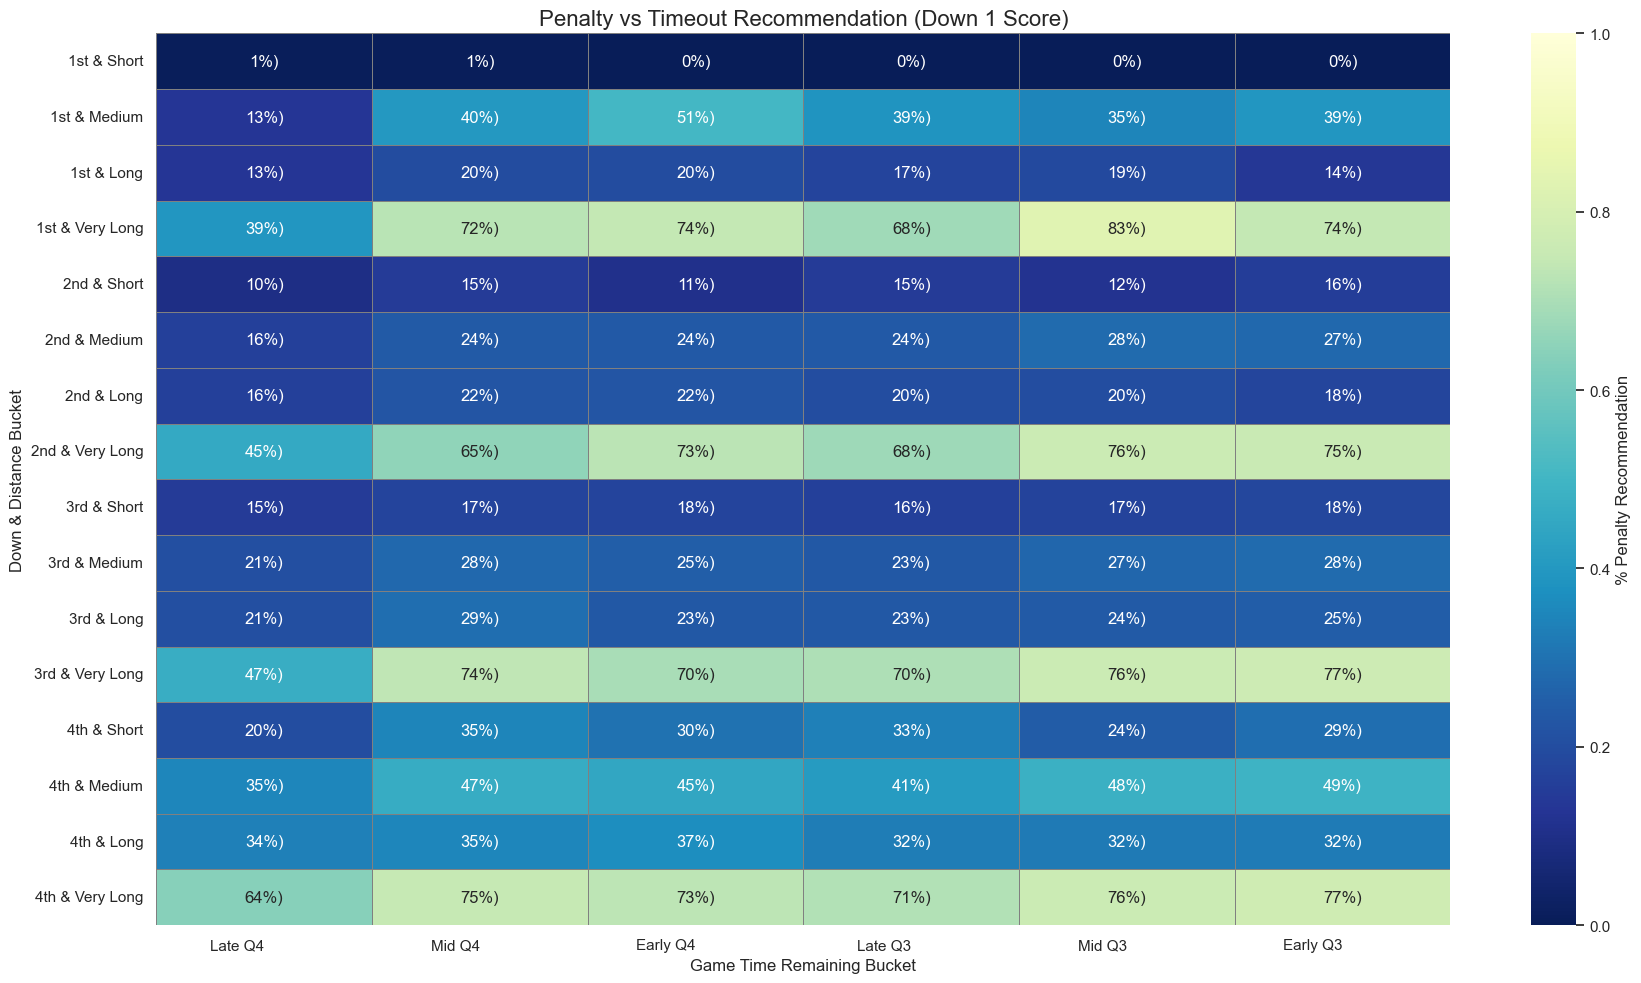

In [ ]:
#Heatmap #1: Down / Distance v. Time Remaining (% GO)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filter only rows with valid recommendations
df = pbp_final_analysis.copy()
df = df[df['marginal_rec_to_3'].isin(['Take the Penalty', 'Take the Timeout'])]

# 2. Group and aggregate
grouped_simple = df.groupby([
    # 'second_half_play_ydline_bucket',
    'down_distance_bucket',
    'second_half_time_bucket',
    'second_half_play_score_bucket',
]).agg(
    total_plays=('marginal_rec_to_3', 'count'),
    penalty_plays=('marginal_rec_to_3', lambda x: (x == 'Take the Penalty').sum())
).reset_index()

# 3. Compute percentage
grouped_simple['penalty_pct'] = grouped_simple['penalty_plays'] / grouped_simple['total_plays']
grouped_simple['label'] = grouped_simple.apply(
    lambda row: f"{row['penalty_pct']:.0%})", axis=1
)

# 1. Filter dataset
grouped_simple_down_one_score = grouped_simple.query('second_half_play_score_bucket == "Down 1 Score"').copy()


# Define the exact desired order
desired_order = [
    '1st & Short', '1st & Medium', '1st & Long', '1st & Very Long',
    '2nd & Short', '2nd & Medium', '2nd & Long', '2nd & Very Long',
    '3rd & Short', '3rd & Medium', '3rd & Long', '3rd & Very Long',
    '4th & Short', '4th & Medium', '4th & Long', '4th & Very Long'
]

# Convert to categorical with the correct order
grouped_simple_down_one_score['down_distance_bucket'] = pd.Categorical(
    grouped_simple_down_one_score['down_distance_bucket'],
    categories=desired_order,
    ordered=True
)


# Pivot
heatmap_data = grouped_simple_down_one_score.pivot(
    index='down_distance_bucket',
    columns='second_half_time_bucket',
    values='penalty_pct'
)

label_data = grouped_simple_down_one_score.pivot(
    index='down_distance_bucket',
    columns='second_half_time_bucket',
    values='label'
)

# No need to sort if using categorical order, but safe to do:
heatmap_data = heatmap_data.sort_index()
label_data = label_data.reindex(index=heatmap_data.index)


# 4. Plot
plt.figure(figsize=(18, 10))  # Shorter height since fewer y labels
sns.set(style="whitegrid")

ax = sns.heatmap(
    heatmap_data,
    annot=label_data,
    fmt='',
    cmap='YlGnBu_r',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': '% Penalty Recommendation'},
    vmin=0,
    vmax=1
)

plt.title('Penalty vs Timeout Recommendation (Down 1 Score)', fontsize=16)
plt.ylabel('Down & Distance Bucket', fontsize=12)
plt.xlabel('Game Time Remaining Bucket', fontsize=12)
plt.xticks(rotation=0, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

label_data.to_csv("heatmap_1.csv")



/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/4019345267.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_simple = df.groupby([


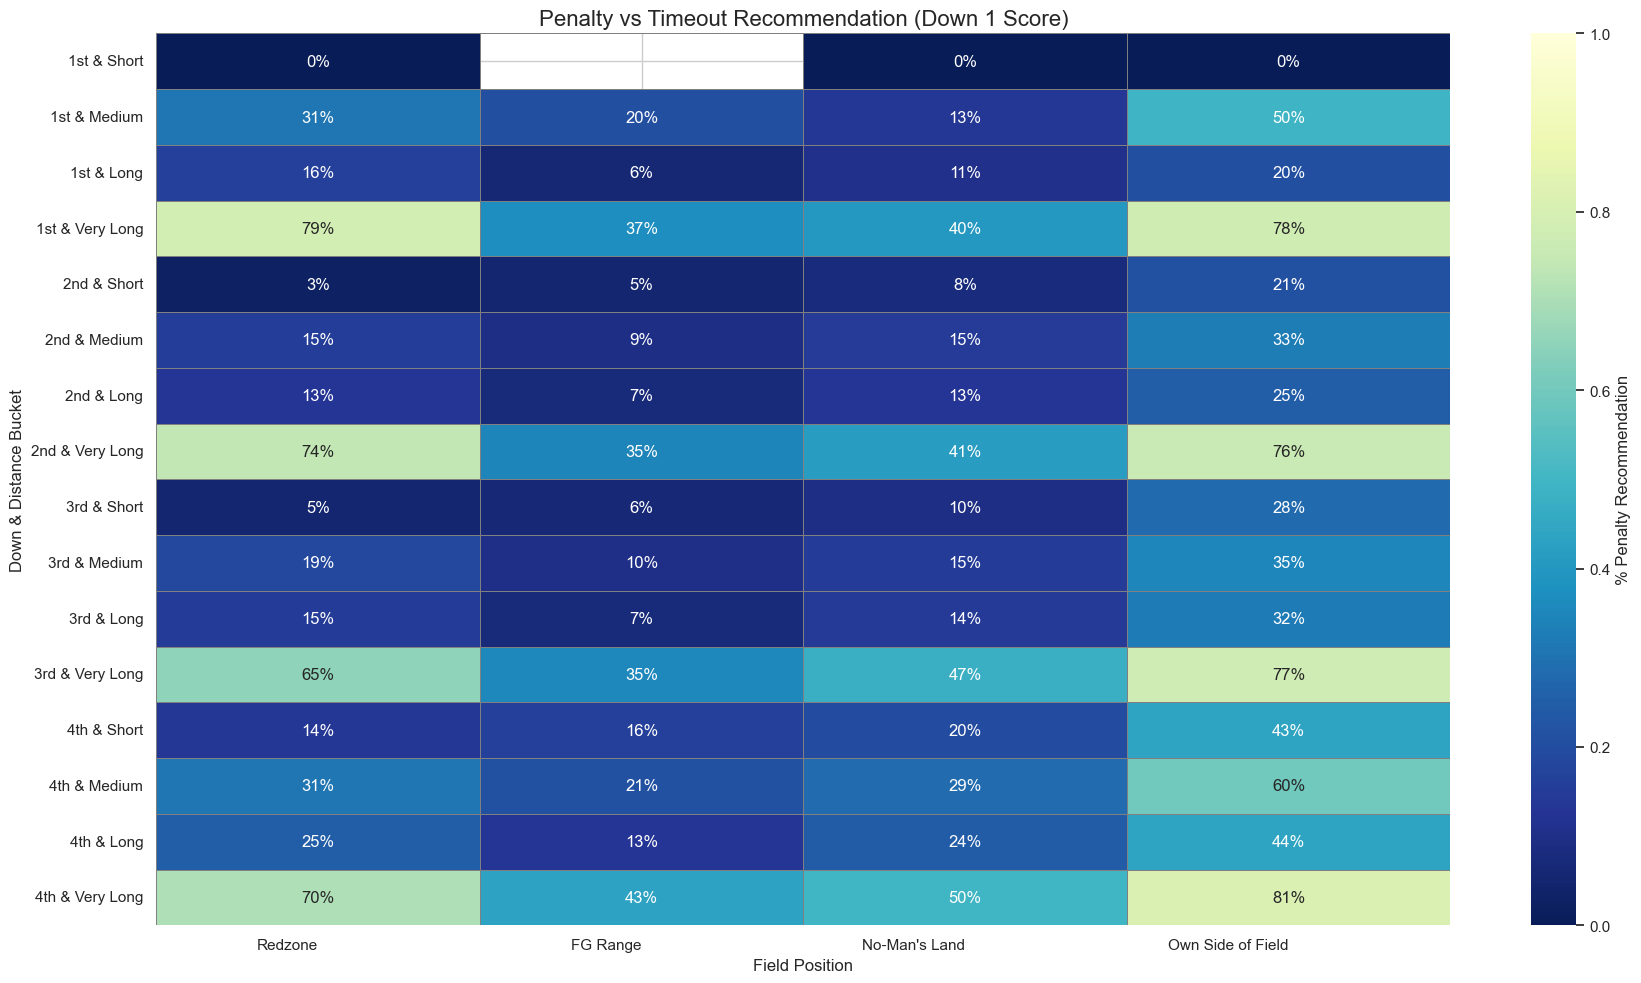

In [ ]:
#Heatmap #2: Down / Distance v. Field Position (% GO)

# 1. Filter only rows with valid recommendations
df = pbp_final_analysis.copy()
df = df[df['marginal_rec_to_3'].isin(['Take the Penalty', 'Take the Timeout'])]

# 2. Group and aggregate
grouped_simple = df.groupby([
    'second_half_play_ydline_bucket',
    'down_distance_bucket',
    # 'second_half_time_bucket',
    'second_half_play_score_bucket',
]).agg(
    total_plays=('marginal_rec_to_3', 'count'),
    penalty_plays=('marginal_rec_to_3', lambda x: (x == 'Take the Penalty').sum())
).reset_index()

# 3. Compute percentage
grouped_simple['penalty_pct'] = grouped_simple['penalty_plays'] / grouped_simple['total_plays']
grouped_simple['label'] = grouped_simple.apply(
    lambda row: f"{row['penalty_pct']:.0%}", axis=1
)

# 1. Filter dataset
grouped_simple_down_one_score = grouped_simple.query('second_half_play_score_bucket == "Down 1 Score"').copy()


# Define the exact desired order
desired_order = [
    '1st & Short', '1st & Medium', '1st & Long', '1st & Very Long',
    '2nd & Short', '2nd & Medium', '2nd & Long', '2nd & Very Long',
    '3rd & Short', '3rd & Medium', '3rd & Long', '3rd & Very Long',
    '4th & Short', '4th & Medium', '4th & Long', '4th & Very Long'
]

# Convert to categorical with the correct order
grouped_simple_down_one_score['down_distance_bucket'] = pd.Categorical(
    grouped_simple_down_one_score['down_distance_bucket'],
    categories=desired_order,
    ordered=True
)


# Pivot
heatmap_data = grouped_simple_down_one_score.pivot(
    index='down_distance_bucket',
    columns='second_half_play_ydline_bucket',
    values='penalty_pct'
)

label_data = grouped_simple_down_one_score.pivot(
    index='down_distance_bucket',
    columns='second_half_play_ydline_bucket',
    values='label'
)

# No need to sort if using categorical order, but safe to do:
heatmap_data = heatmap_data.sort_index()
label_data = label_data.reindex(index=heatmap_data.index)


# 4. Plot
plt.figure(figsize=(18, 10))  # Shorter height since fewer y labels
sns.set(style="whitegrid")

ax = sns.heatmap(
    heatmap_data,
    annot=label_data,
    fmt='',
    cmap='YlGnBu_r',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': '% Penalty Recommendation'},
    vmin=0,
    vmax=1
)

plt.title('Penalty vs Timeout Recommendation (Down 1 Score)', fontsize=16)
plt.ylabel('Down & Distance Bucket', fontsize=12)
plt.xlabel('Field Position', fontsize=12)
plt.xticks(rotation=0, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

label_data.to_csv("heatmap_2.csv")


/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/4051659869.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_wp = df.groupby([


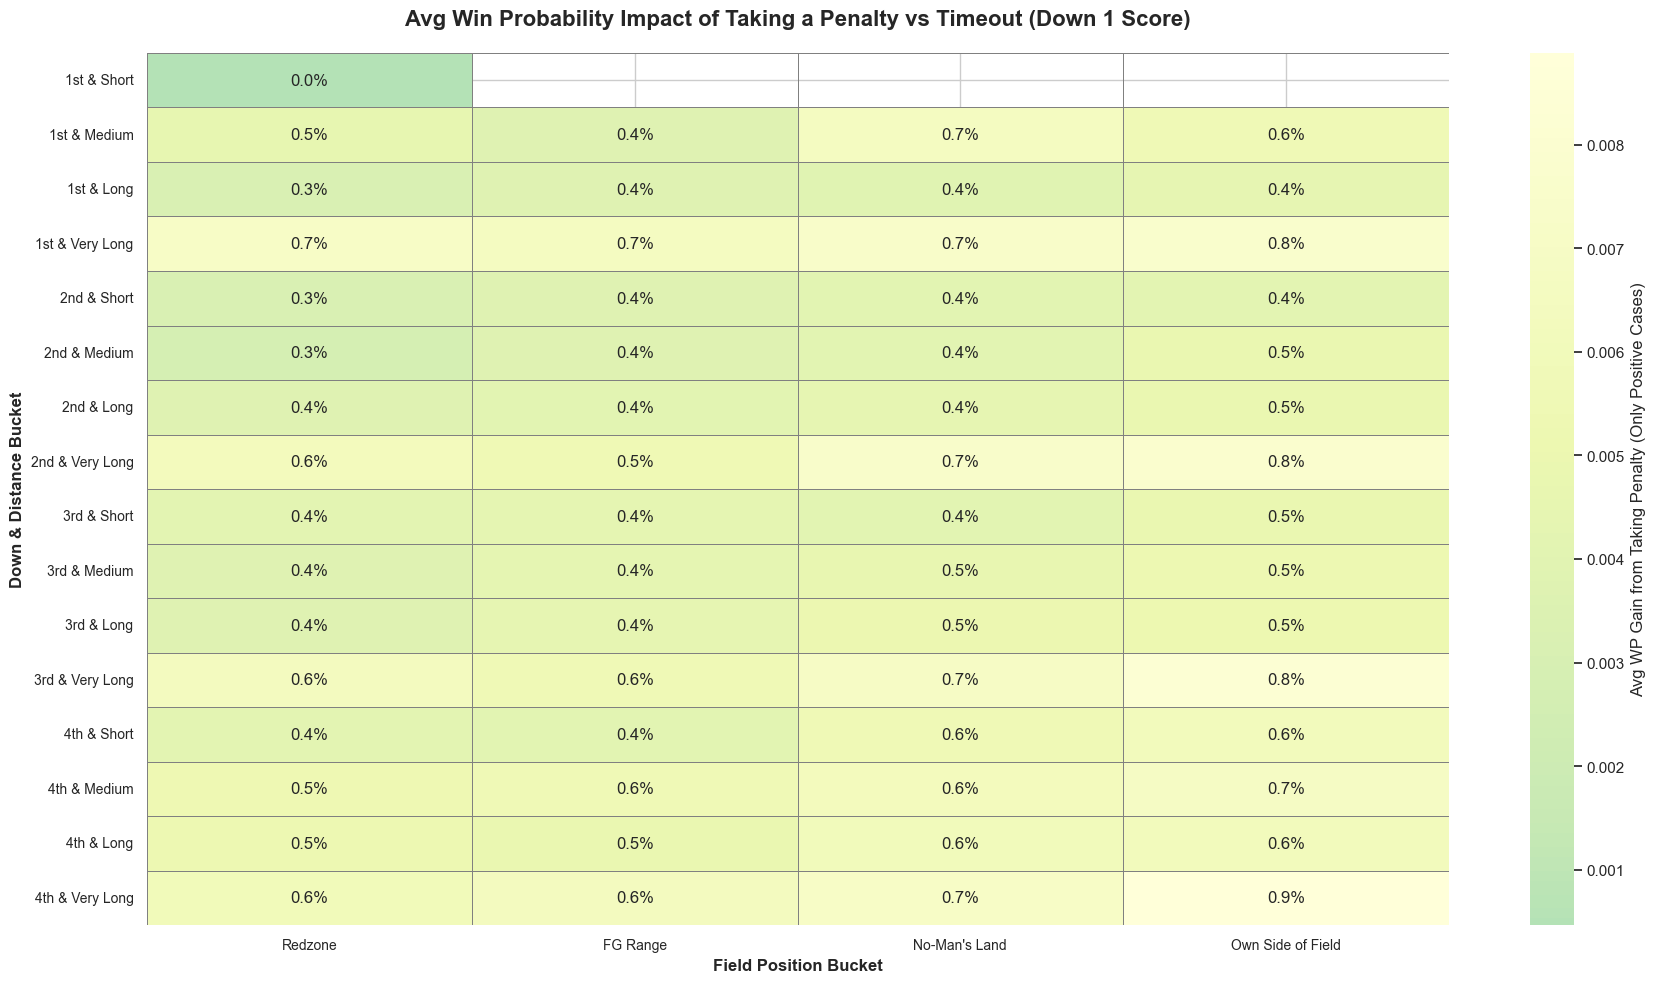

In [ ]:
#Heatmap #3: Down / Distance v. Time Remaining (WP Change)

# 1. Filter only rows with valid marginal_to_3 data
df = pbp_final_analysis.copy()
df = df[df['marginal_to_3'].notna()].copy()
df = df.query('marginal_to_3 > 0')

# 2. Group and aggregate mean WP impact
grouped_wp = df.groupby([
    'down_distance_bucket',
    'second_half_play_ydline_bucket',
    'second_half_play_score_bucket'
]).agg(
    avg_wp_diff=('marginal_to_3', 'mean'),
    n=('marginal_to_3', 'count')
).reset_index()

# 3. Format label with avg and count
grouped_wp['label'] = grouped_wp.apply(
    lambda row: f"{row['avg_wp_diff']:.1%}", axis=1
)

# 4. Focus on one score bucket
grouped_wp_up1 = grouped_wp.query('second_half_play_score_bucket == "Down 1 Score"').copy()

# 5. Order down-distance buckets
desired_order = [
    '1st & Short', '1st & Medium', '1st & Long', '1st & Very Long',
    '2nd & Short', '2nd & Medium', '2nd & Long', '2nd & Very Long',
    '3rd & Short', '3rd & Medium', '3rd & Long', '3rd & Very Long',
    '4th & Short', '4th & Medium', '4th & Long', '4th & Very Long'
]
grouped_wp_up1['down_distance_bucket'] = pd.Categorical(
    grouped_wp_up1['down_distance_bucket'],
    categories=desired_order,
    ordered=True
)

# 6. Pivot for heatmap and labels
heatmap_data = grouped_wp_up1.pivot(
    index='down_distance_bucket',
    columns='second_half_play_ydline_bucket',
    values='avg_wp_diff'
)
label_data = grouped_wp_up1.pivot(
    index='down_distance_bucket',
    columns='second_half_play_ydline_bucket',
    values='label'
)

# 7. Align label to data
label_data = label_data.reindex(index=heatmap_data.index)

import matplotlib.colors as mcolors

# Create custom diverging colormap from blue (negative) to yellow (positive)
plt.figure(figsize=(18, 10))
sns.set(style="whitegrid")

ax = sns.heatmap(
    heatmap_data,
    annot=label_data,
    fmt='',
    cmap='YlGnBu_r',
    center=-0.006,  # <- makes 0 the midpoint of the colormap
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Avg WP Gain from Taking Penalty (Only Positive Cases)'}
)

# Title and axis styling
plt.title(
    'Avg Win Probability Impact of Taking a Penalty vs Timeout (Down 1 Score)',
    fontsize=16,
    fontweight='bold',
    pad=20
)
plt.ylabel('Down & Distance Bucket', fontsize=12, fontweight='bold')
plt.xlabel('Field Position Bucket', fontsize=12, fontweight='bold')
plt.xticks(rotation=0, ha='center', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

label_data.to_csv("wp_gain_penalty_vs_timeout_down1score.csv")


/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/956848892.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_wp = df.groupby([


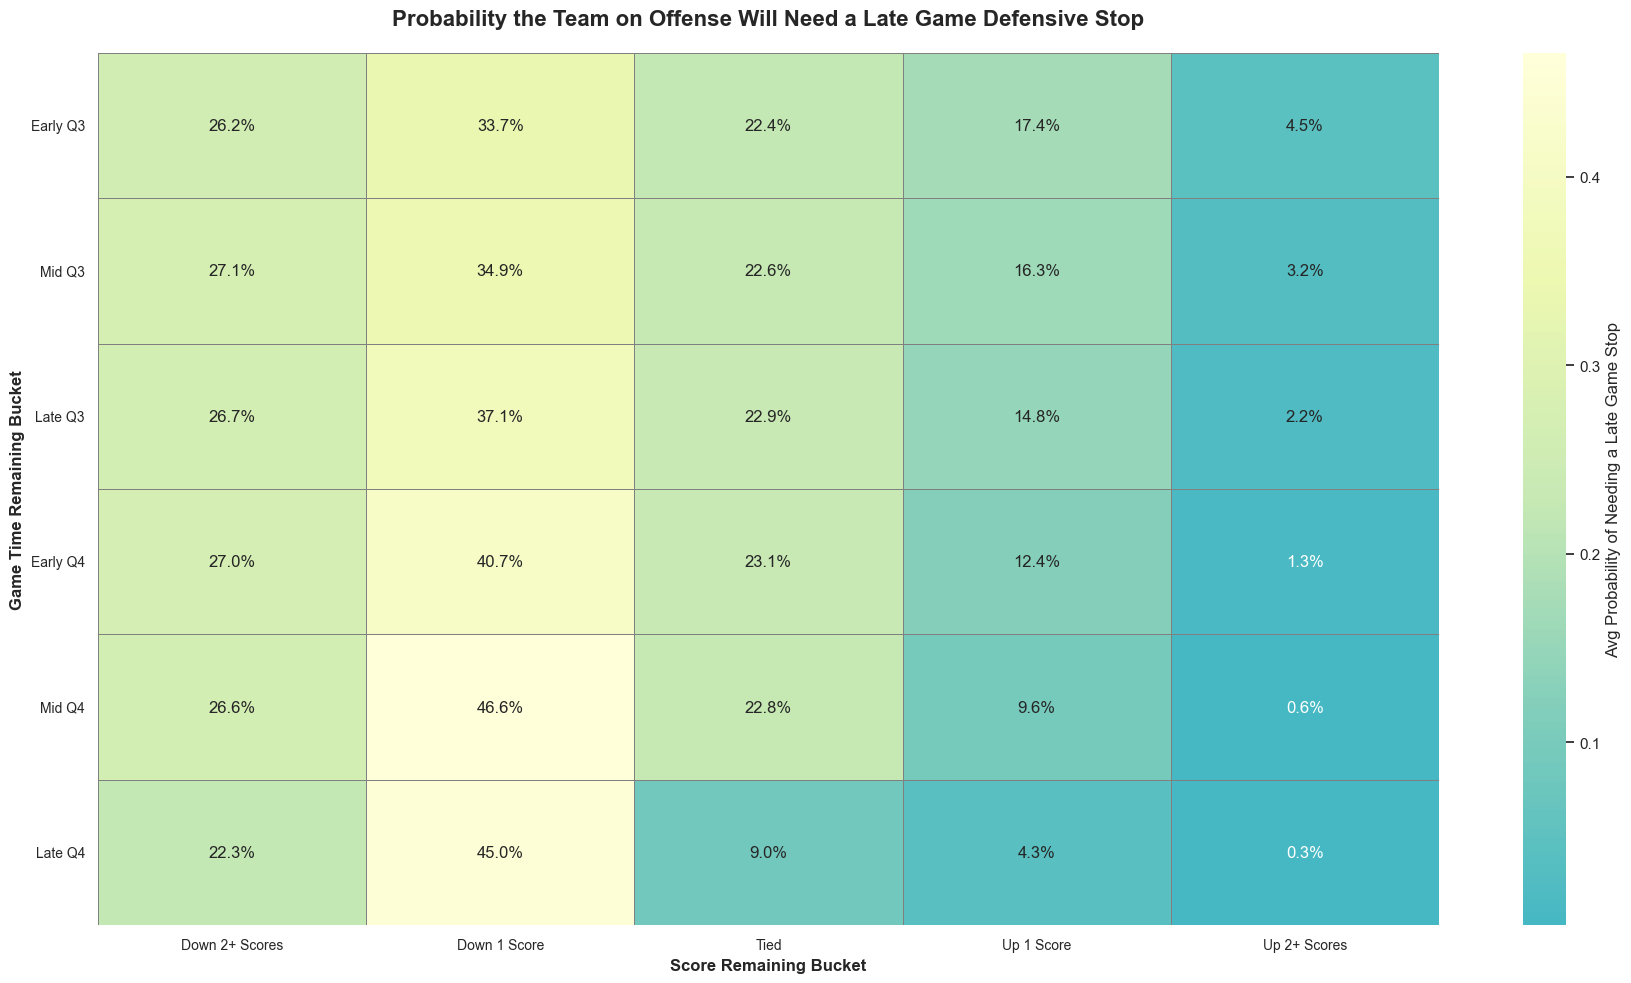

In [ ]:
#Heatmap #4: Time Remaining v. Score (Probability of Needing a Late Game Stop)


# 1. Filter only rows with valid marginal_to_3 data
df = pbp_final_analysis.copy()
df = df[df['late_game_stop_prob'].notna()].copy()
# df = df.query('marginal_to_3 > 0')

# 2. Group and aggregate mean WP impact
grouped_wp = df.groupby([
    'second_half_time_bucket',
    'second_half_play_score_bucket'
]).agg(
    avg_stop_prob=('late_game_stop_prob', 'mean'),
    n=('late_game_stop_prob', 'count')
).reset_index()

# 3. Format label with avg and count
grouped_wp['label'] = grouped_wp.apply(
    lambda row: f"{row['avg_stop_prob']:.1%}", axis=1
)


# 5. Order down-distance buckets
desired_order = [
    'Early Q3', 'Mid Q3', 'Late Q3', 'Early Q4', 'Mid Q4', 'Late Q4'
]
grouped_wp['second_half_time_bucket'] = pd.Categorical(
    grouped_wp['second_half_time_bucket'],
    categories=desired_order,
    ordered=True
)

# 6. Pivot for heatmap and labels
heatmap_data = grouped_wp.pivot(
    index='second_half_time_bucket',
    columns='second_half_play_score_bucket',
    values='avg_stop_prob'
)
label_data = grouped_wp.pivot(
    index='second_half_time_bucket',
    columns='second_half_play_score_bucket',
    values='label'
)

# 7. Align label to data
label_data = label_data.reindex(index=heatmap_data.index)

# Create custom diverging colormap from blue (negative) to yellow (positive)
plt.figure(figsize=(18, 10))
sns.set(style="whitegrid")

ax = sns.heatmap(
    heatmap_data,
    annot=label_data,
    fmt='',
    cmap='YlGnBu_r',
    center=-0.006,  # <- makes 0 the midpoint of the colormap
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Avg Probability of Needing a Late Game Stop'}
)

# Title and axis styling
plt.title(
    'Probability the Team on Offense Will Need a Late Game Defensive Stop',
    fontsize=16,
    fontweight='bold',
    pad=20
)
plt.ylabel('Game Time Remaining Bucket', fontsize=12, fontweight='bold')
plt.xlabel('Score Remaining Bucket', fontsize=12, fontweight='bold')
plt.xticks(rotation=0, ha='center', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

label_data.to_csv("prob_late_game_stop.csv")



/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/2960146469.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_wp = df.groupby([


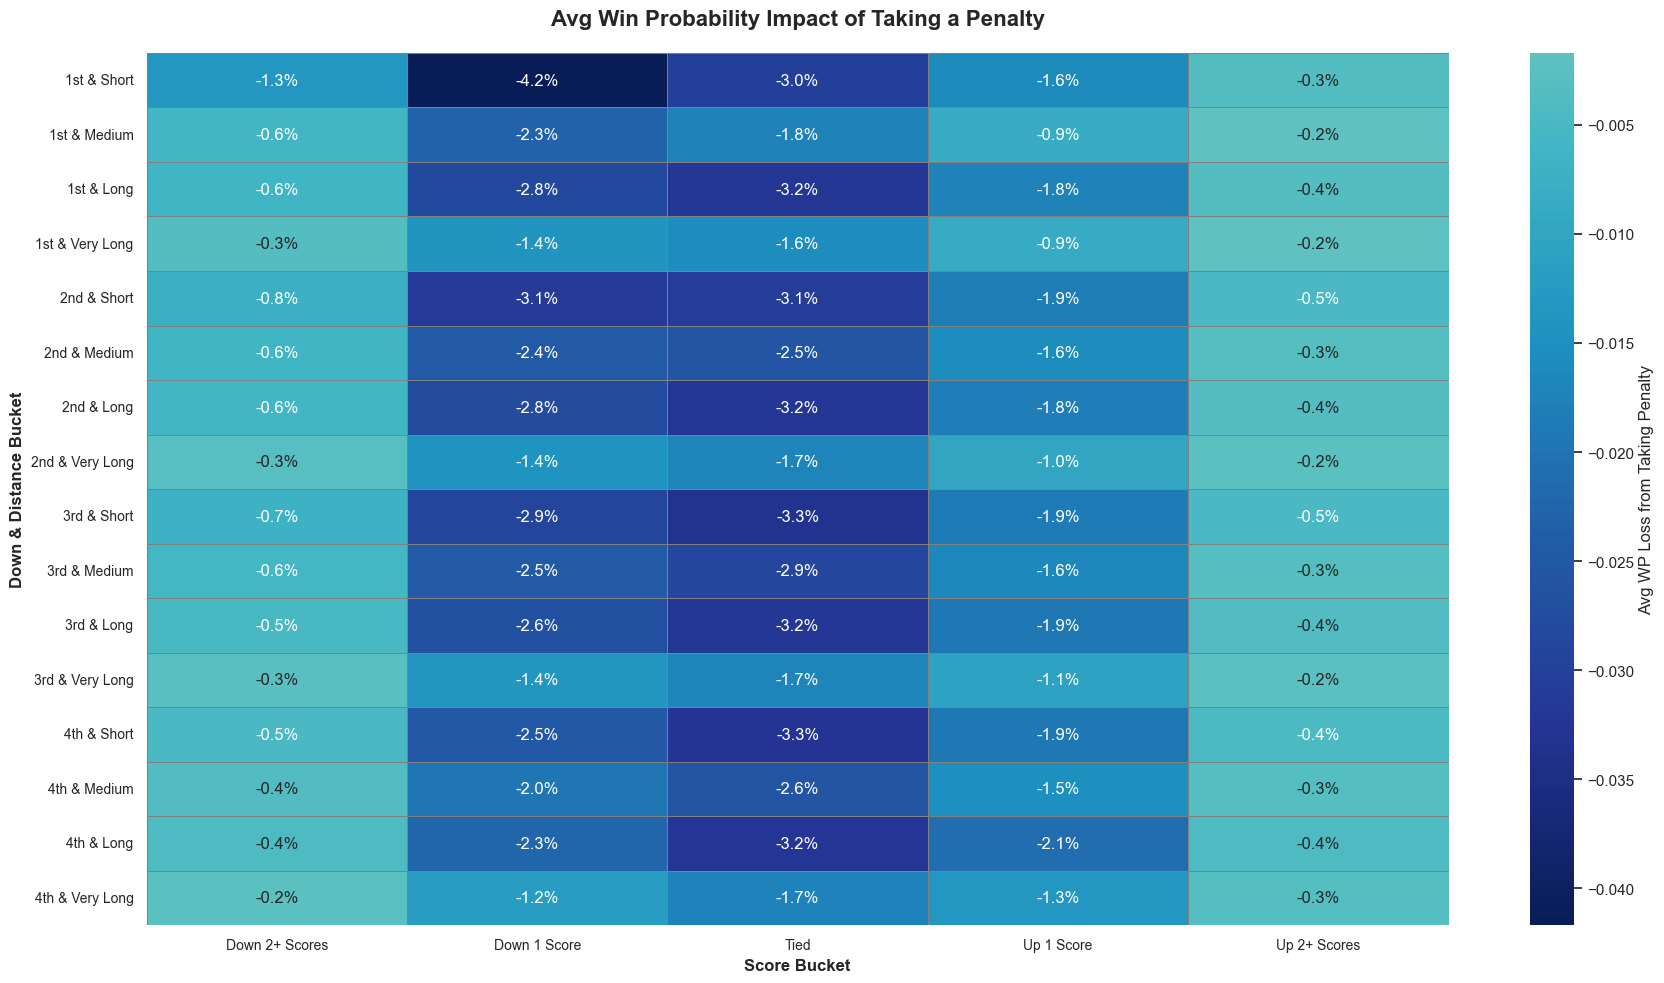

In [ ]:
#Heatmap #5: Down & Distance v. Score (WP Change from Taking a Penalty)


# 1. Filter only rows with valid marginal_to_3 data
df = pbp_final_analysis.copy()
df = df[df['pen_wp_change'].notna()].copy()
# df = df.query('marginal_to_3 > 0')

# 2. Group and aggregate mean WP impact
grouped_wp = df.groupby([
    'down_distance_bucket',
    'second_half_play_score_bucket'
]).agg(
    pen_wp_change_avg=('pen_wp_change', 'mean'),
    n=('pen_wp_change', 'count')
).reset_index()

# 3. Format label with avg and count
grouped_wp['label'] = grouped_wp.apply(
    lambda row: f"{row['pen_wp_change_avg']:.1%}", axis=1
)


# 5. Order down-distance buckets
desired_order = [
    '1st & Short', '1st & Medium', '1st & Long', '1st & Very Long',
    '2nd & Short', '2nd & Medium', '2nd & Long', '2nd & Very Long',
    '3rd & Short', '3rd & Medium', '3rd & Long', '3rd & Very Long',
    '4th & Short', '4th & Medium', '4th & Long', '4th & Very Long'
]

grouped_wp['down_distance_bucket'] = pd.Categorical(
    grouped_wp['down_distance_bucket'],
    categories=desired_order,
    ordered=True
)

# 6. Pivot for heatmap and labels
heatmap_data = grouped_wp.pivot(
    index='down_distance_bucket',
    columns='second_half_play_score_bucket',
    values='pen_wp_change_avg'
)
label_data = grouped_wp.pivot(
    index='down_distance_bucket',
    columns='second_half_play_score_bucket',
    values='label'
)

# 7. Align label to data
label_data = label_data.reindex(index=heatmap_data.index)


# Create custom diverging colormap from blue (negative) to yellow (positive)
plt.figure(figsize=(18, 10))
sns.set(style="whitegrid")

ax = sns.heatmap(
    heatmap_data,
    annot=label_data,
    fmt='',
    cmap='YlGnBu_r',
    center=-0.006,  # <- makes 0 the midpoint of the colormap
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Avg WP Loss from Taking Penalty'}
)

# Title and axis styling
plt.title(
    'Avg Win Probability Impact of Taking a Penalty',
    fontsize=16,
    fontweight='bold',
    pad=20
)
plt.ylabel('Down & Distance Bucket', fontsize=12, fontweight='bold')
plt.xlabel('Score Bucket', fontsize=12, fontweight='bold')
plt.xticks(rotation=0, ha='center', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

label_data.to_csv("pen_wp_change_expanded.csv")



/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/3719211199.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_wp = df.groupby([


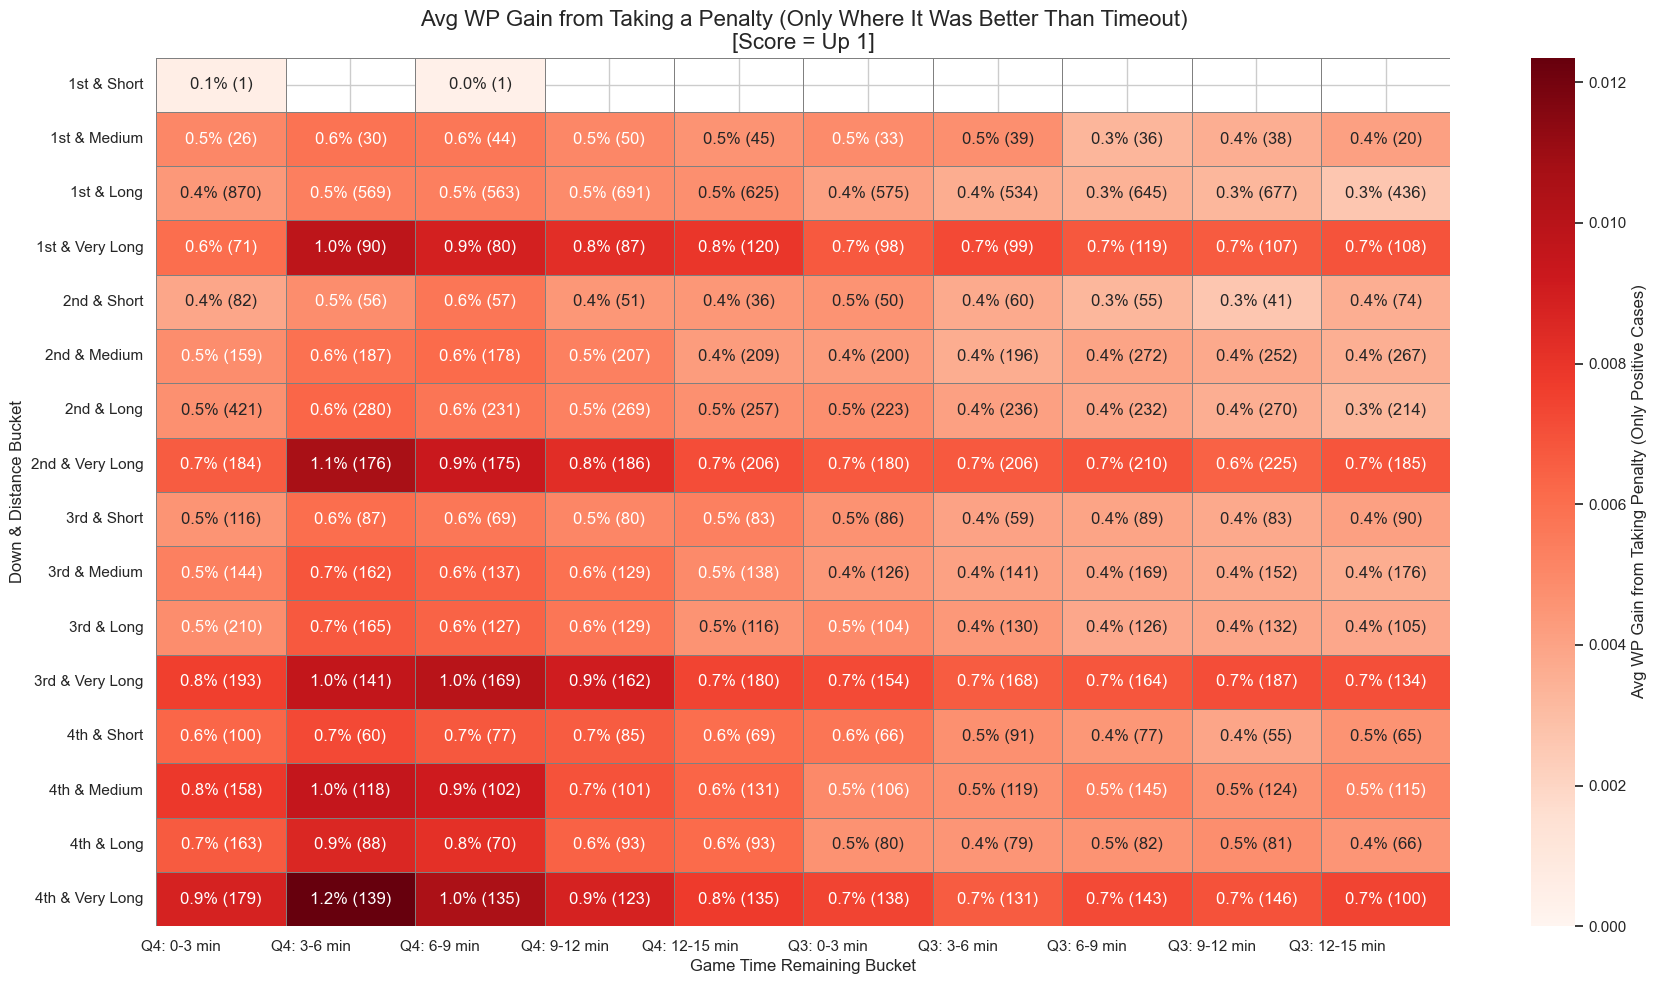

In [ ]:
#NOT USED: Heatmap of Positive WP Difference for "Down 2 Scores"

# 1. Filter only plays where taking the penalty is better (positive WP diff)
df = pbp_final_analysis.copy()
df = df[df['marginal_to_3'].notna() & (df['marginal_to_3'] > 0)].copy()

# 2. Group and compute mean WP diff
grouped_wp = df.groupby([
    'down_distance_bucket',
    'expanded_time_bucket',
    'second_half_play_score_bucket'
]).agg(
    avg_wp_diff=('marginal_to_3', 'mean'),
    n=('marginal_to_3', 'count')
).reset_index()

# 3. Label for each cell
grouped_wp['label'] = grouped_wp.apply(
    lambda row: f"{row['avg_wp_diff']:.1%} ({row['n']})", axis=1
)

# 4. Filter for a specific score state
grouped_wp_up1 = grouped_wp.query('second_half_play_score_bucket == "Down 1 Score"').copy()

# 5. Sort down-distance bucket
desired_order = [
    '1st & Short', '1st & Medium', '1st & Long', '1st & Very Long',
    '2nd & Short', '2nd & Medium', '2nd & Long', '2nd & Very Long',
    '3rd & Short', '3rd & Medium', '3rd & Long', '3rd & Very Long',
    '4th & Short', '4th & Medium', '4th & Long', '4th & Very Long'
]
grouped_wp_up1['down_distance_bucket'] = pd.Categorical(
    grouped_wp_up1['down_distance_bucket'],
    categories=desired_order,
    ordered=True
)

# 6. Pivot tables
heatmap_data = grouped_wp_up1.pivot(
    index='down_distance_bucket',
    columns='expanded_time_bucket',
    values='avg_wp_diff'
)
label_data = grouped_wp_up1.pivot(
    index='down_distance_bucket',
    columns='expanded_time_bucket',
    values='label'
)

# 7. Ensure label_data aligns
label_data = label_data.reindex(index=heatmap_data.index)

# 8. Plot the heatmap
plt.figure(figsize=(18, 10))
sns.set(style="whitegrid")

ax = sns.heatmap(
    heatmap_data,
    annot=label_data,
    fmt='',
    cmap='Reds',  # Only positive values now, so use Reds for clarity
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Avg WP Gain from Taking Penalty (Only Positive Cases)'},
    vmin=0
)

plt.title('Avg WP Gain from Taking a Penalty (Only Where It Was Better Than Timeout)\n[Score = Up 1]', fontsize=16)
plt.ylabel('Down & Distance Bucket', fontsize=12)
plt.xlabel('Game Time Remaining Bucket', fontsize=12)
plt.xticks(rotation=0, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
#NOT USED: Function to run through multiple graphs

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the y-axis order
desired_order = [
    '1st & Short', '1st & Medium', '1st & Long', '1st & Very Long',
    '2nd & Short', '2nd & Medium', '2nd & Long', '2nd & Very Long',
    '3rd & Short', '3rd & Medium', '3rd & Long', '3rd & Very Long',
    '4th & Short', '4th & Medium', '4th & Long', '4th & Very Long'
]

# Define a function to plot the heatmap
def plot_heatmap(df, title):
    # Set correct order
    df['down_distance_bucket'] = pd.Categorical(
        df['down_distance_bucket'], categories=desired_order, ordered=True
    )

    # Pivot data
    heatmap_data = df.pivot(
        index='down_distance_bucket',
        columns='expanded_time_bucket',
        values='penalty_pct'
    )
    label_data = df.pivot(
        index='down_distance_bucket',
        columns='expanded_time_bucket',
        values='label'
    )

    # Sort index
    heatmap_data = heatmap_data.sort_index()
    label_data = label_data.reindex(index=heatmap_data.index)

    # Plot
    plt.figure(figsize=(18, 10))
    sns.set(style="whitegrid")

    ax = sns.heatmap(
        heatmap_data,
        annot=label_data,
        fmt='',
        cmap='YlGnBu_r',
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={'label': '% Penalty Recommendation'},
        vmin=0,
        vmax=1
    )

    plt.title(title, fontsize=16)
    plt.ylabel('Down & Distance Bucket', fontsize=12)
    plt.xlabel('Game Time Remaining Bucket', fontsize=12)
    plt.xticks(rotation=0, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# List of score buckets and titles
score_buckets = [
    ("Down 1 Score", "Penalty vs Timeout Recommendation (Down 1 Score)"),
    ("Down 2+ Scores", "Penalty vs Timeout Recommendation (Down 2+ Scores)"),
    ("Up 1 Score", "Penalty vs Timeout Recommendation (Up 1 Score)"),
    ("Up 2+ Scores", "Penalty vs Timeout Recommendation (Up 2+ Scores)"),
    ("Tied", "Penalty vs Timeout Recommendation (Tied Game)")  # Optional 5th category if applicable
]




/var/folders/2g/3q0d_r6j6dv0h16f84t9zb280000gn/T/ipykernel_67558/725173075.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  marg_3_grouped = marg_3.groupby([


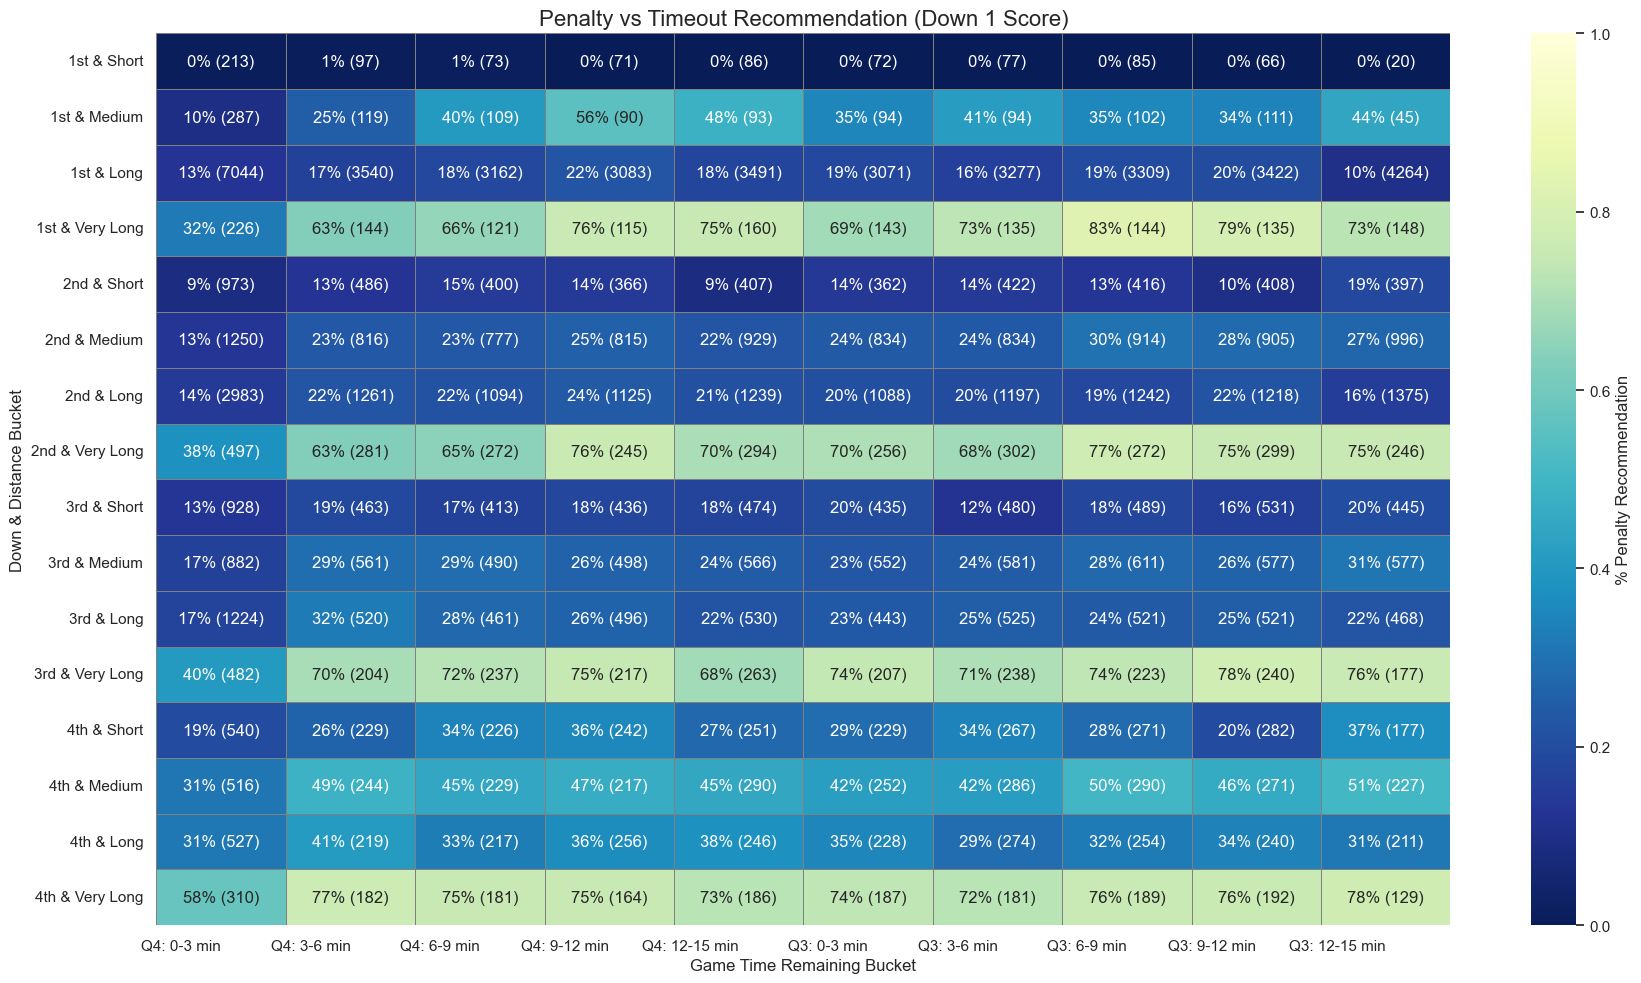

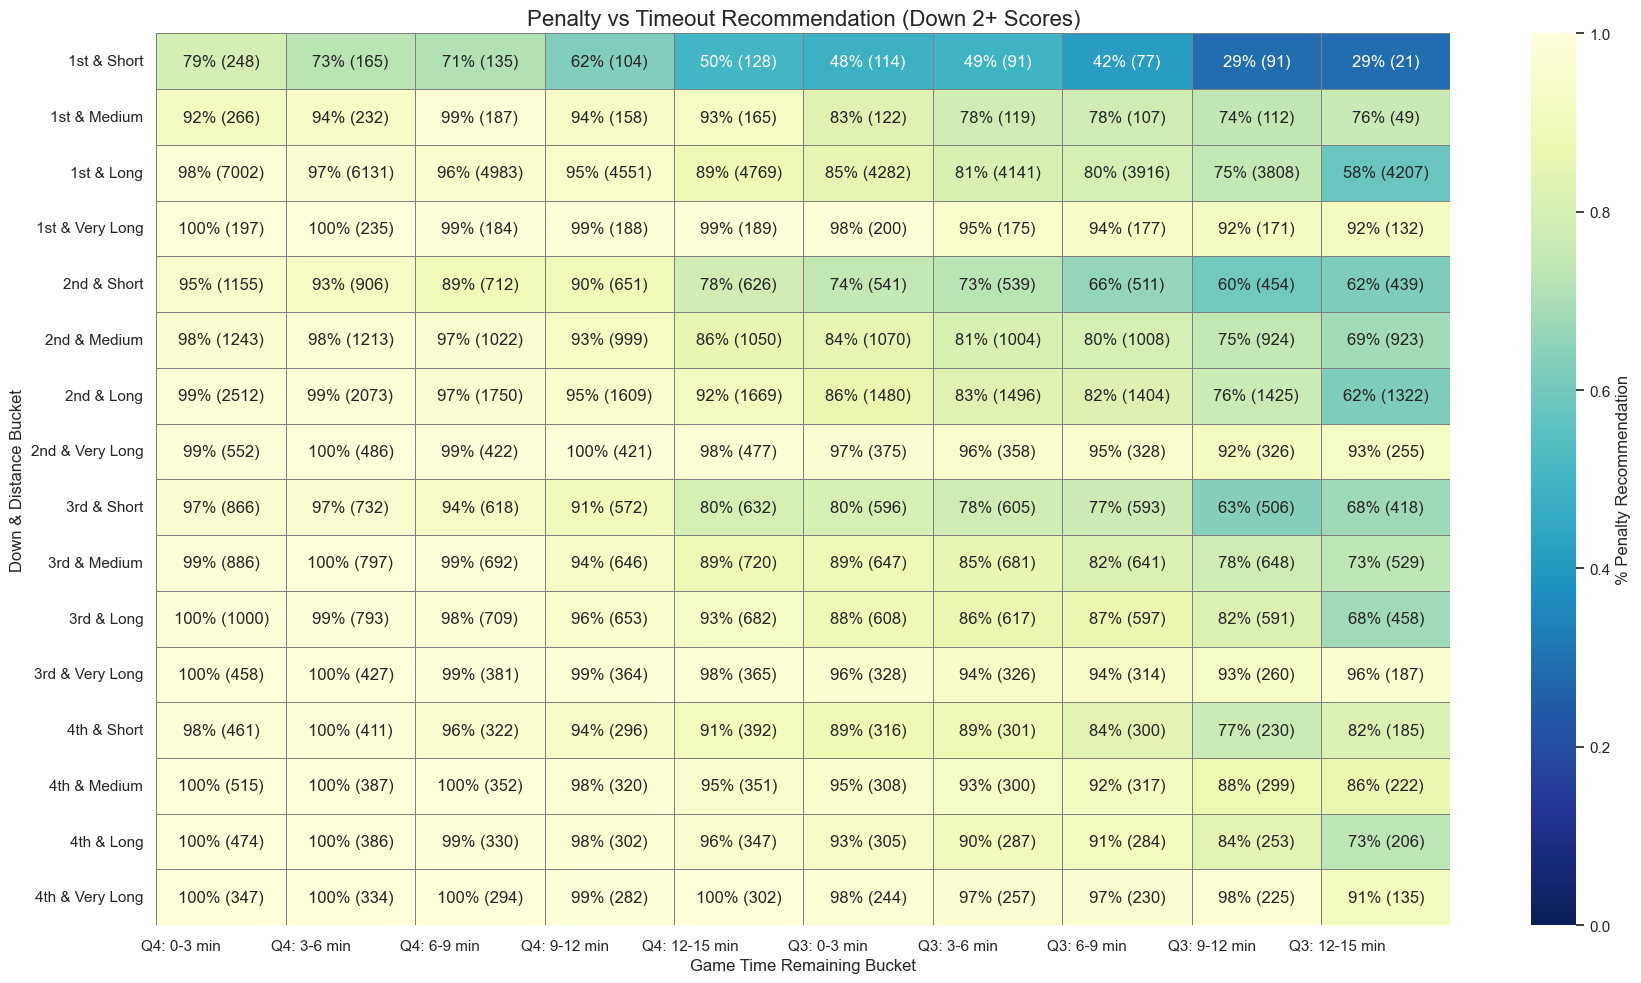

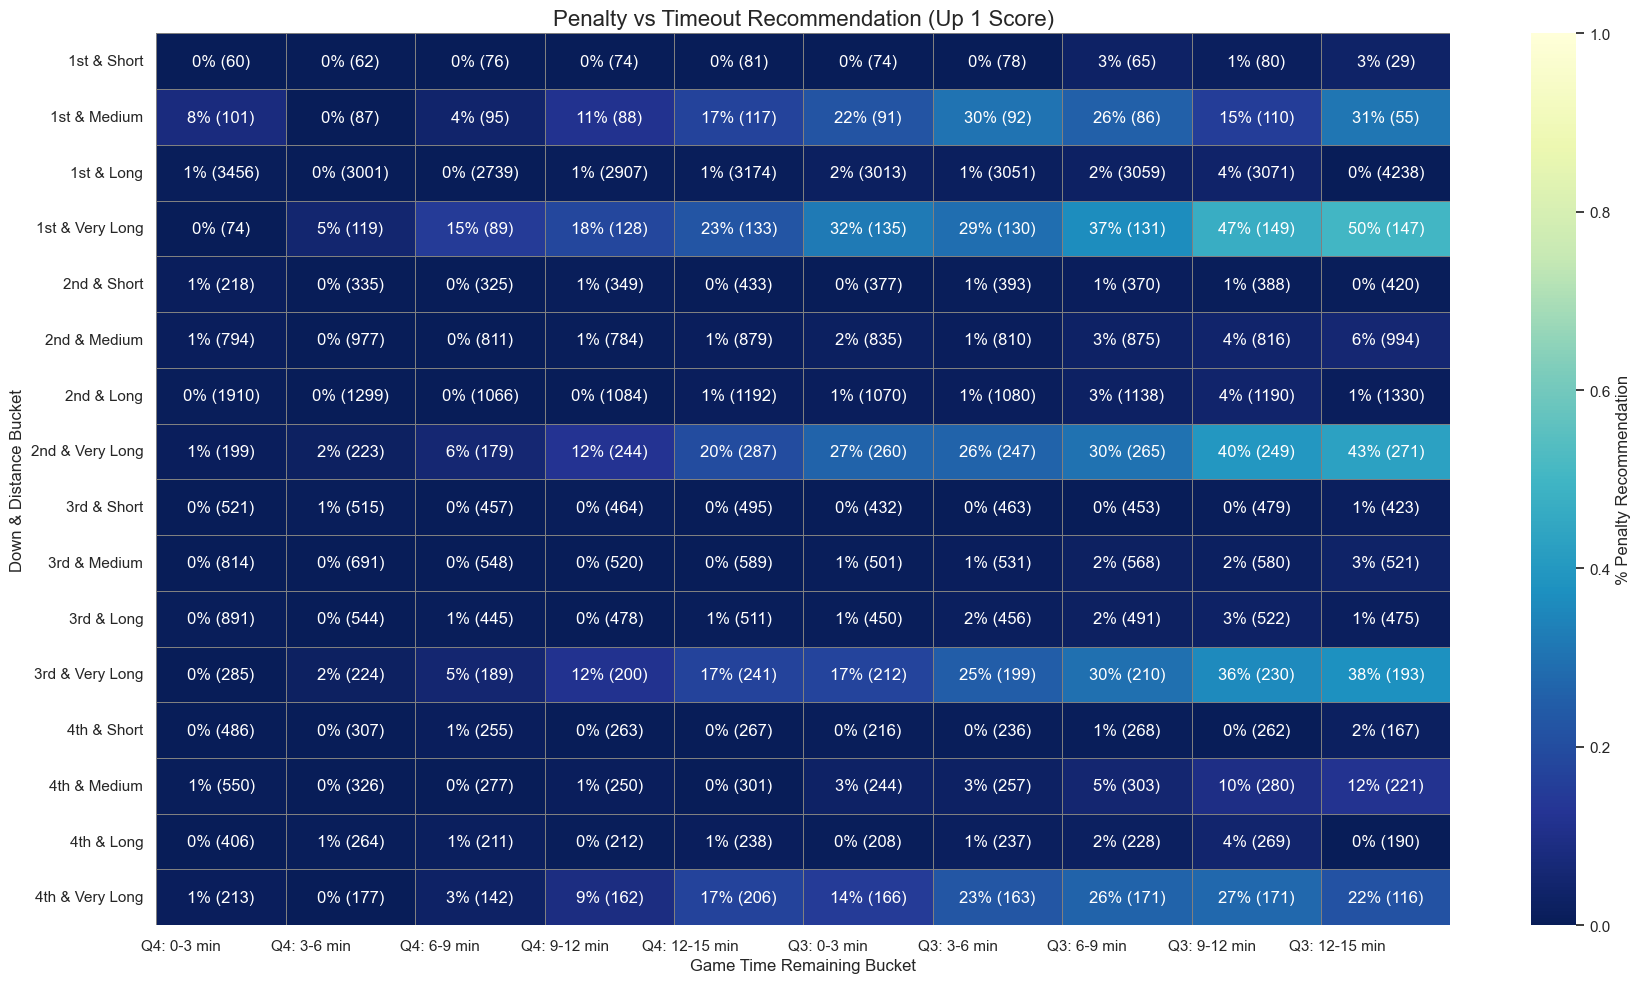

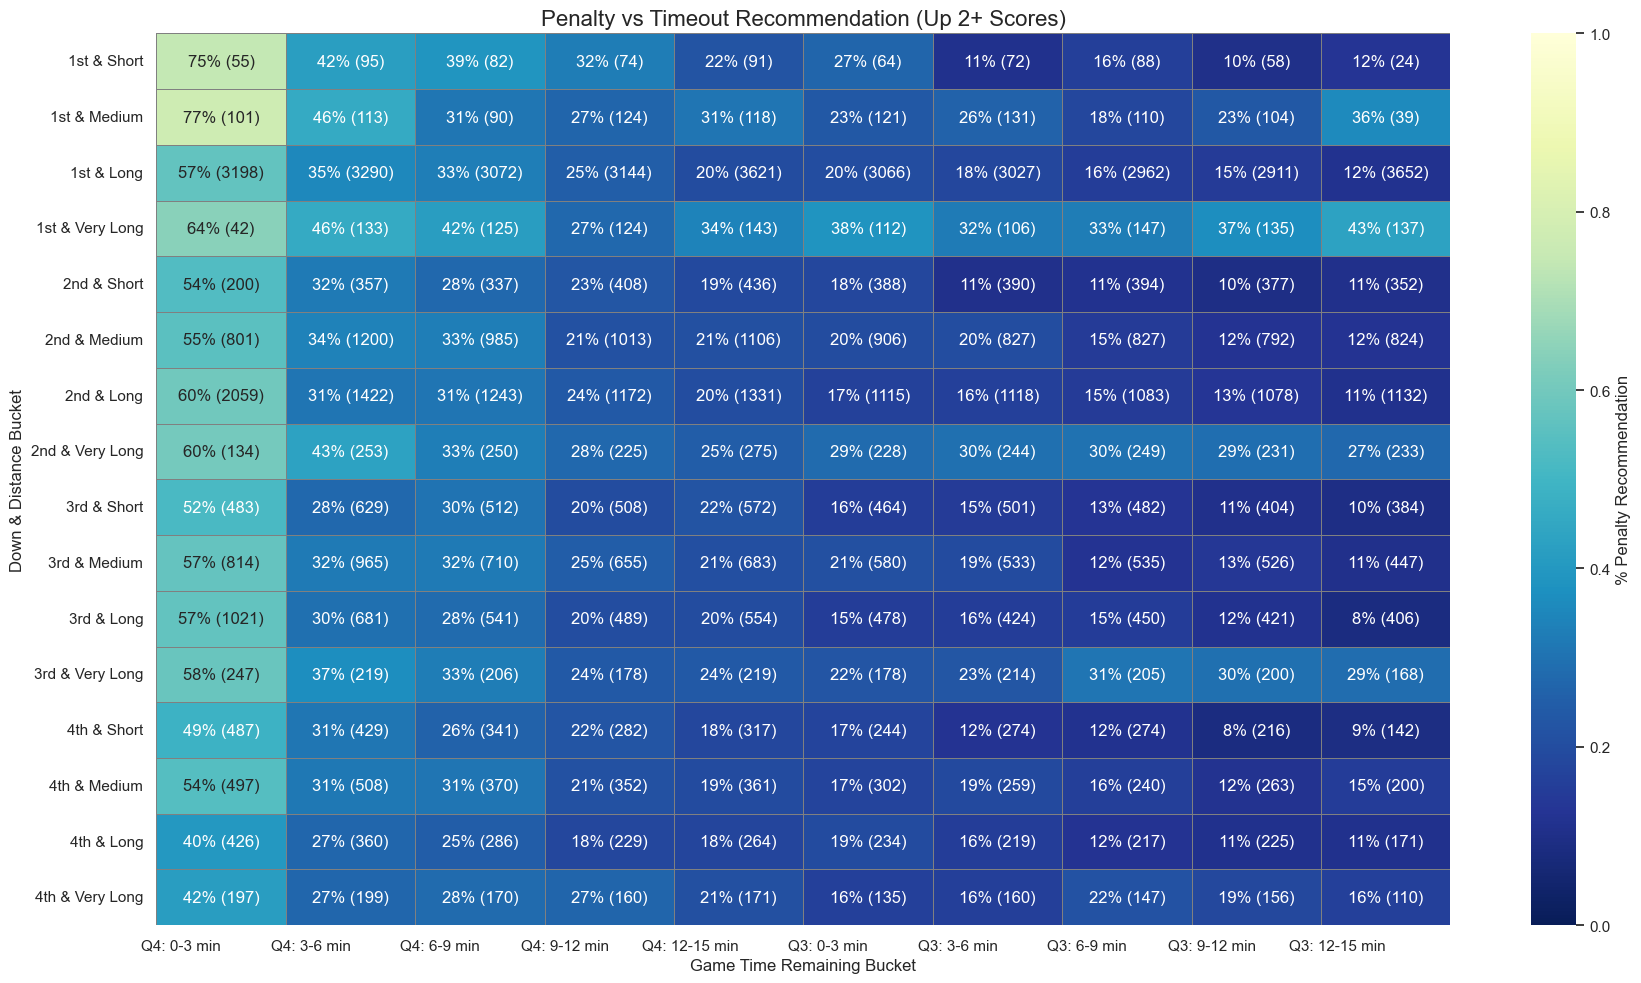

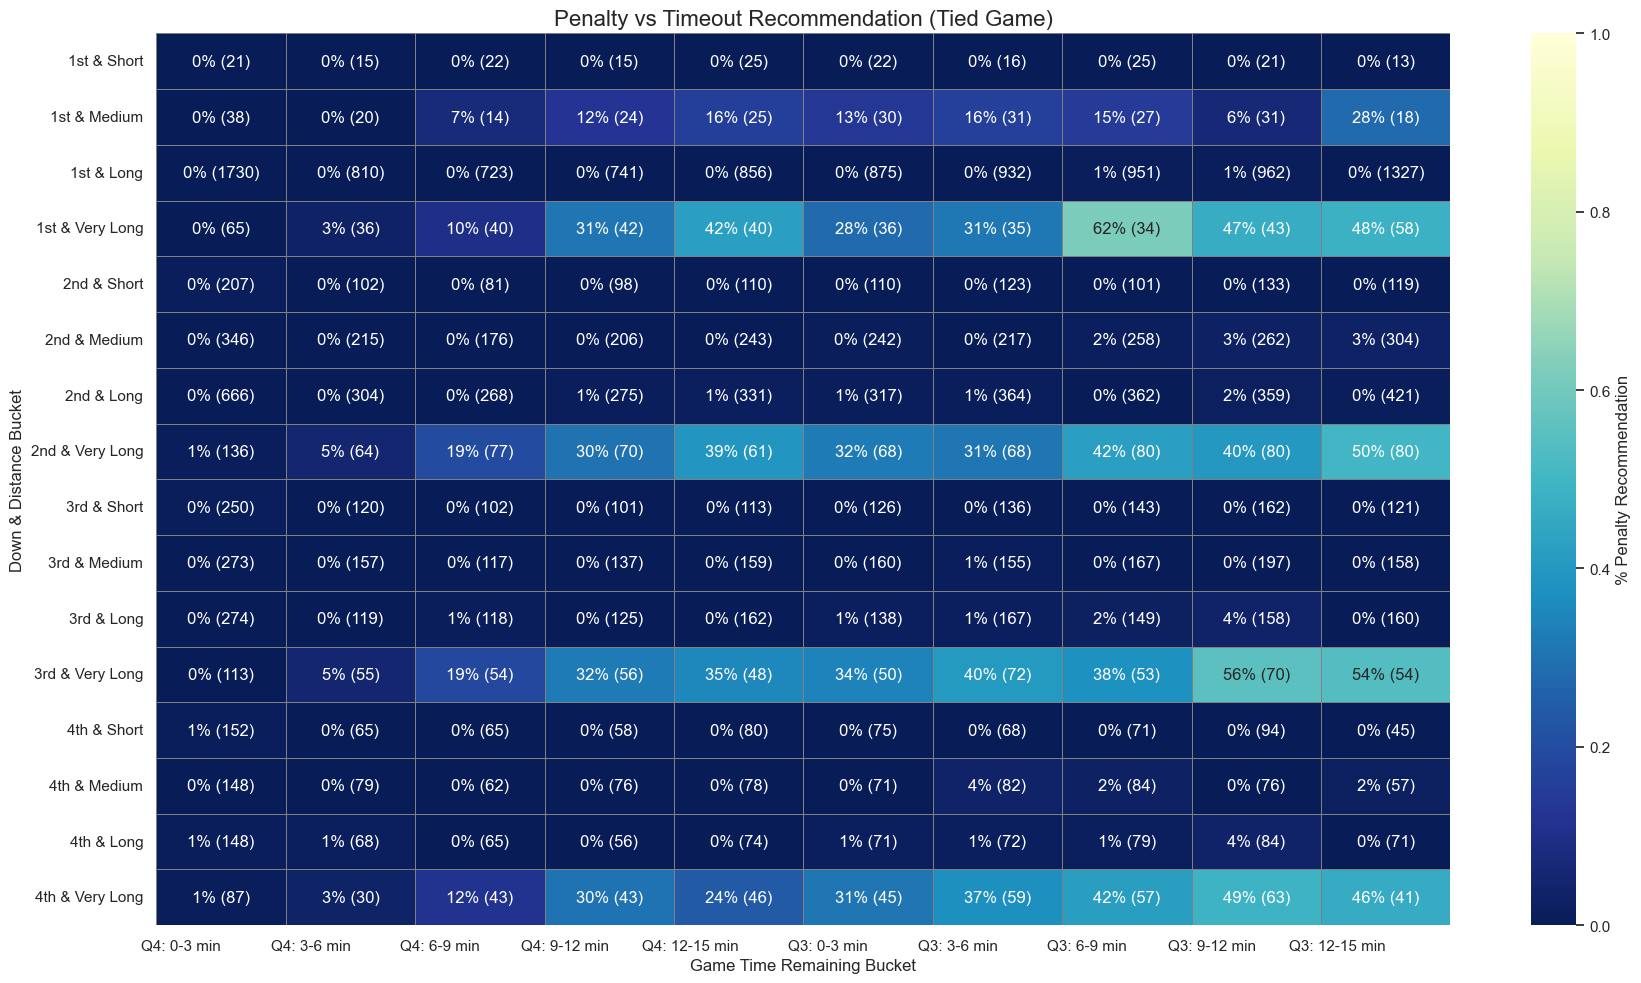

In [ ]:
#NOT USED: Graph Multiple Heatmaps for TO = 3

# 1. Filter only rows with valid recommendations
marg_3 = pbp_final_analysis.copy()
marg_3 = marg_3[marg_3['marginal_rec_to_3'].isin(['Take the Penalty', 'Take the Timeout'])]

# 2. Group and aggregate
marg_3_grouped = marg_3.groupby([
    # 'second_half_play_ydline_bucket',
    'down_distance_bucket',
    'expanded_time_bucket',
    'second_half_play_score_bucket',
]).agg(
    total_plays=('marginal_rec_to_3', 'count'),
    penalty_plays=('marginal_rec_to_3', lambda x: (x == 'Take the Penalty').sum())
).reset_index()

# 3. Compute percentage
marg_3_grouped['penalty_pct'] = marg_3_grouped['penalty_plays'] / marg_3_grouped['total_plays']
marg_3_grouped['label'] = marg_3_grouped.apply(
    lambda row: f"{row['penalty_pct']:.0%} ({int(row['total_plays'])})", axis=1
)


# Loop and generate plots
for bucket, title in score_buckets:
    df_subset = marg_3_grouped.query(f'second_half_play_score_bucket == "{bucket}"').copy()
    plot_heatmap(df_subset, title)

In [ ]:
# *** --------------------------------------------- ***

In [ ]:
# --------- Appendix: Penalty WP Model Code -----------

In [ ]:
# *** --------------------------------------------- ***

In [ ]:
#Run NFL Fast R's custom functions to load data and run WP Model (find_game_next_score_half, prepare_wp_data & make_model_mutations)

prepare_wp_data <- function(pbp) {

  if (any(is.na(pbp$spread_line))){
    broken_games <- pbp |>
      dplyr::filter(is.na(.data$spread_line)) |>
      dplyr::pull(.data$game_id) |>
      unique() |>
      sort()
    cli::cli_alert_danger(
      "The following game{?s} {?is/are} missing valid spread lines: {.val {broken_games}}."
    )
    cli::cli_alert_warning(
      "nflfastR will manually set the spread for the home team to {.val 1.5} points!"
    )
    cli::cli_alert_warning(
      "If you see this, please reach out to the package maintainers {.url https://github.com/nflverse/nflfastR/issues}"
    )
    pbp$spread_line[is.na(pbp$spread_line)] <- 1.5
  }

  pbp <- pbp |>
    dplyr::group_by(.data$game_id) |>
    dplyr::mutate(
      receive_2h_ko = dplyr::if_else(.data$qtr <= 2 & .data$posteam == dplyr::first(stats::na.omit(.data$defteam)), 1, 0)
    ) |>
    dplyr::ungroup() |>
    dplyr::mutate(
      posteam_spread = dplyr::if_else(.data$home == 1, .data$spread_line, -1 * .data$spread_line),
      elapsed_share = (3600 - .data$game_seconds_remaining) / 3600,
      spread_time = .data$posteam_spread * exp(-4 * .data$elapsed_share),
      Diff_Time_Ratio = .data$score_differential / (exp(-4 * .data$elapsed_share))
    )

  return(pbp)

}


make_model_mutations <- function(pbp) {

  pbp <- pbp |>
    dplyr::mutate(
      #for EP, CP, and WP model, xgb needs 0/1 for eras
      era0 = dplyr::if_else(.data$season <= 2001, 1, 0),
      era1 = dplyr::if_else(.data$season > 2001 & .data$season <= 2005, 1, 0),
      era2 = dplyr::if_else(.data$season > 2005 & .data$season <= 2013, 1, 0),
      era3 = dplyr::if_else(.data$season > 2013 & .data$season <= 2017, 1, 0),
      era4 = dplyr::if_else(.data$season > 2017, 1, 0),
      #for fg model, an era factor
      era = dplyr::case_when(
        .data$era0 == 1 ~ 0,
        .data$era1 == 1 ~ 1,
        .data$era2 == 1 ~ 2,
        .data$era3 == 1 | era4 == 1 ~ 3
      ),
      era = as.factor(.data$era),
      down1 = dplyr::if_else(.data$down == 1, 1, 0),
      down2 = dplyr::if_else(.data$down == 2, 1, 0),
      down3 = dplyr::if_else(.data$down == 3, 1, 0),
      down4 = dplyr::if_else(.data$down == 4, 1, 0),
      home = dplyr::if_else(.data$posteam == .data$home_team, 1, 0),
      model_roof = dplyr::if_else(is.na(.data$roof) | .data$roof == 'open' | .data$roof == 'closed', as.character('retractable'), as.character(.data$roof)),
      model_roof = as.factor(.data$model_roof),
      retractable = dplyr::if_else(.data$model_roof == 'retractable', 1, 0),
      dome = dplyr::if_else(.data$model_roof == 'dome', 1, 0),
      outdoors = dplyr::if_else(.data$model_roof == 'outdoors', 1, 0)
    )

  return(pbp)
}

find_game_next_score_half <- function(pbp_dataset) {

  # Which rows are the scoring plays:
  score_plays <- which(pbp_dataset$sp == 1 & pbp_dataset$play_type != "no_play")

  # Define a helper function that takes in the current play index,
  # a vector of the scoring play indices, play-by-play data,
  # and returns the score type and drive number for the next score:
  find_next_score <- function(play_i, score_plays_i,pbp_df) {

    # Find the next score index for the current play
    # based on being the first next score index:
    next_score_i <- score_plays_i[which(score_plays_i >= play_i)[1]]

    # If next_score_i is NA (no more scores after current play)
    # or if the next score is in another half,
    # then return No_Score and the current drive number
    if (is.na(next_score_i) |
        (pbp_df$qtr[play_i] %in% c(1, 2) & pbp_df$qtr[next_score_i] %in% c(3, 4, 5)) |
        (pbp_df$qtr[play_i] %in% c(3, 4) & pbp_df$qtr[next_score_i] == 5)) {

      score_type <- "No_Score"

      # Make it the current play index
      score_drive <- pbp_df$drive[play_i]

      # Else return the observed next score type and drive number:
    } else {

      # Store the score_drive number
      score_drive <- pbp_df$drive[next_score_i]

      # Then check the play types to decide what to return
      # based on several types of cases for the next score:

      # 1: Return TD
      if (pbp_df$touchdown[next_score_i] == 1 & (pbp_df$td_team[next_score_i] != pbp_df$posteam[next_score_i])) {

        # For return touchdowns the current posteam would not have
        # possession at the time of return, so it's flipped:
        if (identical(pbp_df$posteam[play_i], pbp_df$posteam[next_score_i])) {

          score_type <- "Opp_Touchdown"

        } else {

          score_type <- "Touchdown"

        }
      } else if (identical(pbp_df$field_goal_result[next_score_i], "made")) {

        # 2: Field Goal
        # Current posteam made FG
        if (identical(pbp_df$posteam[play_i], pbp_df$posteam[next_score_i])) {

          score_type <- "Field_Goal"

          # Opponent made FG
        } else {

          score_type <- "Opp_Field_Goal"

        }

        # 3: Touchdown (returns already counted for)
      } else if (pbp_df$touchdown[next_score_i] == 1) {

        # Current posteam TD
        if (identical(pbp_df$posteam[play_i], pbp_df$posteam[next_score_i])) {

          score_type <- "Touchdown"

          # Opponent TD
        } else {

          score_type <- "Opp_Touchdown"

        }
        # 4: Safety (similar to returns)
      } else if (pbp_df$safety[next_score_i] == 1) {

        if (identical(pbp_df$posteam[play_i],pbp_df$posteam[next_score_i])) {

          score_type <- "Opp_Safety"

        } else {

          score_type <- "Safety"

        }
        # 5: Extra Points
      } else if (identical(pbp_df$extra_point_result[next_score_i], "good")) {

        # Current posteam Extra Point
        if (identical(pbp_df$posteam[play_i], pbp_df$posteam[next_score_i])) {

          score_type <- "Extra_Point"

          # Opponent Extra Point
        } else {

          score_type <- "Opp_Extra_Point"

        }
        # 6: Two Point Conversions
      } else if (identical(pbp_df$two_point_conv_result[next_score_i], "success")) {

        # Current posteam Two Point Conversion
        if (identical(pbp_df$posteam[play_i], pbp_df$posteam[next_score_i])) {

          score_type <- "Two_Point_Conversion"

          # Opponent Two Point Conversion
        } else {

          score_type <- "Opp_Two_Point_Conversion"

        }

        # 7: Defensive Two Point (like returns)
      } else if (identical(pbp_df$defensive_two_point_conv[next_score_i], 1)) {

        if (identical(pbp_df$posteam[play_i], pbp_df$posteam[next_score_i])) {

          score_type <- "Opp_Defensive_Two_Point"

        } else {

          score_type <- "Defensive_Two_Point"

        }

        # 8: Errors of some sort so return NA (but shouldn't take place)
      } else {

        score_type <- NA

      }
    }

    return(data.frame(Next_Score_Half = score_type,
                      Drive_Score_Half = score_drive))
  }

  # Using lapply and then bind_rows is much faster than
  # using map_dfr() here:
  lapply(c(1:nrow(pbp_dataset)), find_next_score,
         score_plays_i = score_plays, pbp_df = pbp_dataset) %>%
    bind_rows() %>%
    return
}

In [ ]:
#Load in play by play data

pbp_data <- purrr::map_df(2001:2023, function(season) {
  load_pbp(season)
    # %>%
    # filter(season_type == "REG")  # keep only regular season games
}) %>%
  mutate(
    Winner = if_else(home_score > away_score, home_team,
                     if_else(home_score < away_score, away_team, "TIE"))
  )

# get next score half using the provided function
pbp_next_score_half <- map_dfr(unique(pbp_data$game_id),
                               function(x) {
                                 pbp_data %>%
                                   filter(game_id == x) %>%
                                   find_game_next_score_half()
                               })

# bind to original df
pbp_data <- bind_cols(pbp_data, pbp_next_score_half)

# for estimating the models, apply some filters
pbp_data <- pbp_data %>%
  filter(Next_Score_Half %in% c("Opp_Field_Goal", "Opp_Safety", "Opp_Touchdown",
                                "Field_Goal", "No_Score", "Safety", "Touchdown") &
           play_type %in% c("field_goal", "no_play", "pass", "punt", "run",
                            "qb_spike","qb_kneel") &  #*** ADDED QB KNEELS BACK IN ***
           is.na(two_point_conv_result) &
           is.na(extra_point_result) &
           !is.na(down) &

           !is.na(game_seconds_remaining)) %>%
  # keep file size manageable — but keep identifiers like play_id
  select(
    game_id,
    play_id,
    Next_Score_Half,
    Drive_Score_Half,
    play_type,
    game_seconds_remaining,
    half_seconds_remaining,
    yardline_100,
    roof,
    posteam,
    defteam,
    posteam_score,
    defteam_score,
    home_team,
    ydstogo,
    season,
    qtr,
    down,

    week,
    drive,
    ep,
    score_differential,
    posteam_timeouts_remaining,
    defteam_timeouts_remaining,
    desc,
    receiver_player_name,
    pass_location,
    air_yards,
    yards_after_catch,
    complete_pass,
    incomplete_pass,
    interception,

    qb_hit,
    extra_point_result,
    field_goal_result,
    sp,
    Winner,
    spread_line,
    total_line
  )

# # Save output as cal_data.rds
# saveRDS(pbp_data, "models/cal_data.rds")

In [ ]:
#Create separate test_df
test_df <- pbp_data

In [ ]:
#Run Original WP Model

library(dplyr)

# Step 1: Prepare model dataset from raw PBP data
model_data <- pbp_data %>%
  filter(Winner != "TIE") %>%
  make_model_mutations() %>%
  prepare_wp_data() %>%
  mutate(label = ifelse(posteam == Winner, 1, 0)) %>%
  filter(
    !is.na(ep), !is.na(score_differential), !is.na(play_type), !is.na(label),
    !is.na(defteam_timeouts_remaining), !is.na(posteam_timeouts_remaining),
    !is.na(yardline_100), qtr <= 4
  ) %>%
  select(
    game_id, play_id, #FOR MERGING ONLY
    label,
    receive_2h_ko,
    spread_time,
    home,
    half_seconds_remaining,
    game_seconds_remaining,
    Diff_Time_Ratio,
    score_differential,
    down,
    ydstogo,
    yardline_100,
    posteam_timeouts_remaining,
    defteam_timeouts_remaining,
    season,
    qtr
  )

# Step 2: Explicitly define model features (ensure correct order)
model_features <- c(
  "receive_2h_ko",
  "spread_time",
  "home",
  "half_seconds_remaining",
  "game_seconds_remaining",
  "Diff_Time_Ratio",
  "score_differential",
  "down",
  "ydstogo",
  "yardline_100",
  "posteam_timeouts_remaining",
  "defteam_timeouts_remaining"
)

# Step 3: Create the model matrix for XGBoost input
model_matrix <- model.matrix(~ . + 0, data = model_data %>% select(all_of(model_features)))

# Step 4: Prepare label vector
label_vector <- model_data$label

# ✅ model_matrix is now ready for either prediction or training


nrounds <- 534
params <-
  list(
    booster = "gbtree",
    objective = "binary:logistic",
    eval_metric = c("logloss"),
    eta = 0.05,
    gamma = .79012017,
    subsample = 0.9224245,
    colsample_bytree = 5 / 12,
    max_depth = 5,
    min_child_weight = 7,
    monotone_constraints =
      "(0, 0, 0, 0, 0, 1, 1, -1, -1, -1, 1, -1)"
  )

seasons <- unique(model_data$season)

wp_preds <- predict(fastrmodels::wp_model_spread, model_matrix)

model_data_with_preds <- model_data %>%
  mutate(wp = wp_preds)

test_df <- test_df %>%
  left_join(model_data_with_preds %>% select(game_id, play_id, wp),
            by = c("game_id", "play_id"))

head(test_df, 10)

In [ ]:
#Run "Penalty" WP Model

library(dplyr)

# Step 1: Prepare model dataset from raw PBP data
library(dplyr)

# Step 1.5: Adjust yards_to_go and yardline_100 to reflect the impact of a 5 yard penalty
model_data_pen <- model_data %>%
  mutate(
    ydstogo = if_else(yardline_100 > 90,
                           ydstogo + floor((100 - yardline_100) / 2),
                           ydstogo + 5),
    yardline_100 = if_else(yardline_100 > 90,
                           yardline_100 + floor((100 - yardline_100) / 2),
                           yardline_100 + 5)
  )

# Step 2: Create model matrix with same features
model_features <- c(
  "receive_2h_ko",
  "spread_time",
  "home",
  "half_seconds_remaining",
  "game_seconds_remaining",
  "Diff_Time_Ratio",
  "score_differential",
  "down",
  "ydstogo",
  "yardline_100",
  "posteam_timeouts_remaining",
  "defteam_timeouts_remaining"
)

model_matrix_pen <- model.matrix(~ . + 0, data = model_data_pen %>% select(all_of(model_features)))

# Step 3: Predict WP using the pretrained model
wp_preds_pen <- predict(fastrmodels::wp_model_spread, model_matrix_pen)

# Step 4: Add predictions back to test_df
model_data_pen <- model_data_pen %>%
  mutate(off_pen_wp = wp_preds_pen)

test_df <- test_df %>%
  left_join(model_data_pen %>% select(game_id, play_id, off_pen_wp),
            by = c("game_id", "play_id"))

# Preview final result
head(test_df, 10)


# # Step 3: Create the model matrix for XGBoost input
# model_matrix <- model.matrix(~ . + 0, data = model_data %>% select(all_of(model_features)))

# # Step 4: Prepare label vector
# label_vector <- model_data$label

# # ✅ model_matrix is now ready for either prediction or training


# nrounds <- 534
# params <-
#   list(
#     booster = "gbtree",
#     objective = "binary:logistic",
#     eval_metric = c("logloss"),
#     eta = 0.05,
#     gamma = .79012017,
#     subsample = 0.9224245,
#     colsample_bytree = 5 / 12,
#     max_depth = 5,
#     min_child_weight = 7,
#     monotone_constraints =
#       "(0, 0, 0, 0, 0, 1, 1, -1, -1, -1, 1, -1)"
#   )

# seasons <- unique(model_data$season)


In [ ]:
#Final Dataframe

test_df <- test_df %>%
    mutate(pen_wp_change = off_pen_wp - wp,
           to_wp_change = off_to_wp - wp)

head(test_df, 10)